## WeGo Data Introduction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# This may take a long time to read in, so it would be advised to convert this to a csv early on.
wego = pd.read_csv("../data/Headway Data, 8-1-2023 to 9-30-2023.csv")

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.500000
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,9,0.000000
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,19,0.000000
3,120230801,1,99457893,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,35,0.000000
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,36,12.866666


In [3]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS'],
      dtype='object')

In the data, the bus route can be identified by its ROUTE_ABBR value.  
**3:** West End  
**7:** Hillsboro  
**22:** Bordeaux  
**23:** Dickerson Pike  
**50:** Charlotte Pike  
**52:** Nolensville Pike  
**55:** Murfreesboro Pike  
**56:** Gallatin Pike

In [4]:
wego['ROUTE_ABBR'].value_counts().sort_index()

ROUTE_ABBR
3     47162
7     18026
22    25958
23    42108
50    43291
52    51819
55    61944
56    60020
Name: count, dtype: int64

The trip can be identified by the DATE/CALENDAR_ID plus the TRIP_ID.  
**Warning:** The TRIP_ID refers to the route and time but will be used across multiple days.

The data contains multiple **time points** for each trip. There are more stops along the route than time points, but the time points are the points with specific scheduled times the bus operators must adhere to.

The first stop of a trip has a TRIP_EDGE of 1, the last has a TRIP_EDGE of 2, and the intermediate stops are TRIP_EDGE 0. 

Here is the first trip in the dataset. It was a Bordeaux route, scheduled to start at 4:42:00 and end at 5:10:00.

In [5]:
# scheduled time is time of departure
# trip edge 1 is the start, 0 is the intermeidate points, and trip edge 2 is the end.
wego[['DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR', 'TIME_POINT_ABBR', 'TRIP_EDGE', 'SCHEDULED_TIME']].loc[:3]

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME
0,8/1/2023,120230801,345104,22,MHSP,1,4:42:00
1,8/1/2023,120230801,345104,22,ELIZ,0,4:46:00
2,8/1/2023,120230801,345104,22,CV23,0,4:54:00
3,8/1/2023,120230801,345104,22,MCC5_10,2,5:10:00


Note that the same TRIP_ID appears on the following day.

In [6]:
(
    wego
    .loc[wego['DATE'].isin(['8/1/2023', '8/2/2023'])]
    .loc[wego['TRIP_ID'] == 345104]
    [['DATE', 'ROUTE_ABBR', 'TRIP_ID', 'TIME_POINT_ABBR', 'TRIP_EDGE', 'SCHEDULED_TIME']]
)

,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME
0,8/1/2023,22,345104,MHSP,1,4:42:00
1,8/1/2023,22,345104,ELIZ,0,4:46:00
2,8/1/2023,22,345104,CV23,0,4:54:00
3,8/1/2023,22,345104,MCC5_10,2,5:10:00
6461,8/2/2023,22,345104,MHSP,1,4:42:00
6462,8/2/2023,22,345104,ELIZ,0,4:46:00
6463,8/2/2023,22,345104,CV23,0,4:54:00
6464,8/2/2023,22,345104,MCC5_10,2,5:10:00


**Adherence** refers to the difference between scheduled time and the actual time that the bus departs from a stop.

A negative value for ADHERENCE indicates that the bus is late, and a positive indicates that the bus is early.

Generally, an adherence value less than -6 is considered late, and greater than 1 is considered early, but there are some exceptions. For example, a positive adherence for the end of a trip (TRIP_EDGE 2) is not considered early, since it is not a problem if a bus ends its trip early as long as it didn't pass other timepoints early along the way. You can check whether a trip was considered on-time, early, or late using the ADJUSTED_EARLY_COUNT, ADJUSTED_LATE_COUNT, and ADJUSTED_ONTIME_COUNT columns.

Here is an example of a trip where all time points would be considered to be on time.

In [7]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[:3]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
0,8/1/2023,120230801,345104,22,MHSP,1,4:42:00,4:44:08,-2.133333,0,0,1
1,8/1/2023,120230801,345104,22,ELIZ,0,4:46:00,4:48:27,-2.450000,0,0,1
2,8/1/2023,120230801,345104,22,CV23,0,4:54:00,4:54:56,-0.933333,0,0,1
3,8/1/2023,120230801,345104,22,MCC5_10,2,5:10:00,5:03:43,6.283333,0,0,1


And one that has one late stop.

In [8]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[77:79]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
77,8/1/2023,120230801,345127,22,MHSP,1,17:05:00,17:08:21,-3.350000,0,0,1
78,8/1/2023,120230801,345127,22,CV23,0,17:14:00,17:20:10,-6.166666,0,1,0
79,8/1/2023,120230801,345127,22,MCC5_10,2,17:30:00,17:30:23,-0.383333,0,0,1


And one which was early.

In [9]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[11:13]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
11,8/1/2023,120230801,345107,22,MCC5_10,1,6:15:00,6:16:19,-1.316666,0,0,1
12,8/1/2023,120230801,345107,22,CV23,0,6:25:00,6:23:30,1.500000,1,0,0
13,8/1/2023,120230801,345107,22,MHSP,2,6:35:00,6:30:59,4.016666,0,0,1


**Headway** is the amount of time between a bus and the prior bus at the same stop. In the dataset, the amount of headway scheduled is contained in the SCHEDULED_HDWY column and indicates the difference between the scheduled time for a particular stop and the scheduled time for the previous bus on that same stop.

This dataset contains a column HDWY_DEV, which shows the amount of deviation from the scheduled headway. **Bunching** occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. **Gapping** is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. 

The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

In [10]:
(
    wego
    .loc[wego['ROUTE_ABBR'] == 22]
    .loc[wego['ROUTE_DIRECTION_NAME'] == 'TO DOWNTOWN']
    .loc[wego['TIME_POINT_ABBR'] == 'CV23']
    [['DATE', 'TRIP_ID', 'TIME_POINT_ABBR','ROUTE_DIRECTION_NAME',
      'SCHEDULED_TIME', 'SCHEDULED_HDWY',
      'ACTUAL_DEPARTURE_TIME', 'ACTUAL_HDWY', 'HDWY_DEV'
     ]]
    .sort_values(['DATE', 'SCHEDULED_TIME'])
    .iloc[:5]
)

,DATE,TRIP_ID,TIME_POINT_ABBR,ROUTE_DIRECTION_NAME,SCHEDULED_TIME,SCHEDULED_HDWY,ACTUAL_DEPARTURE_TIME,ACTUAL_HDWY,HDWY_DEV
227,8/1/2023,345297,CV23,TO DOWNTOWN,10:09:00,10.0,10:09:34,8.866666,-1.133334
432,8/1/2023,345415,CV23,TO DOWNTOWN,10:22:00,13.0,10:22:52,13.300000,0.300000
164,8/1/2023,345223,CV23,TO DOWNTOWN,10:34:00,12.0,NaN,NaN,NaN
346,8/1/2023,345387,CV23,TO DOWNTOWN,10:47:00,13.0,10:49:39,26.783333,13.783333
43,8/1/2023,345116,CV23,TO DOWNTOWN,10:59:00,12.0,11:00:47,11.133333,-0.866667


One column that you've been asked to explore is the DWELL_IN_MINS column, which shows the difference between actual arrival and actual departure time at a time point. 

In [11]:
wego.loc[4:4, ['DATE', 'TRIP_ID', 'TRIP_EDGE',
               'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'DWELL_IN_MINS']]

,DATE,TRIP_ID,TRIP_EDGE,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,DWELL_IN_MINS
4,8/1/2023,345105,1,5:03:43,5:16:35,12.866666


# 1. What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

In [12]:
#SCHEDULED_TIME and ACTUAL_ARRIVAL_TIME, and ACTUAL_DEPARTURE_TIME
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.500000
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,9,0.000000
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,19,0.000000
3,120230801,1,99457893,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,35,0.000000
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,36,12.866666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,35.266666,5.266666,0,1,0,0,0.0,0,539,0.000000
350324,120230930,2,100406611,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,NaN,NaN,0,1,0,0,NaN,0,551,0.000000
350325,120230930,2,100406612,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,31.866666,1.866666,0,0,1,0,0.0,0,552,0.000000
350326,120230930,2,100406613,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,47.500000,17.500000,0,1,0,0,0.0,0,563,0.000000


In [13]:
wego.columns = wego.columns.str.lower()
wego = wego.loc[wego['trip_edge'] != 2]
wego

,calendar_id,service_abbr,adherence_id,date,route_abbr,block_abbr,operator,trip_id,overload_id,route_direction_name,...,actual_hdwy,hdwy_dev,adjusted_early_count,adjusted_late_count,adjusted_ontime_count,stop_cancelled,prev_sched_stop_cancelled,is_relief,block_stop_order,dwell_in_mins
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.500000
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,9,0.000000
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,19,0.000000
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,36,12.866666
5,120230801,1,99457895,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,51,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350320,120230930,2,100406607,9/30/2023,7,702,2312,353447,0,FROM DOWNTOWN,...,NaN,NaN,0,0,0,0,0.0,0,515,NaN
350322,120230930,2,100406609,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,34.916666,4.916666,0,1,0,0,0.0,0,530,1.966666
350323,120230930,2,100406610,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,35.266666,5.266666,0,1,0,0,0.0,0,539,0.000000
350325,120230930,2,100406612,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,31.866666,1.866666,0,0,1,0,0.0,0,552,0.000000


In [14]:
wego_clean = wego.fillna('null')
wego_clean = wego_clean.loc[(wego_clean['adherence'] != 'null')]
wego_clean

,calendar_id,service_abbr,adherence_id,date,route_abbr,block_abbr,operator,trip_id,overload_id,route_direction_name,...,actual_hdwy,hdwy_dev,adjusted_early_count,adjusted_late_count,adjusted_ontime_count,stop_cancelled,prev_sched_stop_cancelled,is_relief,block_stop_order,dwell_in_mins
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,null,null,0,0,1,0,0.0,0,2,6.5
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,null,null,0,0,1,0,0.0,0,9,0.0
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,null,null,0,0,1,0,0.0,0,19,0.0
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,null,null,0,0,1,0,0.0,0,36,12.866666
5,120230801,1,99457895,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,null,null,0,0,1,0,0.0,0,51,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350319,120230930,2,100406606,9/30/2023,7,702,2312,353447,0,FROM DOWNTOWN,...,36.716666,6.716666,0,0,1,0,0.0,0,504,7.033333
350322,120230930,2,100406609,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,34.916666,4.916666,0,1,0,0,0.0,0,530,1.966666
350323,120230930,2,100406610,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,35.266666,5.266666,0,1,0,0,0.0,0,539,0.0
350325,120230930,2,100406612,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,31.866666,1.866666,0,0,1,0,0.0,0,552,0.0


In [ ]:
for ind, row in wego_clean.iterrows():
    if row.adherence > 1:
        wego_clean.loc[ind, 'on_time_performance'] = 'Early'
    elif row.adherence < -6:
        wego_clean.loc[ind, 'on_time_performance'] = 'Late'
    else:
        wego_clean.loc[ind, 'on_time_performance'] = 'On Time'

In [ ]:
OTP_count = wego_clean.on_time_performance.value_counts().to_frame().reset_index()
OTP_count

In [ ]:
#OTP_count['percent'] = OTP_count['count'] + OTP_count[1] + OTP_count[2]
#OTP_count

In [ ]:
labels = 'On Time', 'Late', 'Early'
sizes = [217544, 46633, 9406]

explode = (0.1, 0.1, 0.1)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
       shadow=True, startangle=45,
       colors=['forestgreen', 'firebrick', 'royalblue']);
#- WeGo purple: #6F4DA0 or RGB: 111, 77, 160
#- WeGo silver: #939598 or RGB: 147, 149, 152
#- WeGo black: #231f20 or RGB: 35, 31, 32

In [ ]:
#expanding the above information by day

In [ ]:
wego.head()

In [ ]:
wego_clean['date'] = pd.to_datetime(wego_clean['date'])

In [ ]:
wego_clean['day'] = wego_clean['date'].dt.day_name()

In [ ]:
day_OTP = wego_clean[['day', 'on_time_performance']]
day_OTP

In [ ]:
#dictionary to new column to sort values
day_to_num = {
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
day_OTP['day_num'] = day_OTP['day'].map(day_to_num)
day_OTP = day_OTP.sort_values(by='day_num')
day_OTP

In [ ]:
day_OTP.day.value_counts()

In [ ]:
daily_breakdown = day_OTP.groupby(['day','on_time_performance']).value_counts().reset_index()
daily_breakdown = daily_breakdown.sort_values('day_num')
daily_breakdown

In [ ]:
graph = sns.catplot(
        data=daily_breakdown, x="day", y="count", hue="on_time_performance",
        kind="bar", height=8, aspect=2)
for ax in graph.axes.flat:
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    ax.bar_label(ax.containers[2])
plt.title('On Time Performance by Day', fontsize = 24, fontweight = 'bold')
plt.ylabel('Count', fontsize = 18, fontweight = 'bold')
plt.xlabel('');
#- WeGo purple: #6F4DA0 or RGB: 111, 77, 160
#- WeGo silver: #939598 or RGB: 147, 149, 152
#- WeGo black: #231f20 or RGB: 35, 31, 32

# By Operator Performance

In [ ]:
OP_OTP = wego_clean[['operator', 'on_time_performance']]
OP_OTP

In [ ]:
OP_OTP = OP_OTP.groupby(['operator','on_time_performance']).value_counts().reset_index()
OP_OTP

In [ ]:
top_OPS = OP_OTP[['operator','count']]
top_OPS = top_OPS.groupby('operator')['count'].sum().to_frame().reset_index()
top_OPS = top_OPS.sort_values('count', ascending = False)
top_OPS.reset_index(drop= True)

In [ ]:
top_OPS = top_OPS.head(10).reset_index
top_OPS

In [ ]:
#finish by operator^^^^^^

# 1B. what do the overall distributions of adherence and headway deviation look like?

# Adherence

In [ ]:
wego_clean[['scheduled_time', 'actual_departure_time', 'adherence']]

In [ ]:
wego_clean['adherence'].describe()

In [ ]:
sns.boxplot(wego_clean.adherence, showfliers = False, color = 'gold')
plt.xlabel('Adherence Distribution')
plt.ylabel('Adherence Values')
plt.title('Adherence from Aug & Sept 2023')
plt.show()
#- WeGo purple: #6F4DA0 or RGB: 111, 77, 160
#- WeGo silver: #939598 or RGB: 147, 149, 152
#- WeGo black: #231f20 or RGB: 35, 31, 32

# Headway 
-hdwy_dev is "bunching"::::::::::: 
+hdwy_dev is "gapping":::::::::::
headway deviation % as hdwy_dev/scheduled_hdwy

headway, bus leaves bus stop, start a stop watch, stop timer when next bus arrives

In [ ]:
wego_clean['hdwy_dev'].describe()

In [ ]:
sns.boxplot(wego.hdwy_dev, showfliers = False, color = 'green')
plt.xlabel('Headway Deviation Distribution')
plt.ylabel('Headway Deviation Values')
plt.title('Headway Deviation from Aug & Sept 2023')
plt.show()
#- WeGo purple: #6F4DA0 or RGB: 111, 77, 160
#- WeGo silver: #939598 or RGB: 147, 149, 152
#- WeGo black: #231f20 or RGB: 35, 31, 32

In [ ]:
hdwy_metrics = wego_clean[['scheduled_hdwy','actual_hdwy','hdwy_dev']]
hdwy_metrics

In [ ]:
hdwy_metrics = hdwy_metrics.fillna('null')

In [ ]:
hdwy_metrics = hdwy_metrics.loc[(hdwy_metrics['scheduled_hdwy'] != 'null') & 
                  (hdwy_metrics['actual_hdwy'] != 'null') & 
                  (hdwy_metrics['hdwy_dev'] != 'null')]

In [ ]:
hdwy_metrics = hdwy_metrics.reset_index(drop = True)
hdwy_metrics

In [ ]:
350328 - 265892 #84436 Nulls

In [ ]:
for ind, row in hdwy_metrics.iterrows():
    if row.actual_hdwy > (row.scheduled_hdwy * 1.5):
        hdwy_metrics.loc[ind, 'overall_headway_deviation'] = 'Gapping'
    elif row.actual_hdwy < (row.scheduled_hdwy * 0.5):
        hdwy_metrics.loc[ind, 'overall_headway_deviation'] = 'Bunching'    
    else:
        hdwy_metrics.loc[ind, 'overall_headway_deviation'] = 'On Time'

In [ ]:
#w/o Nulls in hdwy_metrics
HM_clean = hdwy_metrics.overall_headway_deviation.value_counts().to_frame().reset_index()
HM_clean

In [ ]:
graph = sns.catplot(
        data=HM_clean, x="overall_headway_deviation", y="count",
        kind="bar", height=8, aspect=2)
for ax in graph.axes.flat:
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    ax.bar_label(ax.containers[2])
plt.title('Clean Headway Deviation', fontsize = 24, fontweight = 'bold')
plt.ylabel('Count', fontsize = 18, fontweight = 'bold')
plt.xlabel('Overall Headway Deviation');
#- WeGo purple: #6F4DA0 or RGB: 111, 77, 160
#- WeGo silver: #939598 or RGB: 147, 149, 152
#- WeGo black: #231f20 or RGB: 35, 31, 32

# 2. How does direction of travel, route, or location affect the headway and on-time performance?
# 4. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import regex as re
import matplotlib.pyplot as plt

In [2]:
wego = pd.read_csv("../data/headway_data.csv")#remove midnight trips
wego.shape

(350328, 30)

In [3]:
wego['HDWY_DEV_PCT'] = wego['HDWY_DEV']/wego['SCHEDULED_HDWY']*100

In [4]:
wego[['SCHEDULED_HDWY','HDWY_DEV','HDWY_DEV_PCT']]

,SCHEDULED_HDWY,HDWY_DEV,HDWY_DEV_PCT
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
350323,30.0,5.266666,17.555553
350324,NaN,NaN,NaN
350325,30.0,1.866666,6.222220
350326,30.0,17.500000,58.333333


In [5]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS', 'HDWY_DEV_PCT'],
      dtype='object')

In [6]:
wego['OPERATOR'].value_counts().reset_index()

,OPERATOR,count
0,2352,2970
1,1266,2911
2,1147,2710
3,1133,2625
4,2424,2577
...,...,...
336,2256,6
337,56,3
338,473,2
339,0,1


In [7]:
late_stops = wego.loc[wego['ADHERENCE'] < -6]
late_stops.shape

(59038, 31)

In [8]:
late_stops['OPERATOR'].value_counts().reset_index()

,OPERATOR,count
0,2109,936
1,1800,810
2,1204,767
3,3064,750
4,1352,728
...,...,...
327,473,1
328,2472,1
329,2313,1
330,2377,1


In [9]:
op_df = pd.merge(late_stops['OPERATOR'].value_counts().reset_index(), wego['OPERATOR'].value_counts().reset_index(), on='OPERATOR')
op_df

,OPERATOR,count_x,count_y
0,2109,936,2142
1,1800,810,1675
2,1204,767,2128
3,3064,750,1972
4,1352,728,1727
...,...,...,...
327,473,1,2
328,2472,1,38
329,2313,1,10
330,2377,1,10


In [10]:
op_df['late_pct'] = op_df['count_x'] / op_df['count_y'] * 100
op_df

,OPERATOR,count_x,count_y,late_pct
0,2109,936,2142,43.697479
1,1800,810,1675,48.358209
2,1204,767,2128,36.043233
3,3064,750,1972,38.032454
4,1352,728,1727,42.154024
...,...,...,...,...
327,473,1,2,50.000000
328,2472,1,38,2.631579
329,2313,1,10,10.000000
330,2377,1,10,10.000000


In [11]:
op_df.late_pct.describe()

count    332.000000
mean      19.126021
std       13.887537
min        0.610902
25%        9.659257
50%       16.123859
75%       24.489440
max      100.000000
Name: late_pct, dtype: float64

<Axes: >

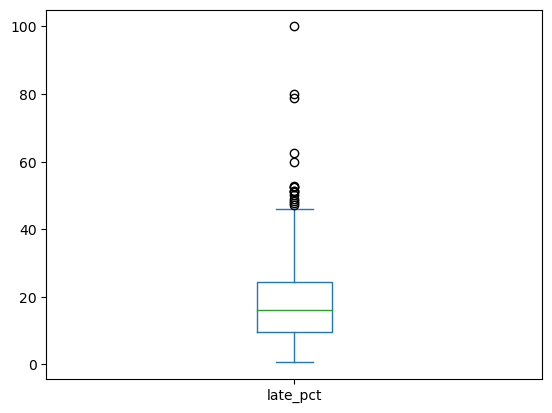

In [12]:
op_df.late_pct.plot.box()

In [13]:
op_df.loc[op_df['late_pct'] == 1.0]

,OPERATOR,count_x,count_y,late_pct


In [14]:
wego.loc[wego['OPERATOR'] == 656]

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PCT
212311,120230907,1,100532217,9/7/2023,22,2210,656,350215,1,FROM DOWNTOWN,...,-15.0,0,1,0,0,1.0,0,139,2.466666,-100.0


In [15]:
len(
late_stops.loc[late_stops['HDWY_DEV_PCT'].between(-50,50)])/len(
late_stops)

0.45770520681594906

In [16]:
len(
late_stops.loc[late_stops['HDWY_DEV_PCT'].isna()])/len(
late_stops)

0.2237033774856872

In [17]:
len(
late_stops.loc[late_stops['HDWY_DEV_PCT'] > 50])/len(
late_stops)

0.23578034486263086

In [18]:
len(
late_stops.loc[late_stops['HDWY_DEV_PCT'] < -50])/len(
late_stops)

0.08281107083573291

In [19]:
midnite_trips = list(wego.loc[wego['SCHEDULED_TIME'].str.contains(r'24:\d\d:\d\d') | wego['SCHEDULED_TIME'].str.contains(r'25:\d\d:\d\d')]['TRIP_ID'].unique())

In [20]:
#remove midnight trips

wego = wego.loc[~wego['TRIP_ID'].isin(midnite_trips)]
wego.shape

(343197, 31)

In [21]:
#create the DATE TRIP ID
#create the LOCATION COUNT (counts the stops in a trip)

wego['DATE_TRIP'] = wego['CALENDAR_ID'].astype(str) + wego['TRIP_ID'].astype(str)
wego['LOCATION_COUNT'] = wego.groupby('DATE_TRIP')['DATE_TRIP'].cumcount()+1

In [22]:
bad_trip = ['120230926353036']
##dropping a DATE TRIP that seems to be broken

wego = wego.loc[~wego['DATE_TRIP'].isin(bad_trip)]
wego.shape

(343176, 33)

In [23]:
len(list(wego.loc[wego['ACTUAL_DEPARTURE_TIME'].isna()]['DATE_TRIP'].unique()))

4301

In [24]:
#list of date trip id where actual departure is missing
no_trip = list(wego.loc[wego['ACTUAL_DEPARTURE_TIME'].isna()]['DATE_TRIP'].unique())

In [25]:
wego.loc[~wego['DATE_TRIP'].isin(no_trip)]

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PCT,DATE_TRIP,LOCATION_COUNT
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,0.0,0,2,6.500000,NaN,120230801345104,1
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,0.0,0,9,0.000000,NaN,120230801345104,2
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,0.0,0,19,0.000000,NaN,120230801345104,3
3,120230801,1,99457893,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,NaN,0,35,0.000000,NaN,120230801345104,4
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,0,1,0,0.0,0,36,12.866666,NaN,120230801345105,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,1,0,0,0.0,0,539,0.000000,17.555553,120230930353448,2
350324,120230930,2,100406611,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,1,0,0,NaN,0,551,0.000000,NaN,120230930353448,3
350325,120230930,2,100406612,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,0,1,0,0.0,0,552,0.000000,6.222220,120230930353449,1
350326,120230930,2,100406613,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,1,0,0,0.0,0,563,0.000000,58.333333,120230930353449,2


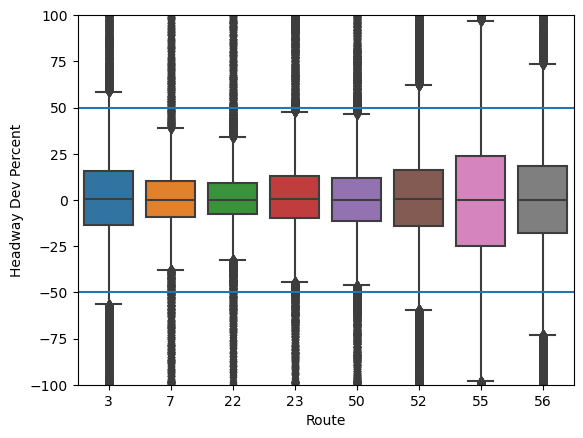

In [26]:
ax = sns.boxplot(data = wego, x = 'ROUTE_ABBR', y = 'HDWY_DEV_PCT')

ax.set_ylim([-100,100])
#ax.set_xlim([0,7])
#plt.xlim([1,7])
plt.xlabel('Route')
plt.ylabel('Headway Dev Percent')
ax.axhline(-50)
ax.axhline(50)

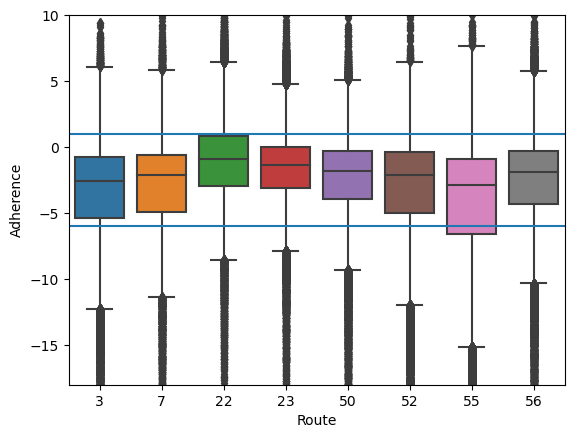

In [31]:
ax = sns.boxplot(data = wego, x = 'ROUTE_ABBR', y = 'ADHERENCE')

ax.set_ylim([-18,10])
#ax.set_xlim([0,7])
#plt.xlim([1,7])
plt.xlabel('Route')
plt.ylabel('Adherence')
ax.axhline(1)
ax.axhline(-6)

In [28]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS', 'HDWY_DEV_PCT', 'DATE_TRIP', 'LOCATION_COUNT'],
      dtype='object')

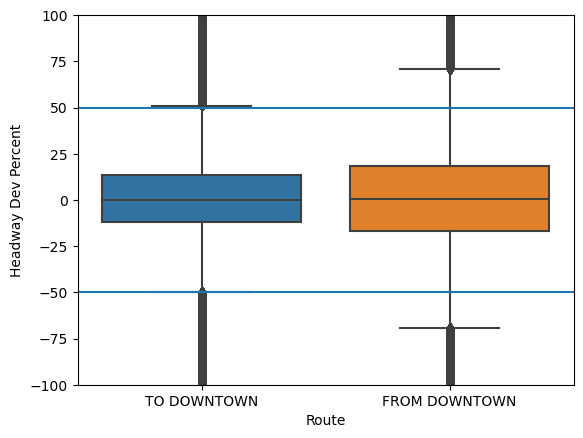

In [29]:
ax = sns.boxplot(data = wego, x = 'ROUTE_DIRECTION_NAME', y = 'HDWY_DEV_PCT')

ax.set_ylim([-100,100])
#ax.set_xlim([0,7])
#plt.xlim([1,7])
plt.xlabel('Route')
plt.ylabel('Headway Dev Percent')
ax.axhline(-50)
ax.axhline(50)

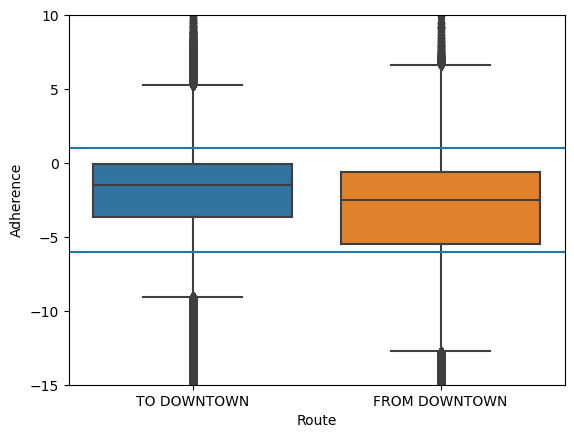

In [32]:
ax = sns.boxplot(data = wego, x = 'ROUTE_DIRECTION_NAME', y = 'ADHERENCE')

ax.set_ylim([-15,10])
#ax.set_xlim([0,7])
#plt.xlim([1,7])
plt.xlabel('Route')
plt.ylabel('Adherence')
ax.axhline(-6)
ax.axhline(1)

Text(0, 0.5, 'Late Percent')

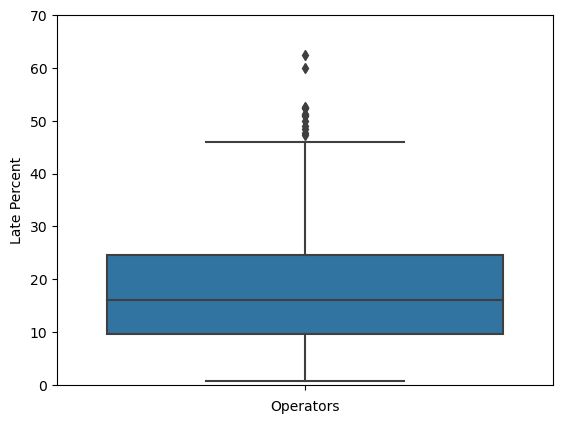

In [185]:
ax = sns.boxplot(data = op_df, 
                 #x = 'ROUTE_DIRECTION_NAME', 
                 y = 'late_pct')

ax.set_ylim([0,70])
#ax.set_xlim([0,7])
#plt.xlim([1,7])
plt.xlabel('Operators')
plt.ylabel('Late Percent')

In [188]:
op_df.late_pct.describe()

count    332.000000
mean      19.126021
std       13.887537
min        0.610902
25%        9.659257
50%       16.123859
75%       24.489440
max      100.000000
Name: late_pct, dtype: float64

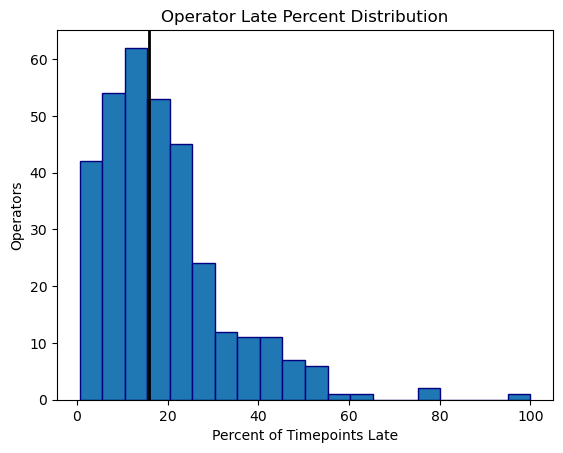

In [193]:
ax = op_df['late_pct'].plot.hist(edgecolor = 'navy', bins = 20, 
                                 xlabel = 'Percent of Timepoints Late',
                                ylabel = 'Operators')
ax.axvline(16, color = 'black', lw = 2)
plt.title('Operator Late Percent Distribution')
plt.show();
#vertical line marks the median operator with 16% of timepoints late

In [36]:
op_mean_ad = wego.groupby(by = 'OPERATOR')['ADHERENCE'].mean().reset_index()
op_mean_ad

,OPERATOR,ADHERENCE
0,0,8.916666
1,56,-1.138889
2,235,-3.947222
3,244,-3.466666
4,301,-4.971171
...,...,...
336,3149,-0.993939
337,3156,-4.700336
338,3165,-7.501562
339,3166,-2.473333


In [100]:
op_mean_ad['ADHERENCE'].sort_values()

18    -22.066666
223   -18.140710
294   -14.233333
319   -11.761308
126   -10.621190
         ...    
88      1.124510
107     1.170133
106     1.297954
253     2.395238
0       8.916666
Name: ADHERENCE, Length: 341, dtype: float64

Text(0.5, 1.0, 'Operator Average Adherence Distribution')

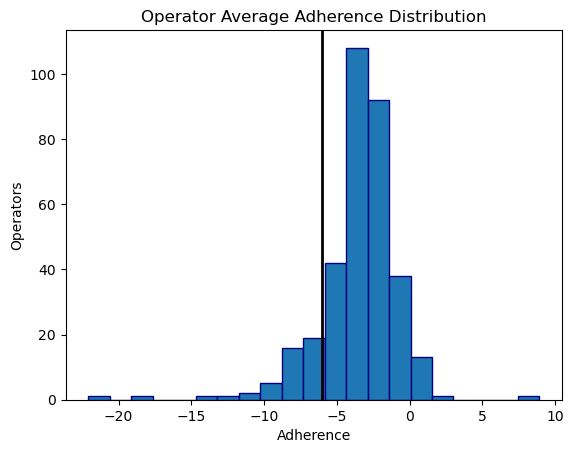

In [153]:
ax = op_mean_ad.ADHERENCE.plot.hist(edgecolor = 'navy',
                               bins = 21,
                               xlabel = 'Adherence', 
                               ylabel= 'Operators')
ax.axvline(-6, color = 'black', lw = 2)
plt.title('Operator Average Adherence Distribution')

In [69]:
op_mean_hd_devpct = wego.groupby(by = 'OPERATOR')['HDWY_DEV_PCT'].mean().reset_index()
op_mean_hd_devpct

,OPERATOR,HDWY_DEV_PCT
0,0,NaN
1,56,-2.500005
2,235,19.020060
3,244,-0.209850
4,301,28.322219
...,...,...
336,3149,9.756061
337,3156,4.491720
338,3165,46.278932
339,3166,-21.522992


In [80]:
op_mean_hd_devpct = op_mean_hd_devpct.dropna().reset_index()
op_mean_hd_devpct

,index,OPERATOR,HDWY_DEV_PCT
0,1,56,-2.500005
1,2,235,19.020060
2,3,244,-0.209850
3,4,301,28.322219
4,5,304,10.539359
...,...,...,...
299,336,3149,9.756061
300,337,3156,4.491720
301,338,3165,46.278932
302,339,3166,-21.522992


In [81]:
op_mean_hd_devpct.loc[op_mean_hd_devpct['HDWY_DEV_PCT'] == np.inf]

,index,OPERATOR,HDWY_DEV_PCT
75,85,1598,inf


In [87]:
op_mean_hd_devpct = op_mean_hd_devpct.drop(75)

In [96]:
op_mean_hd_devpct = op_mean_hd_devpct.drop(24)

In [97]:
op_mean_hd_devpct.HDWY_DEV_PCT.sort_values()

169   -39.503529
158   -28.500005
78    -23.186509
292   -22.979170
302   -21.522992
         ...    
116    48.562666
238    48.985214
269    58.717042
293    62.232802
161    68.506810
Name: HDWY_DEV_PCT, Length: 302, dtype: float64

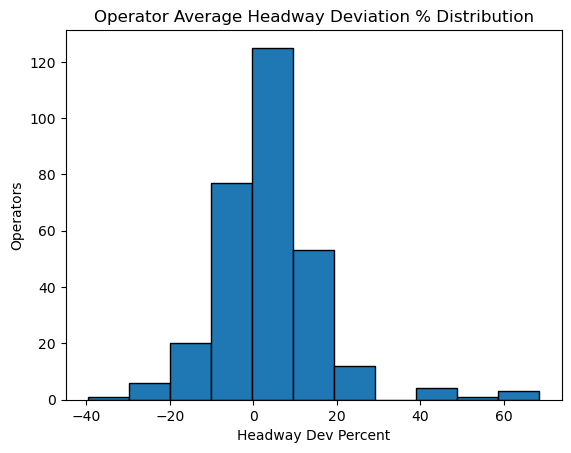

In [112]:
ax = op_mean_hd_devpct.HDWY_DEV_PCT.plot.hist(edgecolor = 'black',
                                              bins =11,
                                         xlabel = 'Headway Dev Percent', 
                                         ylabel= 'Operators')
#ax.set_xlim([-80,80])
plt.title('Operator Average Headway Deviation % Distribution')
plt.show()

In [117]:
late_op = list(op_mean_ad.loc[op_mean_ad['ADHERENCE'] < -6]['OPERATOR'])

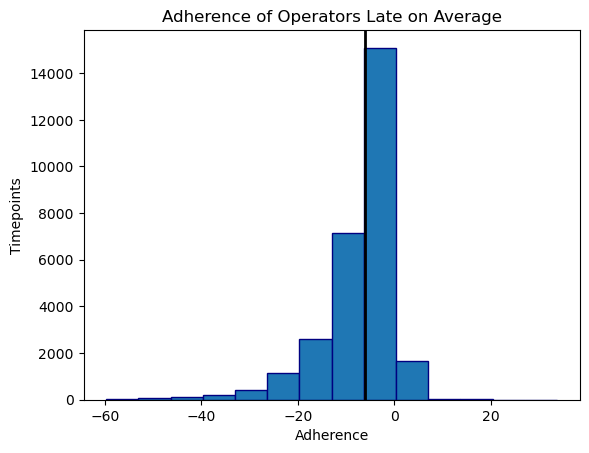

In [194]:
ax = wego.loc[wego['OPERATOR'].isin(late_op)].loc[wego['ADHERENCE']>-60]['ADHERENCE'].plot.hist(
edgecolor = 'navy',
bins = 14,
xlabel = 'Adherence',
ylabel = 'Timepoints')
ax.axvline(-6, color = 'black', lw = 2)
plt.title('Adherence of Operators Late on Average')
plt.show()

In [125]:
wego.loc[wego['OPERATOR'].isin(late_op)]['ADHERENCE'].sort_values().reset_index().head(20)

,index,ADHERENCE
0,30377,-542.233333
1,229459,-539.933333
2,106535,-489.316666
3,133942,-480.900000
4,326619,-480.866666
5,269888,-400.533333
6,120932,-379.550000
7,333129,-166.566666
8,209472,-149.816666
9,209473,-144.333333


In [161]:
late_route = (wego.loc[wego['ADHERENCE'] < -6])[['ROUTE_ABBR', 'ADHERENCE']]
late_route = late_route['ROUTE_ABBR'].value_counts().reset_index()
late_route

,ROUTE_ABBR,count
0,55,16513
1,52,9736
2,3,9407
3,56,8681
4,50,5029
5,7,3356
6,23,3144
7,22,1982


In [163]:
route_count = wego['ROUTE_ABBR'].value_counts().reset_index()
route_count

,ROUTE_ABBR,count
0,55,60942
1,56,59004
2,52,50383
3,3,46278
4,50,42349
5,23,41172
6,22,25334
7,7,17714


In [166]:
route_late_percent = pd.merge(route_count, late_route, on = 'ROUTE_ABBR')
route_late_percent['late_pct'] = route_late_percent['count_y'] / route_late_percent['count_x'] * 100
route_late_percent

,ROUTE_ABBR,count_x,count_y,late_pct
0,55,60942,16513,27.096255
1,56,59004,8681,14.712562
2,52,50383,9736,19.323978
3,3,46278,9407,20.327153
4,50,42349,5029,11.875133
5,23,41172,3144,7.636258
6,22,25334,1982,7.823478
7,7,17714,3356,18.945467


In [182]:
route_late_percent.late_pct.sum()

127.74028460080063

<Axes: xlabel='ROUTE_ABBR', ylabel='Percent of Timepoints Late'>

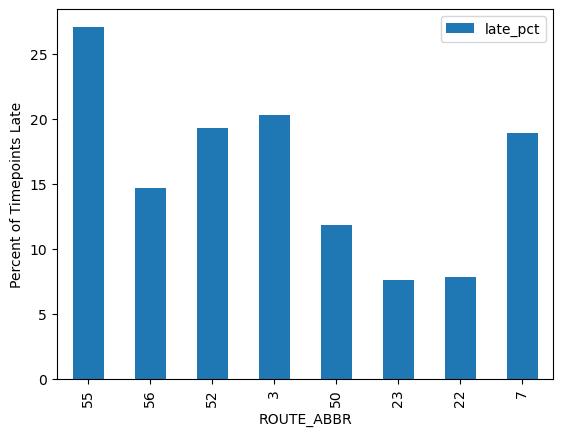

In [195]:
route_late_percent.plot.bar(x = 'ROUTE_ABBR', y = 'late_pct', ylabel = 'Percent of Timepoints Late')

In [168]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS', 'HDWY_DEV_PCT', 'DATE_TRIP', 'LOCATION_COUNT'],
      dtype='object')

In [170]:
gap_route = (wego.loc[wego['HDWY_DEV_PCT'] > 50])[['ROUTE_ABBR', 'HDWY_DEV_PCT']]
gap_route = gap_route['ROUTE_ABBR'].value_counts().reset_index()
gap_route

,ROUTE_ABBR,count
0,55,6461
1,56,4003
2,52,3750
3,3,2873
4,23,1925
5,50,1400
6,22,700
7,7,612


In [171]:
route_gap_percent = pd.merge(route_count, gap_route, on = 'ROUTE_ABBR')
route_gap_percent['gap_pct'] = route_late_percent['count_y'] / route_late_percent['count_x'] * 100
route_gap_percent

,ROUTE_ABBR,count_x,count_y,gap_pct
0,55,60942,6461,27.096255
1,56,59004,4003,14.712562
2,52,50383,3750,19.323978
3,3,46278,2873,20.327153
4,50,42349,1400,11.875133
5,23,41172,1925,7.636258
6,22,25334,700,7.823478
7,7,17714,612,18.945467


<Axes: xlabel='ROUTE_ABBR', ylabel='Percent of Timepoints with Gap'>

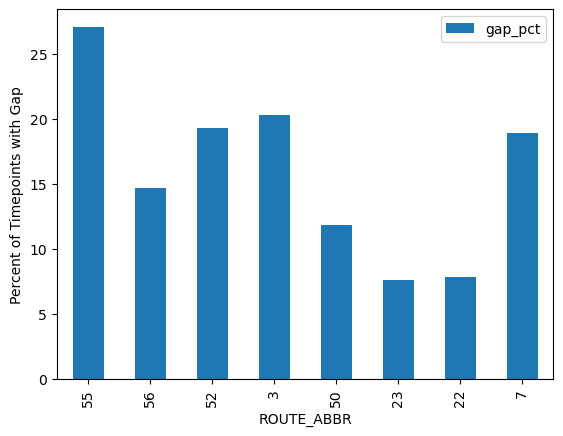

In [196]:
route_gap_percent.plot.bar(x = 'ROUTE_ABBR', y = 'gap_pct', ylabel = 'Percent of Timepoints with Gap')

In [177]:
dir_count = wego.ROUTE_DIRECTION_NAME.value_counts().reset_index()
dir_count

,ROUTE_DIRECTION_NAME,count
0,FROM DOWNTOWN,180570
1,TO DOWNTOWN,162606


In [176]:
late_dir = (wego.loc[wego['ADHERENCE'] < -6])[['ROUTE_DIRECTION_NAME', 'ADHERENCE']]
late_dir = late_dir['ROUTE_DIRECTION_NAME'].value_counts().reset_index()
late_dir

,ROUTE_DIRECTION_NAME,count
0,FROM DOWNTOWN,38588
1,TO DOWNTOWN,19260


In [198]:
dir_late_pct = pd.merge(dir_count, late_dir, on = 'ROUTE_DIRECTION_NAME')
dir_late_pct['late_pct'] = dir_late_pct['count_y'] / dir_late_pct['count_x'] * 100
dir_late_pct

,ROUTE_DIRECTION_NAME,count_x,count_y,late_pct
0,FROM DOWNTOWN,180570,38588,21.370106
1,TO DOWNTOWN,162606,19260,11.844581


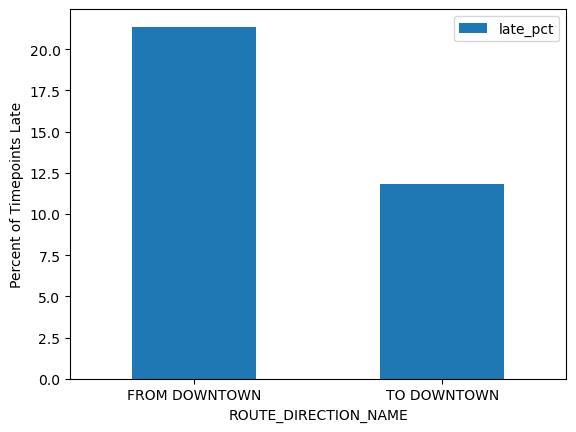

In [199]:
dir_late_pct.plot.bar(x = 'ROUTE_DIRECTION_NAME', y = 'late_pct', ylabel = 'Percent of Timepoints Late')
plt.xticks(rotation = 0)
plt.show()

In [183]:
op_df

,OPERATOR,count_x,count_y,late_pct
0,2109,936,2142,43.697479
1,1800,810,1675,48.358209
2,1204,767,2128,36.043233
3,3064,750,1972,38.032454
4,1352,728,1727,42.154024
...,...,...,...,...
327,473,1,2,50.000000
328,2472,1,38,2.631579
329,2313,1,10,10.000000
330,2377,1,10,10.000000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### Read in file

In [ ]:
wego = pd.read_csv("../data/Headway Data, 8-1-2023 to 9-30-2023.csv")

wego.head()

### 3. How does time of day or day of week affect headway and on-time performance?

##### Rename column headers to all lowercase.

In [ ]:
wego= wego.rename(columns=str.lower)
wego.head(20)

##### Change date column to datetime object

In [ ]:
wego['date'] = pd.to_datetime(wego['date'])

##### Add day name column to df

In [ ]:
wego['day'] = wego['date'].dt.day_name()
print(wego)

##### Create df that contains needed columns

In [ ]:
wego_day = (
    wego
    [[
        'date', 'calendar_id', 'trip_id', 'route_abbr',
        'time_point_abbr', 'trip_edge',
        'scheduled_time', 'actual_departure_time', 'adherence',
        'adjusted_early_count', 'adjusted_late_count', 'adjusted_ontime_count', 'day'
    ]]
)

wego_day

##### Group by day column and sum early, late, and ontime counts per day, then create new df

In [ ]:
wegog = wego_day.groupby('day')
wegog_columns = wegog[['adjusted_early_count', 'adjusted_late_count', 'adjusted_ontime_count']]
wegodays = wegog_columns.sum()

##### Reset index on new df

In [ ]:
wegodays = wegodays.reset_index()
wegodays

##### Rename columns

In [ ]:
wegodays = wegodays.rename(columns={'adjusted_early_count' : 'early', 'adjusted_late_count' : 'late', 'adjusted_ontime_count' :'ontime'  })
wegodays

##### Create total count column by summing early, late and ontime column for each day

In [ ]:
wegodays['count'] = wegodays['early'] + wegodays['late'] + wegodays['ontime']
wegodays

##### Create on-time percentage column by dividing the ontime count for each day into the total count for each day

In [ ]:
wegodays['ontime_per'] = wegodays['ontime']/wegodays['count'] * 100
wegodays

##### Extract only columns needed

In [ ]:
wegodays = wegodays[['day', 'ontime_per']]
wegodays

##### Create day order and reset index so Monday is first day

In [ ]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [ ]:
wegodays = wegodays.set_index('day').loc[day_order].reset_index()
wegodays

##### Plot on-time percentage by day on plt.barchart

In [ ]:
wegodays.plot.bar(x = 'day', y = 'ontime_per')
plt.title('On-time Percentage by Day')
plt.xlabel('Day')
plt.ylabel('On-time Percentage')
plt.xticks(rotation = 45, ha = 'right');

### 3a Answer.  As the week increases, the on-time percentages decreases. Saturday and Sunday have less bus routes during the week and traffic is lighter, leading to a higher on-time percentage than the week.

##### Create df with day and hdwy_dev

In [ ]:
wegohd = wego[['hdwy_dev','day']]

wegohd

##### Fill Nan values with 123456 to get value count on them

In [ ]:
wegohd['hdwy_dev'] = wegohd['hdwy_dev'].fillna(123456)
wegohd

In [ ]:
wegohd['hdwy_dev'].value_counts()

##### 84,436 hdwy_dev values with NaN value. 

##### Create df that does not include the 123456 value.

In [ ]:
wegohd = wegohd.loc[(wegohd.hdwy_dev != 123456.000000)]
wegohd

##### Group by day column, find the mean hdwy_dev for each and create new avg hdwy df.

In [ ]:
wegog = wegohd.groupby('day')
wegog_columns = wegog[['hdwy_dev']]
wegohdt = wegog_columns.mean()

In [ ]:
wegohdt

##### Reset index on new df

In [ ]:
wegohdt = wegohdt.reset_index()
wegohdt

##### Reorder days in new dataframe

In [ ]:
wegohdt = wegohdt.set_index('day').loc[day_order].reset_index()
wegohdt

##### Plot hdwy_dev mean per day to see any trends

In [ ]:
wegohdt.plot.bar(x = 'day', y = 'hdwy_dev')
plt.title('Average Headway Deviation by Day')
plt.xlabel('Day')
plt.ylabel('Average Headway Deviation')
plt.xticks(rotation = 45, ha = 'right');

### Find average hdwy_dev percent

In [ ]:
wegohdt_per = (
    wego
    [[
        'date','day', 'hdwy_dev','scheduled_hdwy'
    ]]
)

wegohdt_per

In [ ]:
wegohdt_per['hdwy_dev'] = wegohdt_per['hdwy_dev'].fillna(123456)
wegohdt_per

In [ ]:
wegohdt_per['scheduled_hdwy'] = wegohdt_per['scheduled_hdwy'].fillna(123456)
wegohdt_per

In [ ]:
wegohdt_per = wegohdt_per.loc[(wegohdt_per.hdwy_dev != 123456.000000)]
wegohdt_per

In [ ]:
wegohdt_per = wegohdt_per.loc[(wegohdt_per.scheduled_hdwy != 123456.000000)]
wegohdt_per

In [ ]:
wegohdt_per.loc[(wegohdt_per.scheduled_hdwy == 0)]

In [ ]:
wegohdt_per = wegohdt_per.loc[(wegohdt_per.scheduled_hdwy != 0)]
wegohdt_per

In [ ]:
wegohdt_per = wegohdt_per.loc[(wegohdt_per.hdwy_dev != 0)]
wegohdt_per

In [ ]:
wegohdt_per['hdwy_dev_per'] = wegohdt_per['hdwy_dev']/wegohdt_per['scheduled_hdwy'] * 100
wegohdt_per

In [ ]:
wegog = wegohdt_per.groupby('day')
wegog_columns = wegog[['hdwy_dev_per']]
wegohdt_pert = wegog_columns.mean()
wegohdt_pert

In [ ]:
wegohdt_per

In [ ]:
wegohdt_pert = wegohdt_pert.reset_index()
wegohdt_pert

In [ ]:
wegohdt_pert = wegohdt_pert.set_index('day').loc[day_order]
wegohdt_pert

In [ ]:
wegohdt_pert = wegohdt_pert.reset_index()
wegohdt_pert

In [ ]:
wegohdt_pert.plot.bar(x = 'day', y = 'hdwy_dev_per')
plt.title('Average Headway Deviation Percentage by Day')
plt.xlabel('Day')
plt.ylabel('Average Headway Deviation Percentage')
plt.xticks(rotation = 45, ha = 'right');

In [ ]:
ax = sns.boxplot(data = wegohdt_per, x = 'day', y = 'hdwy_dev_per')
ax.set_ylim([-150,150])

#ax.set_xlim([0,7])
plt.xlabel('Day')
plt.ylabel('Headway Dev Percent')

# These can draw a horizontal line on 50 percent
ax.axhline(50)
ax.axhline(-50)

plt.show()



In [ ]:
day_to_num = {
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
wegohdt_per['day_num'] = wegohdt_per['day'].map(day_to_num)
wegohdt_per = wegohdt_per.sort_values(by='day_num')
wegohdt_per

In [ ]:
ax = sns.boxplot(data = wegohdt_per, x = 'day', y = 'hdwy_dev_per')
ax.set_ylim([-150,150])
plt.title('Average Headway Deviation Percentage by Day')
#ax.set_xlim([0,7])
plt.xlabel('Day')
plt.ylabel('Headway Dev Percent')
plt.xticks(rotation = 45, ha = 'right');
# These can draw a horizontal line on 50 percent
ax.axhline(50)
ax.axhline(-50)

plt.show()

### 3b Answer. Headway is greatly affected by the day of the week. Starting on Monday, the headway deviation percentage varies more as the week progresses. 

Goals of this project:
1. What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?
2. How does direction of travel, route, or location affect the headway and on-time performance?
3. How does time of day or day of week affect headway and on-time performance?
4. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.
5. Is there any relationship between lateness (ADHERENCE) and headway deviation?
6. How much impact does being late or too spaced out at the first stop have downstream?
7. What is the impact of the layover at the start of the trip (the difference between the first stop arrival and departure time)? Does more layover lead to more stable headways (lower values for % headway deviation)?
8. What is the relationship between distance or time travelled since the start of a given trip and the headway deviation? Does headway become less stable the further along the route the bus has travelled?

## First Goal:
## 5. Is there any relationship between lateness (ADHERENCE) and headway deviation?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
wego = pd.read_csv("../data/headway_data.csv")

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.500000
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,9,0.000000
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,19,0.000000
3,120230801,1,99457893,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,35,0.000000
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,36,12.866666


In [3]:
list(wego.columns)

['CALENDAR_ID',
 'SERVICE_ABBR',
 'ADHERENCE_ID',
 'DATE',
 'ROUTE_ABBR',
 'BLOCK_ABBR',
 'OPERATOR',
 'TRIP_ID',
 'OVERLOAD_ID',
 'ROUTE_DIRECTION_NAME',
 'TIME_POINT_ABBR',
 'ROUTE_STOP_SEQUENCE',
 'TRIP_EDGE',
 'LATITUDE',
 'LONGITUDE',
 'SCHEDULED_TIME',
 'ACTUAL_ARRIVAL_TIME',
 'ACTUAL_DEPARTURE_TIME',
 'ADHERENCE',
 'SCHEDULED_HDWY',
 'ACTUAL_HDWY',
 'HDWY_DEV',
 'ADJUSTED_EARLY_COUNT',
 'ADJUSTED_LATE_COUNT',
 'ADJUSTED_ONTIME_COUNT',
 'STOP_CANCELLED',
 'PREV_SCHED_STOP_CANCELLED',
 'IS_RELIEF',
 'BLOCK_STOP_ORDER',
 'DWELL_IN_MINS']

In [4]:
wego[['SCHEDULED_HDWY','ACTUAL_HDWY','HDWY_DEV']]

,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
350323,30.0,35.266666,5.266666
350324,NaN,NaN,NaN
350325,30.0,31.866666,1.866666
350326,30.0,47.500000,17.500000


In [5]:
wego['SCHEDULED_HDWY']/2

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
350323    15.0
350324     NaN
350325    15.0
350326    15.0
350327     NaN
Name: SCHEDULED_HDWY, Length: 350328, dtype: float64

In [6]:
new_list = []


In [8]:
def headway_flag(dev, sch):
    if dev == 'nan':
        return 0
    elif sch == 'nan':
        return 0
    elif abs(dev) > (sch/2):
        return 1
    else:
        return 0

In [9]:
wegotest = wego[:100][['SCHEDULED_HDWY','HDWY_DEV']]
wegotest

,SCHEDULED_HDWY,HDWY_DEV
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
95,30.0,6.800000
96,NaN,NaN
97,68.0,-7.466667
98,33.0,2.750000


In [10]:
wegotest['SCHEDULED_HDWY'].dtype

dtype('float64')

In [11]:
#df = df.assign(Product=lambda x: (x['Field_1'] * x['Field_2'] * x['Field_3'])
wegotest = wegotest.assign(bad_hdway=lambda x: (x['HDWY_DEV'] - x['SCHEDULED_HDWY']))

In [12]:
wegotest

,SCHEDULED_HDWY,HDWY_DEV,bad_hdway
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
95,30.0,6.800000,-23.200000
96,NaN,NaN,NaN
97,68.0,-7.466667,-75.466667
98,33.0,2.750000,-30.250000


In [13]:
wegotest = wegotest.assign(hdwy_bad=lambda x: ( (x['SCHEDULED_HDWY'])/2) - (abs(x['HDWY_DEV'])))

In [14]:
wegotest

,SCHEDULED_HDWY,HDWY_DEV,bad_hdway,hdwy_bad
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
95,30.0,6.800000,-23.200000,8.200000
96,NaN,NaN,NaN,NaN
97,68.0,-7.466667,-75.466667,26.533333
98,33.0,2.750000,-30.250000,13.750000


In [15]:
wegotest.dtypes

SCHEDULED_HDWY    float64
HDWY_DEV          float64
bad_hdway         float64
hdwy_bad          float64
dtype: object

In [16]:
abs(-20.0)

20.0

In [17]:
type(wegotest.iloc[0][0])

numpy.float64

In [18]:
type(np.NaN)


float

In [19]:
print(wegotest.iloc[0][0])

nan


In [20]:
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.500000
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,9,0.000000
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,19,0.000000
3,120230801,1,99457893,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,35,0.000000
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,36,12.866666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,35.266666,5.266666,0,1,0,0,0.0,0,539,0.000000
350324,120230930,2,100406611,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,NaN,NaN,0,1,0,0,NaN,0,551,0.000000
350325,120230930,2,100406612,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,31.866666,1.866666,0,0,1,0,0.0,0,552,0.000000
350326,120230930,2,100406613,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,47.500000,17.500000,0,1,0,0,0.0,0,563,0.000000


In [21]:
wego['ADHERENCE']

0         -2.133333
1         -2.450000
2         -0.933333
3          6.283333
4         -1.583333
            ...    
350323    -8.433333
350324   -11.300000
350325    -4.316666
350326   -22.083333
350327   -23.666666
Name: ADHERENCE, Length: 350328, dtype: float64

In [22]:
### Create the HDWY FLAG

wego = wego.assign(HDWY_FLAG=lambda x: ( (x['SCHEDULED_HDWY']) /2) - (abs (x['HDWY_DEV']) ) )

In [23]:
wego.loc[wego['HDWY_FLAG']<0,['SCHEDULED_HDWY','HDWY_DEV','HDWY_FLAG']]

,SCHEDULED_HDWY,HDWY_DEV,HDWY_FLAG
186,12.0,-7.383334,-1.383334
200,12.0,-8.200000,-2.200000
224,45.0,184.833333,-162.333333
225,45.0,182.216666,-159.716666
226,45.0,181.816666,-159.316666
...,...,...,...
350027,20.0,-13.033334,-3.033334
350028,20.0,-13.650000,-3.650000
350050,20.0,10.050000,-0.050000
350242,30.0,31.583333,-16.583333


In [24]:
### From the data: 39,972 have a bad headway (the headway deviation is more than 50% of scheduled headway)

In [25]:
list(wego.columns)

['CALENDAR_ID',
 'SERVICE_ABBR',
 'ADHERENCE_ID',
 'DATE',
 'ROUTE_ABBR',
 'BLOCK_ABBR',
 'OPERATOR',
 'TRIP_ID',
 'OVERLOAD_ID',
 'ROUTE_DIRECTION_NAME',
 'TIME_POINT_ABBR',
 'ROUTE_STOP_SEQUENCE',
 'TRIP_EDGE',
 'LATITUDE',
 'LONGITUDE',
 'SCHEDULED_TIME',
 'ACTUAL_ARRIVAL_TIME',
 'ACTUAL_DEPARTURE_TIME',
 'ADHERENCE',
 'SCHEDULED_HDWY',
 'ACTUAL_HDWY',
 'HDWY_DEV',
 'ADJUSTED_EARLY_COUNT',
 'ADJUSTED_LATE_COUNT',
 'ADJUSTED_ONTIME_COUNT',
 'STOP_CANCELLED',
 'PREV_SCHED_STOP_CANCELLED',
 'IS_RELIEF',
 'BLOCK_STOP_ORDER',
 'DWELL_IN_MINS',
 'HDWY_FLAG']

In [26]:
wego[['ADJUSTED_LATE_COUNT','HDWY_FLAG']].corr()

,ADJUSTED_LATE_COUNT,HDWY_FLAG
ADJUSTED_LATE_COUNT,1.000000,-0.232161
HDWY_FLAG,-0.232161,1.000000


In [27]:
late_bunch = wego.loc[(wego['HDWY_FLAG'].between(-100,100))& (wego['ADHERENCE'].between(-200,90))
                      ,['ADHERENCE','HDWY_FLAG']]

In [28]:
late_bunch.corr()

,ADHERENCE,HDWY_FLAG
ADHERENCE,1.000000,0.281151
HDWY_FLAG,0.281151,1.000000


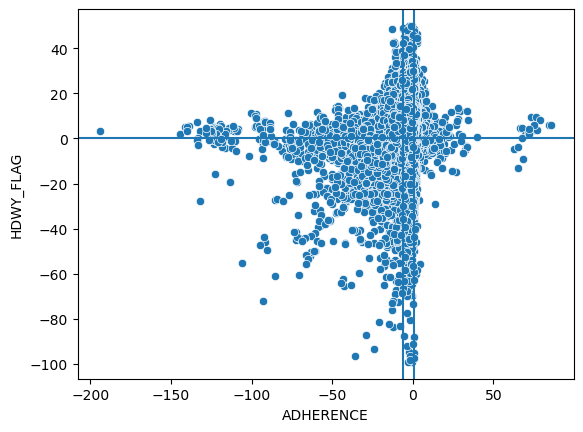

In [29]:
graph = sns.scatterplot(data = late_bunch, x = 'ADHERENCE', y = 'HDWY_FLAG')

graph.axhline(0)

graph.axvline(-6)
graph.axvline(1)

In [30]:
late_bunch

,ADHERENCE,HDWY_FLAG
7,-1.716666,14.833334
8,-1.916666,15.533334
9,-0.183333,7.016666
11,-1.316666,5.333333
12,1.500000,3.616666
...,...,...
350319,-5.900000,8.283334
350322,-8.616666,10.083334
350323,-8.433333,9.733334
350325,-4.316666,13.133334


In [31]:
wego['ADHERENCE'].max()

88.383333

In [32]:
wego = wego.assign(HDWY_DEV_PCT = lambda x: (x['HDWY_DEV']) / (x['SCHEDULED_HDWY']) * 100 )

In [33]:
wego_bad_hd = wego.loc[(wego['HDWY_DEV_PCT'] > 50) | (wego['HDWY_DEV_PCT'] < -50)]
wego_bad_hd[['SCHEDULED_HDWY','ACTUAL_HDWY', 'HDWY_DEV','HDWY_DEV_PCT','HDWY_FLAG']]

,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,HDWY_DEV_PCT,HDWY_FLAG
186,12.0,4.616666,-7.383334,-61.527783,-1.383334
200,12.0,3.800000,-8.200000,-68.333333,-2.200000
224,45.0,229.833333,184.833333,410.740740,-162.333333
225,45.0,227.216666,182.216666,404.925924,-159.716666
226,45.0,226.816666,181.816666,404.037036,-159.316666
...,...,...,...,...,...
350027,20.0,6.966666,-13.033334,-65.166670,-3.033334
350028,20.0,6.350000,-13.650000,-68.250000,-3.650000
350050,20.0,30.050000,10.050000,50.250000,-0.050000
350242,30.0,61.583333,31.583333,105.277777,-16.583333


In [34]:
wego_gap = wego.loc[(wego['HDWY_DEV_PCT'] > 50)]
wego_gap[['ADHERENCE','SCHEDULED_HDWY','ACTUAL_HDWY', 'HDWY_DEV','HDWY_DEV_PCT','HDWY_FLAG']]

,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,HDWY_DEV_PCT,HDWY_FLAG
224,-4.966666,45.0,229.833333,184.833333,410.740740,-162.333333
225,-2.833333,45.0,227.216666,182.216666,404.925924,-159.716666
226,-1.633333,45.0,226.816666,181.816666,404.037036,-159.316666
232,-1.866666,50.0,94.166666,44.166666,88.333332,-19.166666
235,-6.933333,12.0,19.333333,7.333333,61.111108,-1.333333
...,...,...,...,...,...,...
349923,-9.933333,20.0,30.083333,10.083333,50.416665,-0.083333
349927,-10.383333,19.0,29.950000,10.950000,57.631579,-1.450000
350050,-10.583333,20.0,30.050000,10.050000,50.250000,-0.050000
350242,-4.583333,30.0,61.583333,31.583333,105.277777,-16.583333


In [35]:
wego_bunch = wego.loc[(wego['HDWY_DEV_PCT'] < -50)]
wego_bunch[['ADHERENCE','SCHEDULED_HDWY','ACTUAL_HDWY', 'HDWY_DEV','HDWY_DEV_PCT','HDWY_FLAG']]

,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,HDWY_DEV_PCT,HDWY_FLAG
186,1.300000,12.0,4.616666,-7.383334,-61.527783,-1.383334
200,5.216666,12.0,3.800000,-8.200000,-68.333333,-2.200000
464,0.366666,13.0,6.266666,-6.733334,-51.794877,-0.233334
470,0.833333,13.0,5.100000,-7.900000,-60.769231,-1.400000
471,1.033333,13.0,6.016666,-6.983334,-53.717954,-0.483334
...,...,...,...,...,...,...
350022,-3.716666,20.0,8.816666,-11.183334,-55.916670,-1.183334
350023,-3.616666,19.0,8.600000,-10.400000,-54.736842,-0.900000
350026,-0.816666,20.0,9.616666,-10.383334,-51.916670,-0.383334
350027,-0.450000,20.0,6.966666,-13.033334,-65.166670,-3.033334


<Axes: xlabel='ADHERENCE', ylabel='HDWY_DEV_PCT'>

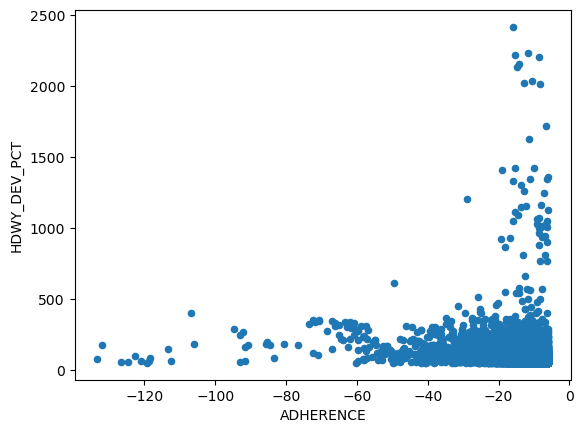

In [36]:
wego_gap.loc[wego_gap['ADHERENCE'].between(-200,-6)][['ADHERENCE', 'HDWY_DEV_PCT']].plot.scatter('ADHERENCE', 'HDWY_DEV_PCT')

<Axes: xlabel='ADHERENCE', ylabel='HDWY_DEV_PCT'>

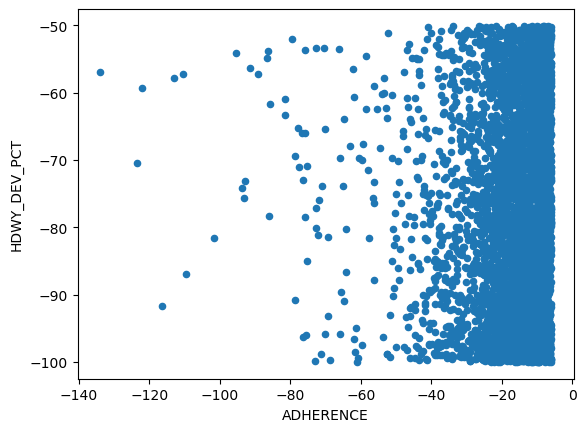

In [37]:
wego_bunch.loc[wego_bunch['ADHERENCE'] < -6][['ADHERENCE', 'HDWY_DEV_PCT']].plot.scatter('ADHERENCE', 'HDWY_DEV_PCT')

In [38]:
wego_gap.loc[wego_gap['ADHERENCE'].between(-200,-6)][['ADHERENCE', 'HDWY_DEV_PCT']].corr()

,ADHERENCE,HDWY_DEV_PCT
ADHERENCE,1.00000,-0.16029
HDWY_DEV_PCT,-0.16029,1.00000


In [39]:
wego_bunch.loc[wego_bunch['ADHERENCE'] < -6][['ADHERENCE', 'HDWY_DEV_PCT']].corr()

,ADHERENCE,HDWY_DEV_PCT
ADHERENCE,1.000000,-0.008536
HDWY_DEV_PCT,-0.008536,1.000000


In [40]:
# How many were bad headway AND late? 5 percent
len(
    wego.loc[(wego['HDWY_FLAG'].between(-100,0))& (wego['ADHERENCE'].between(-200,-6))]
)/len(wego)

0.05393231485921765

In [41]:
# How many of the bunching stops were late? 27 percent
len(
wego_bunch.loc[wego['ADHERENCE'].between(-200,-6)])/len(
wego_bunch)

0.27229290516139787

In [42]:
# How many of the gapping stops were late? 63 percent
len(
wego_gap.loc[wego['ADHERENCE'].between(-200,-6)])/len(
wego_gap)

0.6342329222227279

In [43]:
# Gapping stops divided by late stops
len(
wego.loc[wego['HDWY_DEV_PCT']> 50])/len(
wego.loc[wego['ADHERENCE'].between(-200,-6)])

0.3707396908955929

In [44]:
# Bunching stops divided by late stops
len(
wego.loc[wego['HDWY_DEV_PCT']< -50])/len(
wego.loc[wego['ADHERENCE'].between(-200,-6)])

0.30368833097118175

In [45]:
# Good headway stops divided by late stops
len(
wego.loc[wego['HDWY_DEV_PCT'].between(-50,50)])/len(
wego.loc[wego['ADHERENCE'].between(-200,-6)])

3.811787136397381

In [46]:
# How many stops were late and good headway? 27 thousand
( wego
.loc[wego['ADHERENCE'] < -6]
.loc[wego['HDWY_DEV_PCT'].between(-50,50)]
 [['ADHERENCE','HDWY_DEV_PCT']]
     ).shape

(27022, 2)

In [47]:
( wego
.loc[wego['ADHERENCE'] < -6]
.loc[wego['HDWY_FLAG'] >= 0]
 [['ADHERENCE','HDWY_DEV_PCT']]
     ).shape

(27022, 2)

In [48]:
( wego
.loc[wego['ADHERENCE'] < -6]
.loc[wego['HDWY_FLAG'] < 0]
 [['ADHERENCE','HDWY_DEV_PCT']]
     ).shape

(18809, 2)

In [49]:
len( wego
.loc[wego['ADHERENCE'] < -6]
.loc[wego['HDWY_FLAG'] >= 0])/len(
wego.loc[wego['ADHERENCE'] < -6])

0.45770520681594906

In [50]:
len( wego
.loc[wego['ADHERENCE'] < -6]
.loc[wego['HDWY_FLAG'] < 0])/len(
wego.loc[wego['ADHERENCE'] < -6])

0.31859141569836374

In [51]:
#One extremely late stop that has a good headway ??
#wego.loc[wego['ADHERENCE'] == -675].T

In [52]:
# Describe lateness of gapping stops: IQR of 8 minutes late to 15 minutes late
wego_gap.loc[wego_gap['ADHERENCE'].between(-200,-6)][['ADHERENCE']].describe()

,ADHERENCE
count,13936.000000
mean,-12.791651
std,7.926239
min,-133.250000
25%,-14.850000
50%,-10.750000
75%,-8.183333
max,-6.000000


In [53]:
# Describe lateness of bunching stops: IQR of 9 minutes late to 20 minutes late
wego_bunch.loc[wego_bunch['ADHERENCE'] < -6][['ADHERENCE']].describe()

,ADHERENCE
count,4889.000000
mean,-16.881656
std,11.678895
min,-133.950000
25%,-20.350000
50%,-13.666666
75%,-9.566666
max,-6.016666


In [54]:
# all late stops
late_stops = wego.loc[wego['ADHERENCE'].between(-200,-6)]

In [55]:
# how many late stops are gapping stops? 23 percent
len(
late_stops.loc[late_stops['HDWY_DEV_PCT'] > 50])/len(
late_stops)

0.23513531754066275

In [56]:
# how many late stops are bunching stops? 8 percent
len(
late_stops.loc[late_stops['HDWY_DEV_PCT'] < -50])/len(
late_stops)

0.0826921779037592

In [57]:
late_stops.loc[late_stops['HDWY_DEV_PCT'] < -50][['ADHERENCE','HDWY_DEV_PCT','HDWY_FLAG']]

,ADHERENCE,HDWY_DEV_PCT,HDWY_FLAG
1358,-24.766666,-98.500000,-4.850000
1359,-24.883333,-97.500000,-4.750000
1360,-22.083333,-97.000000,-4.700000
1582,-18.983333,-98.555560,-7.283334
1583,-19.966666,-94.888893,-6.733334
...,...,...,...
348823,-51.150000,-69.666667,-5.900000
349120,-32.716666,-73.277780,-6.983334
349121,-29.683333,-72.944447,-6.883334
349122,-28.600000,-76.611113,-7.983334


In [58]:
len(
late_stops.loc[late_stops['HDWY_DEV_PCT'].between(-50,50)])/len(
late_stops)

0.4589491799959506

In [59]:
.46 + .08 + .23 + .22

0.99

In [60]:
len(
late_stops.loc[late_stops['HDWY_DEV_PCT'].isna()])/len(
late_stops)

0.22322332455962746

## First Goal:
## 5. Is there any relationship between lateness (ADHERENCE) and headway deviation?

Off all late departures: 
    
    46 percent are within the accepted headway range, 
    
    22 percent have no headway data, 
    
    23 percent have have a gap headway more than 50% 
    
    8 percent have a bunch headway of more than 50%

Of all gap headways over 50 percent:

63 were late departures

## Second Goal
## 8. What is the relationship between distance or time travelled since the start of a given trip and the headway deviation? Does headway become less stable the further along the route the bus has travelled?

In [61]:
wego[['DATE','TRIP_ID']]

,DATE,TRIP_ID
0,8/1/2023,345104
1,8/1/2023,345104
2,8/1/2023,345104
3,8/1/2023,345104
4,8/1/2023,345105
...,...,...
350323,9/30/2023,353448
350324,9/30/2023,353448
350325,9/30/2023,353449
350326,9/30/2023,353449


In [62]:
wegotest = wego[['DATE','TRIP_ID']]
wegotest = wegotest.assign(DATE_TRIP = lambda x: (x['DATE']) + "_" + (x['TRIP_ID'].astype(str)))
wegotest

,DATE,TRIP_ID,DATE_TRIP
0,8/1/2023,345104,8/1/2023_345104
1,8/1/2023,345104,8/1/2023_345104
2,8/1/2023,345104,8/1/2023_345104
3,8/1/2023,345104,8/1/2023_345104
4,8/1/2023,345105,8/1/2023_345105
...,...,...,...
350323,9/30/2023,353448,9/30/2023_353448
350324,9/30/2023,353448,9/30/2023_353448
350325,9/30/2023,353449,9/30/2023_353449
350326,9/30/2023,353449,9/30/2023_353449


In [63]:
wegotest.dtypes

DATE         object
TRIP_ID       int64
DATE_TRIP    object
dtype: object

In [64]:
date_trips = list(wegotest['DATE_TRIP'].unique())

In [65]:
len(date_trips)

67370

In [66]:
wego['ROUTE_ABBR'].unique()

array([22, 23,  3,  7, 50, 52, 55, 56], dtype=int64)

In [67]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS', 'HDWY_FLAG', 'HDWY_DEV_PCT'],
      dtype='object')

In [68]:
wego[['TIME_POINT_ABBR','ROUTE_STOP_SEQUENCE']]

,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE
0,MHSP,14.0
1,ELIZ,10.0
2,CV23,5.0
3,MCC5_10,1.0
4,MCC5_10,1.0
...,...,...
350323,21BK,4.0
350324,MCC5_9,3.0
350325,MCC5_9,3.0
350326,21BK,4.0


In [69]:
len(wego['TIME_POINT_ABBR'].unique())

61

In [70]:
len(wego['ROUTE_STOP_SEQUENCE'].unique())

18

In [71]:
wego.iloc[0].T

CALENDAR_ID                    120230801
SERVICE_ABBR                           1
ADHERENCE_ID                    99457890
DATE                            8/1/2023
ROUTE_ABBR                            22
BLOCK_ABBR                          2200
OPERATOR                            1040
TRIP_ID                           345104
OVERLOAD_ID                            0
ROUTE_DIRECTION_NAME         TO DOWNTOWN
TIME_POINT_ABBR                     MHSP
ROUTE_STOP_SEQUENCE                 14.0
TRIP_EDGE                              1
LATITUDE                       36.181248
LONGITUDE                     -86.847705
SCHEDULED_TIME                   4:42:00
ACTUAL_ARRIVAL_TIME              4:37:38
ACTUAL_DEPARTURE_TIME            4:44:08
ADHERENCE                      -2.133333
SCHEDULED_HDWY                       NaN
ACTUAL_HDWY                          NaN
HDWY_DEV                             NaN
ADJUSTED_EARLY_COUNT                   0
ADJUSTED_LATE_COUNT                    0
ADJUSTED_ONTIME_

In [72]:
wegotest = wego.iloc[:100]

In [73]:
wegotest['SCHEDULED_TIME'] = wegotest['DATE'] + " " + wegotest['SCHEDULED_TIME']

C:\Users\dougl\AppData\Local\Temp\ipykernel_360\2748881643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wegotest['SCHEDULED_TIME'] = wegotest['DATE'] + " " + wegotest['SCHEDULED_TIME']


In [74]:
wegotest[['SCHEDULED_TIME']]

,SCHEDULED_TIME
0,8/1/2023 4:42:00
1,8/1/2023 4:46:00
2,8/1/2023 4:54:00
3,8/1/2023 5:10:00
4,8/1/2023 5:15:00
...,...
95,8/1/2023 20:26:00
96,8/1/2023 20:36:00
97,8/1/2023 20:43:00
98,8/1/2023 20:52:00


In [75]:
pd.to_datetime(wegotest['SCHEDULED_TIME'])

0    2023-08-01 04:42:00
1    2023-08-01 04:46:00
2    2023-08-01 04:54:00
3    2023-08-01 05:10:00
4    2023-08-01 05:15:00
             ...        
95   2023-08-01 20:26:00
96   2023-08-01 20:36:00
97   2023-08-01 20:43:00
98   2023-08-01 20:52:00
99   2023-08-01 21:08:00
Name: SCHEDULED_TIME, Length: 100, dtype: datetime64[ns]

In [76]:
wego['SCHEDULED_TIME'] = wego['DATE'] + " " + wegotest['SCHEDULED_TIME']
wego['ACTUAL_ARRIVAL_TIME'] = wego['DATE'] + " " + wegotest['ACTUAL_ARRIVAL_TIME']
wego['ACTUAL_DEPARTURE_TIME'] = wego['DATE'] + " " + wegotest['ACTUAL_DEPARTURE_TIME']
pd.to_datetime(wegotest['SCHEDULED_TIME'])
pd.to_datetime(wegotest['ACTUAL_ARRIVAL_TIME'])
pd.to_datetime(wegotest['ACTUAL_DEPARTURE_TIME'])

C:\Users\dougl\AppData\Local\Temp\ipykernel_360\3672264884.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(wegotest['ACTUAL_ARRIVAL_TIME'])
C:\Users\dougl\AppData\Local\Temp\ipykernel_360\3672264884.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(wegotest['ACTUAL_DEPARTURE_TIME'])


0    2024-04-12 04:44:08
1    2024-04-12 04:48:27
2    2024-04-12 04:54:56
3    2024-04-12 05:03:43
4    2024-04-12 05:16:35
             ...        
95   2024-04-12 20:31:44
96   2024-04-12 20:40:19
97   2024-04-12 20:42:03
98   2024-04-12 20:56:38
99   2024-04-12 21:05:04
Name: ACTUAL_DEPARTURE_TIME, Length: 100, dtype: datetime64[ns]

In [77]:
wego[['SCHEDULED_TIME','ACTUAL_ARRIVAL_TIME','ACTUAL_DEPARTURE_TIME']]

,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME
0,8/1/2023 8/1/2023 4:42:00,8/1/2023 4:37:38,8/1/2023 4:44:08
1,8/1/2023 8/1/2023 4:46:00,8/1/2023 4:48:27,8/1/2023 4:48:27
2,8/1/2023 8/1/2023 4:54:00,8/1/2023 4:54:56,8/1/2023 4:54:56
3,8/1/2023 8/1/2023 5:10:00,8/1/2023 5:03:43,8/1/2023 5:03:43
4,8/1/2023 8/1/2023 5:15:00,8/1/2023 5:03:43,8/1/2023 5:16:35
...,...,...,...
350323,NaN,NaN,NaN
350324,NaN,NaN,NaN
350325,NaN,NaN,NaN
350326,NaN,NaN,NaN


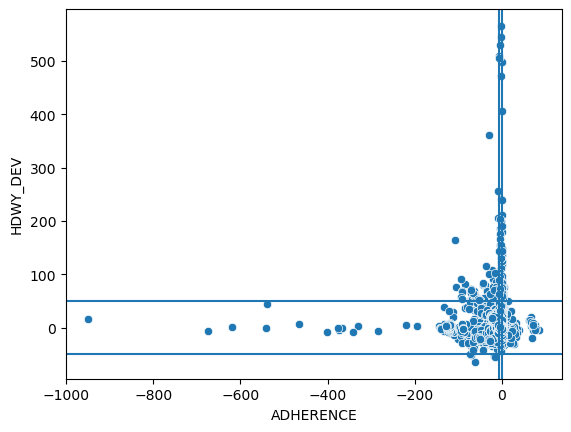

In [78]:
graph = sns.scatterplot(data = wego, x = 'ADHERENCE', y = 'HDWY_DEV')

graph.axhline(-50)
graph.axhline(50)

graph.axvline(-6)
graph.axvline(1)

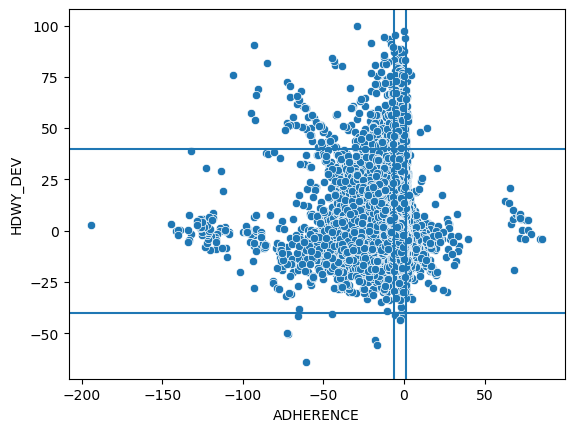

In [79]:
graph = sns.scatterplot(data = wego
                        .loc[wego['ADHERENCE'].between(-200,100)]
                        .loc[wego['HDWY_DEV'].between(-100,100)]
                        , x = 'ADHERENCE', y = 'HDWY_DEV')

graph.axhline(-40)
graph.axhline(40)

graph.axvline(-6)
graph.axvline(1)

In [80]:
wego['SCHEDULED_HDWY'].describe()

count    274737.000000
mean         18.186040
std          12.261828
min           0.000000
25%          10.000000
50%          15.000000
75%          20.000000
max         503.000000
Name: SCHEDULED_HDWY, dtype: float64

<Axes: ylabel='Count'>

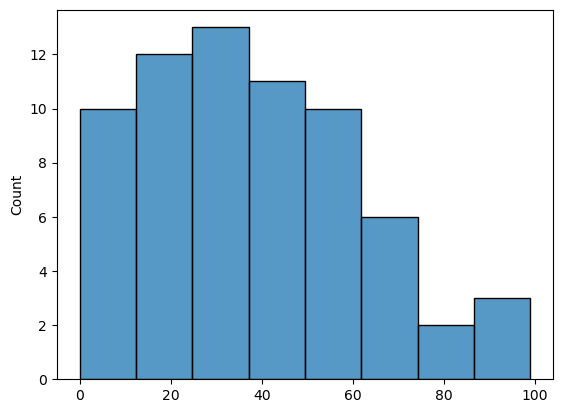

In [81]:
sns.histplot(list(wego.loc[wego['SCHEDULED_HDWY']<100]['SCHEDULED_HDWY'].unique()))

In [82]:
wego.loc[wego['SCHEDULED_HDWY'] == 503][['DATE','SERVICE_ABBR','SCHEDULED_HDWY','ACTUAL_HDWY']]

,DATE,SERVICE_ABBR,SCHEDULED_HDWY,ACTUAL_HDWY
259,8/1/2023,1,503.0,509.333333
6715,8/2/2023,1,503.0,NaN
13165,8/3/2023,1,503.0,508.250000
19637,8/4/2023,1,503.0,NaN
33959,8/7/2023,1,503.0,NaN
40418,8/8/2023,1,503.0,501.616666
46899,8/9/2023,1,503.0,497.500000
53393,8/10/2023,1,503.0,NaN
59901,8/11/2023,1,503.0,501.016666
74271,8/14/2023,1,503.0,505.483333


In [83]:
503/60

8.383333333333333

In [84]:
wego.loc[wego['ADHERENCE'] < -6]

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_FLAG,HDWY_DEV_PCT
69,120230801,1,99457959,8/1/2023,22,2200,2374,345124,0,FROM DOWNTOWN,...,0,1,0,0,NaN,0,656,0.000000,NaN,NaN
78,120230801,1,99457968,8/1/2023,22,2200,2689,345127,0,TO DOWNTOWN,...,0,1,0,0,0.0,0,732,0.000000,1.316667,39.027775
83,120230801,1,99457973,8/1/2023,22,2200,2689,345128,0,FROM DOWNTOWN,...,0,1,0,0,0.0,0,785,0.000000,20.516666,-8.129253
91,120230801,1,99457981,8/1/2023,22,2200,2689,345131,0,TO DOWNTOWN,...,0,1,0,0,0.0,0,851,22.000000,20.833334,8.333332
92,120230801,1,99457982,8/1/2023,22,2200,2689,345131,0,TO DOWNTOWN,...,0,1,0,0,0.0,0,867,0.000000,6.683334,23.266664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350322,120230930,2,100406609,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,0,1,0,0,0.0,0,530,1.966666,10.083334,16.388887
350323,120230930,2,100406610,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,0,1,0,0,0.0,0,539,0.000000,9.733334,17.555553
350324,120230930,2,100406611,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,0,1,0,0,NaN,0,551,0.000000,NaN,NaN
350326,120230930,2,100406613,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,0,1,0,0,0.0,0,563,0.000000,-2.500000,58.333333


In [85]:
wego.loc[wego['HDWY_FLAG'] < -60][['ADHERENCE','SCHEDULED_HDWY','ACTUAL_HDWY', 'HDWY_DEV','HDWY_FLAG']]

,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,HDWY_FLAG
224,-4.966666,45.0,229.833333,184.833333,-162.333333
225,-2.833333,45.0,227.216666,182.216666,-159.716666
226,-1.633333,45.0,226.816666,181.816666,-159.316666
6569,-1.783333,30.0,271.716666,241.716666,-226.716666
6680,-0.666666,45.0,166.616666,121.616666,-99.116666
...,...,...,...,...,...
333238,1.000000,30.0,172.866666,142.866666,-127.866666
336753,-29.350000,25.0,124.800000,99.800000,-87.300000
343284,-14.183333,31.0,108.150000,77.150000,-61.650000
343369,-15.066666,40.0,142.283333,102.283333,-82.283333


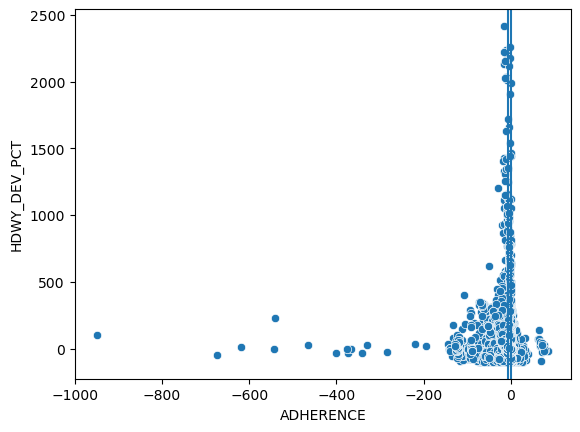

In [87]:
graph = sns.scatterplot(data = wego, x = 'ADHERENCE', y = 'HDWY_DEV_PCT')

#graph.axhline(0)
#graph.xlim([-200,90])
graph.axvline(-6)
graph.axvline(1)

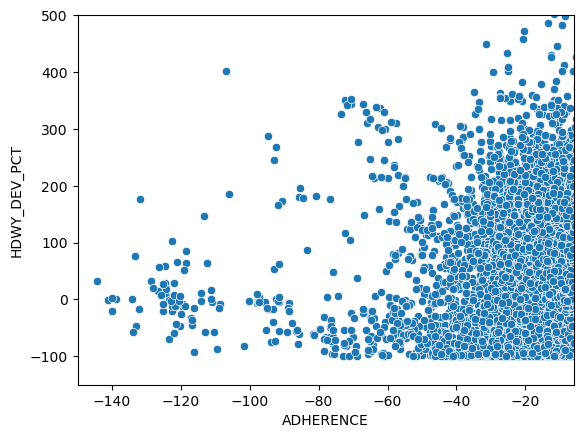

In [88]:
# plot distplot
fig, ax = plt.subplots()
sns.scatterplot(wego, x = 'ADHERENCE', y = 'HDWY_DEV_PCT' , ax = ax)
 
# change the limits of X-axis
ax.set_xlim([-150, -6])
ax.set_ylim([-150,500])
plt.show()

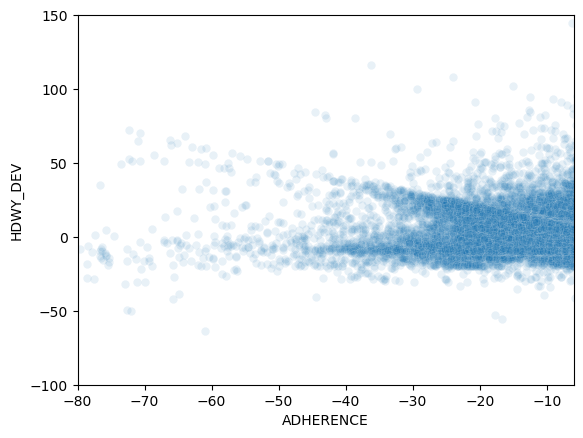

In [89]:
# plot distplot
fig, ax = plt.subplots()
sns.scatterplot(wego, x = 'ADHERENCE', y = 'HDWY_DEV' , ax = ax, alpha = 0.1)
 
# change the limits of X-axis
ax.set_xlim([-80, -6])
ax.set_ylim([-100,150])
plt.show()

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
wego = pd.read_csv('D:/NSS (Data Analyst)/Python/data/Headway Data, 8-1-2023 to 9-30-2023.csv')

In [12]:
wego7 = wego[['CALENDAR_ID','OPERATOR', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR', 'TRIP_ID', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV',
       'DWELL_IN_MINS']]

## 6. How much impact does being late or too spaced out at the first stop have downstream?


In [13]:
wego6 = (
    wego
    [[
        'DATE','OPERATOR', 'ADHERENCE_ID','ROUTE_DIRECTION_NAME', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE', 'ACTUAL_ARRIVAL_TIME',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'HDWY_DEV'
    ]]
)

In [14]:
wego6[['CALENDAR_ID','TRIP_ID', 'OPERATOR']] = wego6[['CALENDAR_ID','TRIP_ID','OPERATOR']].astype(str)
wego6['id'] = wego6['CALENDAR_ID'] + wego6['TRIP_ID'] + wego6['OPERATOR']

C:\Users\Cajun\AppData\Local\Temp\ipykernel_5292\2198194480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego6[['CALENDAR_ID','TRIP_ID', 'OPERATOR']] = wego6[['CALENDAR_ID','TRIP_ID','OPERATOR']].astype(str)
C:\Users\Cajun\AppData\Local\Temp\ipykernel_5292\2198194480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego6['id'] = wego6['CALENDAR_ID'] + wego6['TRIP_ID'] + wego6['OPERATOR']


### First Stops To Downtown 

In [15]:
wego6_firststop = wego6.loc[(wego7['TRIP_EDGE'] == 1) & (wego6['ROUTE_DIRECTION_NAME'] == 'TO DOWNTOWN')]
wego6_firststop['DIFF_ADHERENCE']=wego6_firststop.groupby('id')['ADHERENCE'].diff()
wego6_firststop

C:\Users\Cajun\AppData\Local\Temp\ipykernel_5292\2931598828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego6_firststop['DIFF_ADHERENCE']=wego6_firststop.groupby('id')['ADHERENCE'].diff()


,DATE,OPERATOR,ADHERENCE_ID,ROUTE_DIRECTION_NAME,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,ACTUAL_ARRIVAL_TIME,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,HDWY_DEV,id,DIFF_ADHERENCE
0,8/1/2023,1040,99457890,TO DOWNTOWN,120230801,345104,22,MHSP,1,4:37:38,4:42:00,4:44:08,-2.133333,0,0,1,NaN,1202308013451041040,NaN
7,8/1/2023,1040,99457897,TO DOWNTOWN,120230801,345106,22,MHSP,1,5:30:30,5:42:00,5:43:43,-1.716666,0,0,1,2.666666,1202308013451061040,NaN
14,8/1/2023,1040,99457904,TO DOWNTOWN,120230801,345108,22,MHSP,1,6:30:59,6:42:00,6:43:31,-1.516666,0,0,1,-0.200000,1202308013451081040,NaN
22,8/1/2023,1040,99457912,TO DOWNTOWN,120230801,345110,22,MHSP,1,7:34:00,7:45:00,7:46:15,-1.250000,0,0,1,-0.266667,1202308013451101040,NaN
28,8/1/2023,1040,99457918,TO DOWNTOWN,120230801,345112,22,MHSP,1,8:36:38,8:45:00,8:47:36,-2.600000,0,0,1,1.350000,1202308013451121040,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350298,9/30/2023,2312,100406585,TO DOWNTOWN,120230930,353440,7,HBHS,1,16:54:27,17:06:00,17:08:59,-2.983333,0,0,1,2.400000,1202309303534402312,NaN
350304,9/30/2023,2312,100406591,TO DOWNTOWN,120230930,353442,7,HBHS,1,18:35:37,18:37:00,18:40:03,-3.050000,0,0,1,-0.200000,1202309303534422312,NaN
350310,9/30/2023,2312,100406597,TO DOWNTOWN,120230930,353444,7,HBHS,1,19:51:06,20:11:00,20:12:40,-1.666666,0,0,1,0.433333,1202309303534442312,NaN
350316,9/30/2023,2312,100406603,TO DOWNTOWN,120230930,353446,7,HBHS,1,21:12:40,21:16:00,21:16:51,-0.850000,0,0,1,-1.933334,1202309303534462312,NaN


### Late first stop

In [16]:
#filter for late first stop
wego6_firststop_late = wego6.loc[(wego7['TRIP_EDGE'] == 1) & (wego6['ADHERENCE'] <-6)]

#Filter based on id to find all info on those trips 
wego6_firststop_late = wego6.loc[wego6['id'].isin(wego6_firststop_late['id'])]
wego6_firststop_late = wego6_firststop_late.reset_index(drop= True)
wego6_firststop_late['Stop_#']=wego6_firststop_late.groupby('id')['id'].cumcount()+1
wego6_firststop_late.dropna(subset=['ACTUAL_ARRIVAL_TIME','ACTUAL_DEPARTURE_TIME'])


,DATE,OPERATOR,ADHERENCE_ID,ROUTE_DIRECTION_NAME,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,ACTUAL_ARRIVAL_TIME,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,HDWY_DEV,id,Stop_#
0,8/1/2023,2689,99457981,TO DOWNTOWN,120230801,345131,22,MHSP,1,19:19:31,19:35:00,19:41:31,-6.516666,0,1,0,4.166666,1202308013451312689,1
1,8/1/2023,2689,99457982,TO DOWNTOWN,120230801,345131,22,CV23,0,19:50:44,19:44:00,19:50:44,-6.733333,0,1,0,5.816666,1202308013451312689,2
2,8/1/2023,2689,99457983,TO DOWNTOWN,120230801,345131,22,MCC5_10,2,20:00:11,20:00:00,20:00:11,-0.183333,0,0,1,NaN,1202308013451312689,3
3,8/1/2023,2689,99457984,FROM DOWNTOWN,120230801,345132,22,MCC5_10,1,20:00:11,20:15:00,20:22:05,-7.083333,0,1,0,7.316666,1202308013451322689,1
4,8/1/2023,2689,99457985,FROM DOWNTOWN,120230801,345132,22,CV23,0,20:31:44,20:26:00,20:31:44,-5.733333,0,0,1,6.800000,1202308013451322689,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33447,9/30/2023,2312,100406589,FROM DOWNTOWN,120230930,353441,7,21BK,0,18:19:51,18:01:00,18:19:51,-18.850000,0,1,0,14.500000,1202309303534412312,2
33448,9/30/2023,2312,100406590,FROM DOWNTOWN,120230930,353441,7,HBHS,2,18:35:37,18:17:00,18:35:37,-18.616666,0,1,0,NaN,1202309303534412312,3
33449,9/30/2023,2312,100406609,TO DOWNTOWN,120230930,353448,7,HBHS,1,22:22:39,22:16:00,22:24:37,-8.616666,0,1,0,4.916666,1202309303534482312,1
33450,9/30/2023,2312,100406610,TO DOWNTOWN,120230930,353448,7,21BK,0,22:31:26,22:23:00,22:31:26,-8.433333,0,1,0,5.266666,1202309303534482312,2


### Late First Stop To Downtown

In [17]:
wego6_firststop_late['DIFF_ADHERENCE'] = wego6_firststop_late.groupby('id')['ADHERENCE'].diff()
wego6_firststop_late_to = wego6_firststop_late.loc[wego6_firststop_late['ROUTE_DIRECTION_NAME']=='TO DOWNTOWN']
wego6_firststop_late_to_avg = wego6_firststop_late_to.groupby(['ROUTE_ABBR','Stop_#'])['DIFF_ADHERENCE'].mean().reset_index()
wego6_firststop_late_to_avg = wego6_firststop_late_to.groupby(['Stop_#'])['DIFF_ADHERENCE'].mean().reset_index()
wego6_firststop_late_to_avg

,Stop_#,DIFF_ADHERENCE
0,1,NaN
1,2,0.000579
2,3,-0.080931
3,4,0.693055
4,5,0.242219
5,6,0.766723
6,7,-1.088333


### Late First Stop From Downtown

In [18]:
wego6_firststop_late_from = wego6_firststop_late.loc[wego6_firststop_late['ROUTE_DIRECTION_NAME']=='FROM DOWNTOWN']
wego6_firststop_late_from = wego6_firststop_late_from.groupby(['ROUTE_ABBR','Stop_#'])['DIFF_ADHERENCE'].mean().reset_index()
wego6_firststop_late_from_avg = wego6_firststop_late_from.groupby(['Stop_#'])['DIFF_ADHERENCE'].mean().reset_index()
wego6_firststop_late_from_avg

,Stop_#,DIFF_ADHERENCE
0,1,NaN
1,2,-0.677636
2,3,-0.007874
3,4,0.009642
4,5,-0.353980
5,6,0.052551
6,7,0.968668


### On-Time First Stop

In [19]:
#filter for on-time first stop
wego6_firststop_ontime = (wego6.loc[(wego7['TRIP_EDGE'] == 1) 
                                  & (wego6['ADHERENCE'] >=-6) 
                                  & (wego6['ADHERENCE'] <=1)])

#Filter based on id to find all info on those trips 
wego6_firststop_ontime = wego6.loc[wego6['id'].isin(wego6_firststop_ontime['id'])]
wego6_firststop_ontime = wego6_firststop_ontime.reset_index(drop= True)
wego6_firststop_ontime['Stop_#']=wego6_firststop_ontime.groupby('id')['id'].cumcount()+1
wego6_firststop_ontime.dropna(subset=['ACTUAL_ARRIVAL_TIME','ACTUAL_DEPARTURE_TIME'])

,DATE,OPERATOR,ADHERENCE_ID,ROUTE_DIRECTION_NAME,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,ACTUAL_ARRIVAL_TIME,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,HDWY_DEV,id,Stop_#
0,8/1/2023,1040,99457890,TO DOWNTOWN,120230801,345104,22,MHSP,1,4:37:38,4:42:00,4:44:08,-2.133333,0,0,1,NaN,1202308013451041040,1
1,8/1/2023,1040,99457891,TO DOWNTOWN,120230801,345104,22,ELIZ,0,4:48:27,4:46:00,4:48:27,-2.450000,0,0,1,NaN,1202308013451041040,2
2,8/1/2023,1040,99457892,TO DOWNTOWN,120230801,345104,22,CV23,0,4:54:56,4:54:00,4:54:56,-0.933333,0,0,1,NaN,1202308013451041040,3
3,8/1/2023,1040,99457893,TO DOWNTOWN,120230801,345104,22,MCC5_10,2,5:03:43,5:10:00,5:03:43,6.283333,0,0,1,NaN,1202308013451041040,4
4,8/1/2023,1040,99457894,FROM DOWNTOWN,120230801,345105,22,MCC5_10,1,5:03:43,5:15:00,5:16:35,-1.583333,0,0,1,NaN,1202308013451051040,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299437,9/30/2023,2312,100406606,FROM DOWNTOWN,120230930,353447,7,MCC5_9,1,21:43:52,21:45:00,21:50:54,-5.900000,0,0,1,6.716666,1202309303534472312,1
299439,9/30/2023,2312,100406608,FROM DOWNTOWN,120230930,353447,7,HBHS,2,22:22:39,22:11:00,22:22:39,-11.650000,0,1,0,NaN,1202309303534472312,3
299440,9/30/2023,2312,100406612,FROM DOWNTOWN,120230930,353449,7,MCC5_9,1,22:49:19,22:45:00,22:49:19,-4.316666,0,0,1,1.866666,1202309303534492312,1
299441,9/30/2023,2312,100406613,FROM DOWNTOWN,120230930,353449,7,21BK,0,23:21:05,22:59:00,23:21:05,-22.083333,0,1,0,17.500000,1202309303534492312,2


### On Time First Stop To Downtown 

In [20]:
wego6_firststop_ontime['DIFF_ADHERENCE'] = wego6_firststop_ontime.groupby('id')['ADHERENCE'].diff()
wego6_firststop_ontime_to = wego6_firststop_ontime.loc[wego6_firststop_ontime['ROUTE_DIRECTION_NAME']=='TO DOWNTOWN']
wego6_firststop_ontime_to_avg = wego6_firststop_ontime_to.groupby(['ROUTE_ABBR','Stop_#'])['DIFF_ADHERENCE'].mean().reset_index()
wego6_firststop_ontime_to_avg = wego6_firststop_ontime_to.groupby(['Stop_#'])['DIFF_ADHERENCE'].mean().reset_index()
wego6_firststop_ontime_to_avg

,Stop_#,DIFF_ADHERENCE
0,1,NaN
1,2,-0.242668
2,3,0.059013
3,4,0.827629
4,5,0.840575
5,6,1.415524
6,7,0.735928


### On Time First Stop From Downtown 

In [21]:
wego6_firststop_ontime['DIFF_ADHERENCE'] = wego6_firststop_ontime.groupby('id')['ADHERENCE'].diff()
wego6_firststop_ontime_from = wego6_firststop_ontime.loc[wego6_firststop_ontime['ROUTE_DIRECTION_NAME']=='FROM DOWNTOWN']
wego6_firststop_ontime_from = wego6_firststop_ontime_from.groupby(['ROUTE_ABBR','Stop_#'])['DIFF_ADHERENCE'].mean().reset_index()
wego6_firststop_ontime_from_avg = wego6_firststop_ontime_from.groupby(['Stop_#'])['DIFF_ADHERENCE'].mean().reset_index()
wego6_firststop_ontime_from_avg

,Stop_#,DIFF_ADHERENCE
0,1,NaN
1,2,-0.410395
2,3,0.156966
3,4,0.006198
4,5,-0.688744
5,6,0.124162
6,7,1.153553


### Graphing On-Time vs Late First Stop To Downtown 

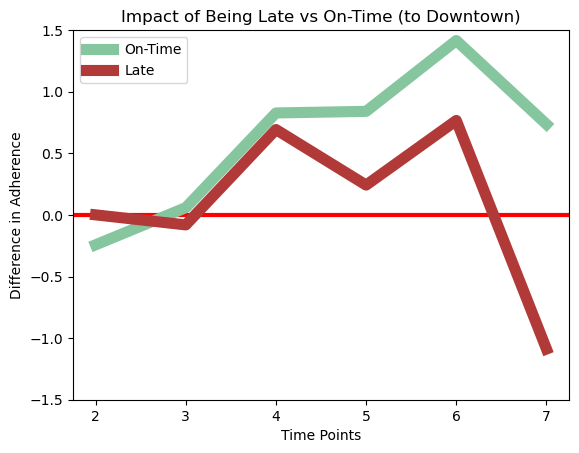

<Figure size 640x480 with 0 Axes>

In [41]:
plt.axhline(0, color = 'red', linewidth = 3)
plt.plot(wego6_firststop_ontime_to_avg['Stop_#'],wego6_firststop_ontime_to_avg['DIFF_ADHERENCE'], linewidth = 8, label ='On-Time', color ='#86C69F')
plt.plot(wego6_firststop_late_to_avg['Stop_#'],wego6_firststop_late_to_avg['DIFF_ADHERENCE'], linewidth = 8, label='Late', color = '#B13A38')
plt.title('Impact of Being Late vs On-Time (to Downtown)')
plt.xlabel('Time Points')
plt.ylabel('Difference in Adherence')

plt.ylim(-1.5,1.5)
plt.legend()
plt.show()

plt.savefig('plot.png')
#The graph demonstrates that although the pacing picked up after the 3rd stop (almost matching the on-time pacing), as the number of stops increases, it seems that the overall effect of being late seems to be more prevalent 

### Graphing On-Time vs Late First Stop From Downtown 

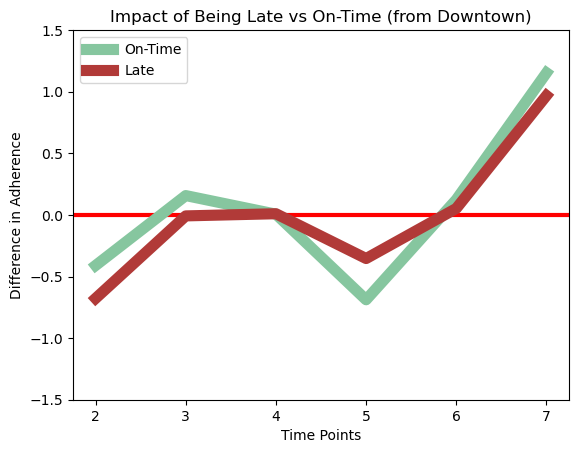

<Figure size 640x480 with 0 Axes>

In [42]:
plt.axhline(0, color = 'red', linewidth = 3)
plt.plot(wego6_firststop_ontime_from_avg['Stop_#'],wego6_firststop_ontime_from_avg['DIFF_ADHERENCE'], linewidth = 8, label ='On-Time',color ='#86C69F')
plt.plot(wego6_firststop_late_from_avg['Stop_#'],wego6_firststop_late_from_avg['DIFF_ADHERENCE'], linewidth = 8, label='Late', color = '#B13A38')
plt.title('Impact of Being Late vs On-Time (from Downtown)')
plt.xlabel('Time Points')
plt.ylabel('Difference in Adherence')

plt.ylim(-1.5,1.5)
plt.legend()
plt.show()

plt.savefig('impact_from_downtown.png', transparent=True)
#For the first 4 stops, the pacing of the late bus is actually closing the gap and not only matches the pace of on-time buses, but the pacing is even higher until stop #6. Coming from downtown is less affected by having a late start as it pertains to gaining/lossing time.  

In [ ]:
the on time graph serves as a benchmark 


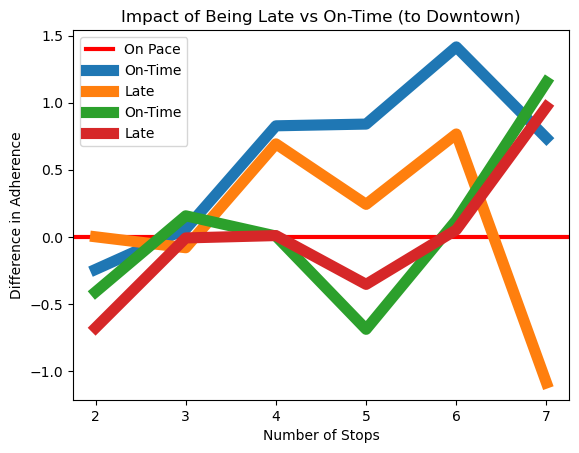

In [24]:
plt.axhline(0, color = 'red', linewidth = 3, label = 'On Pace')
plt.plot(wego6_firststop_ontime_to_avg['Stop_#'],wego6_firststop_ontime_to_avg['DIFF_ADHERENCE'], linewidth = 8, label ='On-Time')
plt.plot(wego6_firststop_late_to_avg['Stop_#'],wego6_firststop_late_to_avg['DIFF_ADHERENCE'], linewidth = 8, label='Late')
plt.plot(wego6_firststop_ontime_from_avg['Stop_#'],wego6_firststop_ontime_from_avg['DIFF_ADHERENCE'], linewidth = 8, label ='On-Time')
plt.plot(wego6_firststop_late_from_avg['Stop_#'],wego6_firststop_late_from_avg['DIFF_ADHERENCE'], linewidth = 8, label='Late')
plt.title('Impact of Being Late vs On-Time (to Downtown)')
plt.xlabel('Number of Stops')
plt.ylabel('Difference in Adherence')

plt.legend()
plt.show()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

In [ ]:
wego = pd.read_csv("data/Headway Data, 8-1-2023 to 9-30-2023.csv")

7. What is the impact of the layover at the start of the trip (the difference between the first stop arrival and departure time)?


In [2]:
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.500000
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,9,0.000000
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,19,0.000000
3,120230801,1,99457893,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,35,0.000000
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,36,12.866666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,35.266666,5.266666,0,1,0,0,0.0,0,539,0.000000
350324,120230930,2,100406611,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,NaN,NaN,0,1,0,0,NaN,0,551,0.000000
350325,120230930,2,100406612,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,31.866666,1.866666,0,0,1,0,0.0,0,552,0.000000
350326,120230930,2,100406613,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,47.500000,17.500000,0,1,0,0,0.0,0,563,0.000000


In [3]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS'],
      dtype='object')

In [4]:
wego['ROUTE_ABBR'].value_counts()

ROUTE_ABBR
55    61944
56    60020
52    51819
3     47162
50    43291
23    42108
22    25958
7     18026
Name: count, dtype: int64

In [5]:
wego2 = wego[['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR', 'TRIP_ID', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'SCHEDULED_TIME','ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV','DWELL_IN_MINS']]

In [6]:
wego2

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS
0,120230801,1,99457890,8/1/2023,22,345104,MHSP,14.0,1,4:42:00,4:37:38,4:44:08,-2.133333,NaN,NaN,NaN,6.500000
1,120230801,1,99457891,8/1/2023,22,345104,ELIZ,10.0,0,4:46:00,4:48:27,4:48:27,-2.450000,NaN,NaN,NaN,0.000000
2,120230801,1,99457892,8/1/2023,22,345104,CV23,5.0,0,4:54:00,4:54:56,4:54:56,-0.933333,NaN,NaN,NaN,0.000000
3,120230801,1,99457893,8/1/2023,22,345104,MCC5_10,1.0,2,5:10:00,5:03:43,5:03:43,6.283333,NaN,NaN,NaN,0.000000
4,120230801,1,99457894,8/1/2023,22,345105,MCC5_10,1.0,1,5:15:00,5:03:43,5:16:35,-1.583333,NaN,NaN,NaN,12.866666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,9/30/2023,7,353448,21BK,4.0,0,22:23:00,22:31:26,22:31:26,-8.433333,30.0,35.266666,5.266666,0.000000
350324,120230930,2,100406611,9/30/2023,7,353448,MCC5_9,3.0,2,22:38:00,22:49:18,22:49:18,-11.300000,NaN,NaN,NaN,0.000000
350325,120230930,2,100406612,9/30/2023,7,353449,MCC5_9,3.0,1,22:45:00,22:49:19,22:49:19,-4.316666,30.0,31.866666,1.866666,0.000000
350326,120230930,2,100406613,9/30/2023,7,353449,21BK,4.0,0,22:59:00,23:21:05,23:21:05,-22.083333,30.0,47.500000,17.500000,0.000000


In [7]:
# changed so we could concat column

wego2.CALENDAR_ID=wego2.CALENDAR_ID.astype(str)

C:\Users\Timmica\AppData\Local\Temp\ipykernel_14068\1438886128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego2.CALENDAR_ID=wego2.CALENDAR_ID.astype(str)


In [8]:
# changed so we could concat column

wego2.TRIP_ID=wego2.TRIP_ID.astype(str)

C:\Users\Timmica\AppData\Local\Temp\ipykernel_14068\1980983001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego2.TRIP_ID=wego2.TRIP_ID.astype(str)


In [9]:
# concated these columns so that we could have a unique identifier on this data frame

wego2['id'] = wego2['CALENDAR_ID'] + wego2['TRIP_ID']

C:\Users\Timmica\AppData\Local\Temp\ipykernel_14068\1391964207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego2['id'] = wego2['CALENDAR_ID'] + wego2['TRIP_ID']


In [10]:
#created a data fram from the previous that filtered for the start of the trip

wego2_start = wego2.loc[wego2['TRIP_EDGE']== 1]

In [11]:
wego2_start

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS,id
0,120230801,1,99457890,8/1/2023,22,345104,MHSP,14.0,1,4:42:00,4:37:38,4:44:08,-2.133333,NaN,NaN,NaN,6.500000,120230801345104
4,120230801,1,99457894,8/1/2023,22,345105,MCC5_10,1.0,1,5:15:00,5:03:43,5:16:35,-1.583333,NaN,NaN,NaN,12.866666,120230801345105
7,120230801,1,99457897,8/1/2023,22,345106,MHSP,14.0,1,5:42:00,5:30:30,5:43:43,-1.716666,35.0,37.666666,2.666666,13.216666,120230801345106
11,120230801,1,99457901,8/1/2023,22,345107,MCC5_10,1.0,1,6:15:00,6:05:31,6:16:19,-1.316666,15.0,12.833333,-2.166667,10.800000,120230801345107
14,120230801,1,99457904,8/1/2023,22,345108,MHSP,14.0,1,6:42:00,6:30:59,6:43:31,-1.516666,60.0,59.800000,-0.200000,12.533333,120230801345108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350313,120230930,2,100406600,9/30/2023,7,353445,MCC5_9,3.0,1,20:45:00,20:40:02,20:48:17,-3.283333,30.0,31.200000,1.200000,8.250000,120230930353445
350316,120230930,2,100406603,9/30/2023,7,353446,HBHS,5.0,1,21:16:00,21:12:40,21:16:51,-0.850000,28.0,26.066666,-1.933334,4.183333,120230930353446
350319,120230930,2,100406606,9/30/2023,7,353447,MCC5_9,3.0,1,21:45:00,21:43:52,21:50:54,-5.900000,30.0,36.716666,6.716666,7.033333,120230930353447
350322,120230930,2,100406609,9/30/2023,7,353448,HBHS,5.0,1,22:16:00,22:22:39,22:24:37,-8.616666,30.0,34.916666,4.916666,1.966666,120230930353448


In [12]:
# THere are less unique rows than in the original data frame. We suspect duplicates
len(pd.unique(wego2_start['id']))

67361

In [13]:
wego2

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS,id
0,120230801,1,99457890,8/1/2023,22,345104,MHSP,14.0,1,4:42:00,4:37:38,4:44:08,-2.133333,NaN,NaN,NaN,6.500000,120230801345104
1,120230801,1,99457891,8/1/2023,22,345104,ELIZ,10.0,0,4:46:00,4:48:27,4:48:27,-2.450000,NaN,NaN,NaN,0.000000,120230801345104
2,120230801,1,99457892,8/1/2023,22,345104,CV23,5.0,0,4:54:00,4:54:56,4:54:56,-0.933333,NaN,NaN,NaN,0.000000,120230801345104
3,120230801,1,99457893,8/1/2023,22,345104,MCC5_10,1.0,2,5:10:00,5:03:43,5:03:43,6.283333,NaN,NaN,NaN,0.000000,120230801345104
4,120230801,1,99457894,8/1/2023,22,345105,MCC5_10,1.0,1,5:15:00,5:03:43,5:16:35,-1.583333,NaN,NaN,NaN,12.866666,120230801345105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,9/30/2023,7,353448,21BK,4.0,0,22:23:00,22:31:26,22:31:26,-8.433333,30.0,35.266666,5.266666,0.000000,120230930353448
350324,120230930,2,100406611,9/30/2023,7,353448,MCC5_9,3.0,2,22:38:00,22:49:18,22:49:18,-11.300000,NaN,NaN,NaN,0.000000,120230930353448
350325,120230930,2,100406612,9/30/2023,7,353449,MCC5_9,3.0,1,22:45:00,22:49:19,22:49:19,-4.316666,30.0,31.866666,1.866666,0.000000,120230930353449
350326,120230930,2,100406613,9/30/2023,7,353449,21BK,4.0,0,22:59:00,23:21:05,23:21:05,-22.083333,30.0,47.500000,17.500000,0.000000,120230930353449


In [14]:
#looked for duplicates to ensure that having the unique identifier works correctly

dup_rows= wego2_start[wego2_start.duplicated(['CALENDAR_ID', 'TRIP_ID'])]

In [15]:
len(dup_rows)

54

In [16]:
dup_rows

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS,id
221,120230801,1,99458114,8/1/2023,22,345216,MCC5_10,1.0,1,6:45:00,6:45:50,6:45:50,-0.833333,15.0,12.966666,-2.033334,0.000000,120230801345216
14325,120230803,1,99527523,8/3/2023,3,346049,MCC5_5,2.0,1,5:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120230803346049
16007,120230803,1,99529888,8/3/2023,52,347180,HCKP,9.0,1,19:45:00,19:34:44,19:47:43,-2.716666,43.0,42.800000,-0.200000,12.983333,120230803347180
17697,120230803,1,99531626,8/3/2023,55,347848,HHWM,11.0,1,10:26:00,10:33:38,10:33:38,-7.633333,10.0,17.250000,7.250000,0.000000,120230803347848
24550,120230804,1,99565741,8/4/2023,56,352790,MCC4_18,6.0,1,9:15:00,8:31:39,8:35:05,39.916666,10.0,5.716666,-4.283334,3.433333,120230804352790
30002,120230805,2,99586744,8/5/2023,7,353440,HBHS,5.0,1,17:06:00,17:07:38,17:07:38,-1.633333,30.0,30.400000,0.400000,0.000000,120230805353440
70795,120230813,3,99799773,8/13/2023,23,350459,DWMRT,5.0,1,9:19:00,9:12:14,9:18:03,0.950000,25.0,21.800000,-3.200000,5.816666,120230813350459
75525,120230814,1,99824715,8/14/2023,3,350976,MCC5_5,2.0,1,9:45:00,10:01:08,10:01:08,-16.133333,15.0,4.683333,-10.316667,0.000000,120230814350976
80315,120230814,1,99830764,8/14/2023,7,353348,HBHS,5.0,1,7:39:00,7:31:02,7:39:54,-0.900000,16.0,15.933333,-0.066667,8.866666,120230814353348
86804,120230815,1,99864792,8/15/2023,7,353354,HBHS,5.0,1,11:36:00,11:48:56,11:48:56,-12.933333,20.0,32.300000,12.300000,0.000000,120230815353354


In [87]:
# we looked at the a few of the dups to investigate them furhter. We decided that we would leave them in for now as there are only  54 and it would not really affect the data

dup_ex = wego2_start[wego2_start['id'].isin(['120230803347848'])]
dup_ex

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS,id
17619,120230803,1,99531547,8/3/2023,55,347848,HHWM,11.0,1,10:26:00,NaN,NaN,NaN,10.0,NaN,NaN,NaN,120230803347848
17697,120230803,1,99531626,8/3/2023,55,347848,HHWM,11.0,1,10:26:00,10:33:38,10:33:38,-7.633333,10.0,17.25,7.25,0.0,120230803347848


In [17]:
# created a separate dataframe to do the agg, on them

hdw_pers= wego2.groupby('id')['HDWY_DEV'].sum() / wego2.groupby('id')['SCHEDULED_HDWY'].sum()*100
hdw_pers

id
120230801345104          NaN
120230801345105          NaN
120230801345106     4.882351
120230801345107   -20.166670
120230801345108     1.925925
                     ...    
120230930353445     6.063217
120230930353446     2.916664
120230930353447    11.194443
120230930353448    16.972220
120230930353449    32.277777
Length: 67370, dtype: float64

In [18]:
hdw_pers =hdw_pers.to_frame().reset_index()


In [19]:
hdw_pers.columns = ['id', 'hdwy%']


In [20]:
# second dataframe with agg
hdw_pers

,id,hdwy%
0,120230801345104,NaN
1,120230801345105,NaN
2,120230801345106,4.882351
3,120230801345107,-20.166670
4,120230801345108,1.925925
...,...,...
67365,120230930353445,6.063217
67366,120230930353446,2.916664
67367,120230930353447,11.194443
67368,120230930353448,16.972220


In [21]:
# merged the two dataframes
new_wego = pd.merge(hdw_pers, wego2_start, 
                               left_on = 'id', right_on = 'id', 
                               how = 'inner')

In [22]:
new_wego

,id,hdwy%,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS
0,120230801345104,NaN,120230801,1,99457890,8/1/2023,22,345104,MHSP,14.0,1,4:42:00,4:37:38,4:44:08,-2.133333,NaN,NaN,NaN,6.500000
1,120230801345105,NaN,120230801,1,99457894,8/1/2023,22,345105,MCC5_10,1.0,1,5:15:00,5:03:43,5:16:35,-1.583333,NaN,NaN,NaN,12.866666
2,120230801345106,4.882351,120230801,1,99457897,8/1/2023,22,345106,MHSP,14.0,1,5:42:00,5:30:30,5:43:43,-1.716666,35.0,37.666666,2.666666,13.216666
3,120230801345107,-20.166670,120230801,1,99457901,8/1/2023,22,345107,MCC5_10,1.0,1,6:15:00,6:05:31,6:16:19,-1.316666,15.0,12.833333,-2.166667,10.800000
4,120230801345108,1.925925,120230801,1,99457904,8/1/2023,22,345108,MHSP,14.0,1,6:42:00,6:30:59,6:43:31,-1.516666,60.0,59.800000,-0.200000,12.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67410,120230930353445,6.063217,120230930,2,100406600,9/30/2023,7,353445,MCC5_9,3.0,1,20:45:00,20:40:02,20:48:17,-3.283333,30.0,31.200000,1.200000,8.250000
67411,120230930353446,2.916664,120230930,2,100406603,9/30/2023,7,353446,HBHS,5.0,1,21:16:00,21:12:40,21:16:51,-0.850000,28.0,26.066666,-1.933334,4.183333
67412,120230930353447,11.194443,120230930,2,100406606,9/30/2023,7,353447,MCC5_9,3.0,1,21:45:00,21:43:52,21:50:54,-5.900000,30.0,36.716666,6.716666,7.033333
67413,120230930353448,16.972220,120230930,2,100406609,9/30/2023,7,353448,HBHS,5.0,1,22:16:00,22:22:39,22:24:37,-8.616666,30.0,34.916666,4.916666,1.966666


How much impact does being late or too spaced out at the first stop have downstream?

code that was re used to show the group
#wego2_start2 = wego2_start[wego2_start.duplicated(subset=['CALENDAR_ID', 'TRIP_ID'])]
#len(wego2_start2)

In [47]:
# start of code to get the outliers removed from the table before plotting
new_wego_desc = new_wego.describe()
new_wego_desc

,hdwy%,SERVICE_ABBR,ADHERENCE_ID,ROUTE_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS
count,6.604900e+04,67415.00000,6.741500e+04,67415.000000,67407.000000,67415.0,65711.000000,65826.000000,64135.000000,64075.000000,65708.000000
mean,inf,1.29176,1.001038e+08,35.526589,6.685537,1.0,-2.760552,20.315514,20.726943,0.475748,13.648429
std,NaN,0.62752,3.227669e+05,20.653302,4.300680,0.0,8.510429,15.046456,16.342151,6.262452,11.424494
min,-9.847223e+01,1.00000,9.945789e+07,3.000000,1.000000,1.0,-948.533333,0.000000,0.000000,-64.000000,-208.033333
25%,-1.062500e+01,1.00000,9.989121e+07,22.000000,3.000000,1.0,-3.533333,12.000000,11.683333,-1.733334,8.066666
50%,1.250000e-01,1.00000,1.001343e+08,50.000000,6.000000,1.0,-1.950000,15.000000,17.483333,0.033333,12.816666
75%,1.248889e+01,1.00000,1.003476e+08,55.000000,11.000000,1.0,-0.833333,25.000000,26.100000,1.883333,17.466666
max,inf,3.00000,1.007029e+08,56.000000,17.000000,1.0,84.666666,407.000000,514.366666,472.366666,956.500000


In [93]:
IQR_dwell = new_wego_desc.loc['75%', 'DWELL_IN_MINS'] - new_wego_desc.loc['25%', 'DWELL_IN_MINS']


In [94]:
dwell_low = new_wego_desc.loc['25%','DWELL_IN_MINS'] - (1.5* IQR_dwell)
dwell_low

-6.033334000000002

In [95]:
dwell_high = new_wego_desc.loc['75%','DWELL_IN_MINS'] + (1.5* IQR_dwell)
dwell_high

31.566666

In [96]:
IQR_hdwy = new_wego_desc.loc['75%','hdwy%'] - new_wego_desc.loc['25%','hdwy%']

In [97]:
hdwy_low = new_wego_desc.loc['25%','hdwy%'] - (1.5* IQR_hdwy)
hdwy_low

-45.29583446428572

In [98]:
hdwy_high = new_wego_desc.loc['75%','hdwy%'] + (1.5* IQR_hdwy)
hdwy_high

47.159719345238095

In [101]:
new_wego_no_outlier = (new_wego.loc[(new_wego['hdwy%'] > hdwy_low) 
                        & (new_wego['hdwy%'] < hdwy_high)
                        & (new_wego['DWELL_IN_MINS'] >= 0)
                        & (new_wego['DWELL_IN_MINS'] < dwell_high)] )
new_wego_no_outlier

,id,hdwy%,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS
2,120230801345106,4.882351,120230801,1,99457897,8/1/2023,22,345106,MHSP,14.0,1,5:42:00,5:30:30,5:43:43,-1.716666,35.0,37.666666,2.666666,13.216666
3,120230801345107,-20.166670,120230801,1,99457901,8/1/2023,22,345107,MCC5_10,1.0,1,6:15:00,6:05:31,6:16:19,-1.316666,15.0,12.833333,-2.166667,10.800000
4,120230801345108,1.925925,120230801,1,99457904,8/1/2023,22,345108,MHSP,14.0,1,6:42:00,6:30:59,6:43:31,-1.516666,60.0,59.800000,-0.200000,12.533333
5,120230801345109,-0.500003,120230801,1,99457908,8/1/2023,22,345109,MCC5_10,1.0,1,7:15:00,7:05:49,7:16:44,-1.733333,15.0,15.233333,0.233333,10.916666
6,120230801345110,0.940171,120230801,1,99457912,8/1/2023,22,345110,MHSP,14.0,1,7:45:00,7:34:00,7:46:15,-1.250000,63.0,62.733333,-0.266667,12.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67410,120230930353445,6.063217,120230930,2,100406600,9/30/2023,7,353445,MCC5_9,3.0,1,20:45:00,20:40:02,20:48:17,-3.283333,30.0,31.200000,1.200000,8.250000
67411,120230930353446,2.916664,120230930,2,100406603,9/30/2023,7,353446,HBHS,5.0,1,21:16:00,21:12:40,21:16:51,-0.850000,28.0,26.066666,-1.933334,4.183333
67412,120230930353447,11.194443,120230930,2,100406606,9/30/2023,7,353447,MCC5_9,3.0,1,21:45:00,21:43:52,21:50:54,-5.900000,30.0,36.716666,6.716666,7.033333
67413,120230930353448,16.972220,120230930,2,100406609,9/30/2023,7,353448,HBHS,5.0,1,22:16:00,22:22:39,22:24:37,-8.616666,30.0,34.916666,4.916666,1.966666


<Figure size 1000x1000 with 0 Axes>

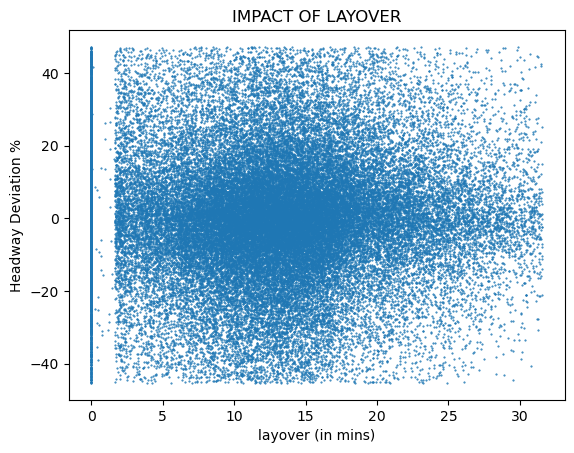

In [113]:
plt.figure(figsize=(10, 5))
new_wego_no_outlier.plot.scatter('DWELL_IN_MINS', 'hdwy%', s= 0.25)
plt.title('IMPACT OF LAYOVER')
plt.xlabel('layover (in mins)')
plt.ylabel('Headway Deviation %')
plt.show()

What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

In [30]:
# dataframe that has the two colunms combined already
wego2

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS,id
0,120230801,1,99457890,8/1/2023,22,345104,MHSP,14.0,1,4:42:00,4:37:38,4:44:08,-2.133333,NaN,NaN,NaN,6.500000,120230801345104
1,120230801,1,99457891,8/1/2023,22,345104,ELIZ,10.0,0,4:46:00,4:48:27,4:48:27,-2.450000,NaN,NaN,NaN,0.000000,120230801345104
2,120230801,1,99457892,8/1/2023,22,345104,CV23,5.0,0,4:54:00,4:54:56,4:54:56,-0.933333,NaN,NaN,NaN,0.000000,120230801345104
3,120230801,1,99457893,8/1/2023,22,345104,MCC5_10,1.0,2,5:10:00,5:03:43,5:03:43,6.283333,NaN,NaN,NaN,0.000000,120230801345104
4,120230801,1,99457894,8/1/2023,22,345105,MCC5_10,1.0,1,5:15:00,5:03:43,5:16:35,-1.583333,NaN,NaN,NaN,12.866666,120230801345105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,9/30/2023,7,353448,21BK,4.0,0,22:23:00,22:31:26,22:31:26,-8.433333,30.0,35.266666,5.266666,0.000000,120230930353448
350324,120230930,2,100406611,9/30/2023,7,353448,MCC5_9,3.0,2,22:38:00,22:49:18,22:49:18,-11.300000,NaN,NaN,NaN,0.000000,120230930353448
350325,120230930,2,100406612,9/30/2023,7,353449,MCC5_9,3.0,1,22:45:00,22:49:19,22:49:19,-4.316666,30.0,31.866666,1.866666,0.000000,120230930353449
350326,120230930,2,100406613,9/30/2023,7,353449,21BK,4.0,0,22:59:00,23:21:05,23:21:05,-22.083333,30.0,47.500000,17.500000,0.000000,120230930353449


In [31]:
all_arrivals = len(wego2)

all_arrivals

350328

In [145]:
on_time_arrivals = (wego2['ADHERENCE'] >= -6) & (wego2['ADHERENCE'] <=1)
on_time_arrivals

0          True
1          True
2          True
3         False
4          True
          ...  
350323    False
350324    False
350325     True
350326    False
350327    False
Name: ADHERENCE, Length: 350328, dtype: bool

In [146]:
total_on_time = on_time_arrivals.sum()
total_on_time 

246790

In [147]:
overall_performance = total_on_time / all_arrivals *100

overall_performance

70.44541115754379

In [103]:
# code to get the outlier removed before plotting the distro 
wego2_desc = wego2.describe()
wego2_desc

,SERVICE_ABBR,ADHERENCE_ID,ROUTE_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS
count,350328.000000,3.503280e+05,350328.000000,350317.000000,350328.000000,338860.000000,274737.000000,266061.000000,265892.000000,338857.000000
mean,1.298466,1.001038e+08,38.348080,7.351302,0.579089,-3.188795,18.186040,18.648567,0.518068,2.963914
std,0.633101,3.227507e+05,20.338352,4.032993,0.793978,6.898852,12.261828,14.330594,7.161809,7.402945
min,1.000000,9.945789e+07,3.000000,1.000000,0.000000,-948.533333,0.000000,0.000000,-64.000000,-208.033333
25%,1.000000,9.989140e+07,22.000000,4.000000,0.000000,-4.566666,10.000000,11.000000,-2.316667,0.000000
50%,1.000000,1.001346e+08,50.000000,6.000000,0.000000,-2.000000,15.000000,16.183333,0.033333,0.000000
75%,1.000000,1.003481e+08,55.000000,10.000000,1.000000,-0.333333,20.000000,23.250000,2.483333,1.950000
max,3.000000,1.007029e+08,56.000000,17.000000,2.000000,88.383333,503.000000,590.433333,565.433333,956.500000


In [155]:
adh_val = wego2['ADHERENCE'].value_counts()
adh_val

ADHERENCE
 0.966666      1355
 0.950000      1341
-0.166666      1082
-0.200000      1042
-0.100000      1033
               ... 
-108.733333       1
-111.116666       1
-41.366666        1
 32.800000        1
 13.366666        1
Name: count, Length: 3765, dtype: int64

In [104]:
IQR_adh = wego2_desc.loc['75%','ADHERENCE'] -  wego2_desc.loc['25%','ADHERENCE']
IQR_adh 

4.233333

In [105]:
hdwy_low2 = wego2_desc.loc['25%','ADHERENCE'] - (1.5* IQR_adh)
hdwy_low2

-10.9166655

In [106]:
hdwy_high2 = wego2_desc.loc['75%','ADHERENCE'] + (1.5* IQR_adh)
hdwy_high2

6.0166665

In [160]:
wego_adh_no_out = (wego2.loc[(wego2['ADHERENCE'] > hdwy_low2) & (wego2['ADHERENCE'] < hdwy_high2)])
                       
wego_adh_no_out

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS,id
0,120230801,1,99457890,8/1/2023,22,345104,MHSP,14.0,1,4:42:00,4:37:38,4:44:08,-2.133333,NaN,NaN,NaN,6.500000,120230801345104
1,120230801,1,99457891,8/1/2023,22,345104,ELIZ,10.0,0,4:46:00,4:48:27,4:48:27,-2.450000,NaN,NaN,NaN,0.000000,120230801345104
2,120230801,1,99457892,8/1/2023,22,345104,CV23,5.0,0,4:54:00,4:54:56,4:54:56,-0.933333,NaN,NaN,NaN,0.000000,120230801345104
4,120230801,1,99457894,8/1/2023,22,345105,MCC5_10,1.0,1,5:15:00,5:03:43,5:16:35,-1.583333,NaN,NaN,NaN,12.866666,120230801345105
5,120230801,1,99457895,8/1/2023,22,345105,CV23,5.0,0,5:25:00,5:24:03,5:24:03,0.950000,NaN,NaN,NaN,0.000000,120230801345105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350317,120230930,2,100406604,9/30/2023,7,353446,21BK,4.0,0,21:23:00,21:30:00,21:30:00,-7.000000,28.0,31.566666,3.566666,0.000000,120230930353446
350319,120230930,2,100406606,9/30/2023,7,353447,MCC5_9,3.0,1,21:45:00,21:43:52,21:50:54,-5.900000,30.0,36.716666,6.716666,7.033333,120230930353447
350322,120230930,2,100406609,9/30/2023,7,353448,HBHS,5.0,1,22:16:00,22:22:39,22:24:37,-8.616666,30.0,34.916666,4.916666,1.966666,120230930353448
350323,120230930,2,100406610,9/30/2023,7,353448,21BK,4.0,0,22:23:00,22:31:26,22:31:26,-8.433333,30.0,35.266666,5.266666,0.000000,120230930353448


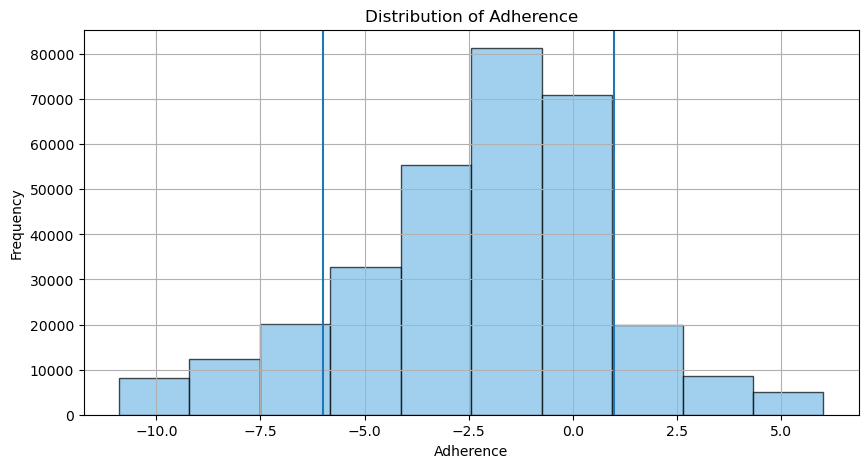

<Figure size 640x480 with 0 Axes>

In [175]:

plt.figure(figsize=(10, 5))
plt.hist(wego_adh_no_out['ADHERENCE'], bins=10, edgecolor='black', alpha=0.7, color='#79bde8')
plt.axvline(x = 1)
plt.axvline(x = -6)
plt.title('Distribution of Adherence')
plt.xlabel('Adherence')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
plt.savefig('plot.png')



In [46]:
wego2_desc = wego2.describe()
wego2_desc

,SERVICE_ABBR,ADHERENCE_ID,ROUTE_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS
count,350328.000000,3.503280e+05,350328.000000,350317.000000,350328.000000,338860.000000,274737.000000,266061.000000,265892.000000,338857.000000
mean,1.298466,1.001038e+08,38.348080,7.351302,0.579089,-3.188795,18.186040,18.648567,0.518068,2.963914
std,0.633101,3.227507e+05,20.338352,4.032993,0.793978,6.898852,12.261828,14.330594,7.161809,7.402945
min,1.000000,9.945789e+07,3.000000,1.000000,0.000000,-948.533333,0.000000,0.000000,-64.000000,-208.033333
25%,1.000000,9.989140e+07,22.000000,4.000000,0.000000,-4.566666,10.000000,11.000000,-2.316667,0.000000
50%,1.000000,1.001346e+08,50.000000,6.000000,0.000000,-2.000000,15.000000,16.183333,0.033333,0.000000
75%,1.000000,1.003481e+08,55.000000,10.000000,1.000000,-0.333333,20.000000,23.250000,2.483333,1.950000
max,3.000000,1.007029e+08,56.000000,17.000000,2.000000,88.383333,503.000000,590.433333,565.433333,956.500000


In [64]:
IQR_hdwy2 = wego2_desc.loc['75%','HDWY_DEV'] -  wego2_desc.loc['25%','HDWY_DEV']
IQR_hdwy2

4.8

In [62]:
hdwy_low2 = wego2_desc.loc['25%','HDWY_DEV'] - (1.5* IQR_hdwy2)
hdwy_low2

-9.516666999999998

In [69]:
hdwy_high2 = wego2_desc.loc['75%','HDWY_DEV'] + (1.5* IQR_hdwy2)
hdwy_high2

9.683333

In [168]:
wego_hdwy2_no_out = (wego2.loc[(wego2['HDWY_DEV'] > hdwy_low2) & (wego2['HDWY_DEV'] < hdwy_high2)])
                       
wego_hdwy2_no_out

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS,id
7,120230801,1,99457897,8/1/2023,22,345106,MHSP,14.0,1,5:42:00,5:30:30,5:43:43,-1.716666,35.0,37.666666,2.666666,13.216666,120230801345106
8,120230801,1,99457898,8/1/2023,22,345106,ELIZ,10.0,0,5:46:00,5:47:55,5:47:55,-1.916666,35.0,36.966666,1.966666,0.000000,120230801345106
9,120230801,1,99457899,8/1/2023,22,345106,CV23,5.0,0,5:54:00,5:54:11,5:54:11,-0.183333,15.0,14.516666,-0.483334,0.000000,120230801345106
11,120230801,1,99457901,8/1/2023,22,345107,MCC5_10,1.0,1,6:15:00,6:05:31,6:16:19,-1.316666,15.0,12.833333,-2.166667,10.800000,120230801345107
12,120230801,1,99457902,8/1/2023,22,345107,CV23,5.0,0,6:25:00,6:23:30,6:23:30,1.500000,15.0,11.116666,-3.883334,0.000000,120230801345107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350316,120230930,2,100406603,9/30/2023,7,353446,HBHS,5.0,1,21:16:00,21:12:40,21:16:51,-0.850000,28.0,26.066666,-1.933334,4.183333,120230930353446
350317,120230930,2,100406604,9/30/2023,7,353446,21BK,4.0,0,21:23:00,21:30:00,21:30:00,-7.000000,28.0,31.566666,3.566666,0.000000,120230930353446
350322,120230930,2,100406609,9/30/2023,7,353448,HBHS,5.0,1,22:16:00,22:22:39,22:24:37,-8.616666,30.0,34.916666,4.916666,1.966666,120230930353448
350323,120230930,2,100406610,9/30/2023,7,353448,21BK,4.0,0,22:23:00,22:31:26,22:31:26,-8.433333,30.0,35.266666,5.266666,0.000000,120230930353448


In [179]:
new_wego2 = pd.merge(hdw_pers, wego_hdwy2_no_out, 
                               left_on = 'id', right_on = 'id', 
                               how = 'inner')
new_wego2

,id,hdwy%,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS
0,120230801345106,4.882351,120230801,1,99457897,8/1/2023,22,345106,MHSP,14.0,1,5:42:00,5:30:30,5:43:43,-1.716666,35.0,37.666666,2.666666,13.216666
1,120230801345106,4.882351,120230801,1,99457898,8/1/2023,22,345106,ELIZ,10.0,0,5:46:00,5:47:55,5:47:55,-1.916666,35.0,36.966666,1.966666,0.000000
2,120230801345106,4.882351,120230801,1,99457899,8/1/2023,22,345106,CV23,5.0,0,5:54:00,5:54:11,5:54:11,-0.183333,15.0,14.516666,-0.483334,0.000000
3,120230801345107,-20.166670,120230801,1,99457901,8/1/2023,22,345107,MCC5_10,1.0,1,6:15:00,6:05:31,6:16:19,-1.316666,15.0,12.833333,-2.166667,10.800000
4,120230801345107,-20.166670,120230801,1,99457902,8/1/2023,22,345107,CV23,5.0,0,6:25:00,6:23:30,6:23:30,1.500000,15.0,11.116666,-3.883334,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234602,120230930353446,2.916664,120230930,2,100406603,9/30/2023,7,353446,HBHS,5.0,1,21:16:00,21:12:40,21:16:51,-0.850000,28.0,26.066666,-1.933334,4.183333
234603,120230930353446,2.916664,120230930,2,100406604,9/30/2023,7,353446,21BK,4.0,0,21:23:00,21:30:00,21:30:00,-7.000000,28.0,31.566666,3.566666,0.000000
234604,120230930353448,16.972220,120230930,2,100406609,9/30/2023,7,353448,HBHS,5.0,1,22:16:00,22:22:39,22:24:37,-8.616666,30.0,34.916666,4.916666,1.966666
234605,120230930353448,16.972220,120230930,2,100406610,9/30/2023,7,353448,21BK,4.0,0,22:23:00,22:31:26,22:31:26,-8.433333,30.0,35.266666,5.266666,0.000000


In [180]:
hdw_pers.describe()

,hdwy%
count,6.600500e+04
mean,inf
std,NaN
min,-9.847223e+01
25%,-1.062500e+01
50%,1.296283e-01
75%,1.250000e+01
max,inf



# 8. What is the relationship between distance or time travelled since the start of a given trip and the headway deviation? Does headway become less stable the further along the route the bus has travelled?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import regex as re
import matplotlib.pyplot as plt

In [2]:
wego = pd.read_csv("../data/headway_data.csv")

In [3]:
midnite_trips = list(wego.loc[wego['SCHEDULED_TIME'].str.contains(r'24:\d\d:\d\d') | wego['SCHEDULED_TIME'].str.contains(r'25:\d\d:\d\d')]['TRIP_ID'].unique())

In [4]:
#remove midnight trips

wego = wego.loc[~wego['TRIP_ID'].isin(midnite_trips)]

In [5]:
#create the DATE TRIP ID
#create the LOCATION COUNT (counts the stops in a trip)

wego['DATE_TRIP'] = wego['CALENDAR_ID'].astype(str) + wego['TRIP_ID'].astype(str)
wego['LOCATION_COUNT'] = wego.groupby('DATE_TRIP')['DATE_TRIP'].cumcount()+1

In [6]:
wego.loc[wego['LOCATION_COUNT'] == 21]

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,DATE_TRIP,LOCATION_COUNT
325799,120230926,1,100285790,9/26/2023,56,5606,1389,353036,2,FROM DOWNTOWN,...,0,0,0,0,NaN,0,281,NaN,120230926353036,21


In [7]:
wego.loc[wego['ROUTE_ABBR'] == 56].loc[wego['DATE_TRIP'] == '120230926353036'][['DATE','TRIP_ID','SCHEDULED_TIME','TRIP_EDGE']]

,DATE,TRIP_ID,SCHEDULED_TIME,TRIP_EDGE
325743,9/26/2023,353036,12:25:00,1
325744,9/26/2023,353036,12:33:00,0
325745,9/26/2023,353036,12:42:00,0
325746,9/26/2023,353036,12:53:00,0
325747,9/26/2023,353036,13:03:00,0
325748,9/26/2023,353036,13:07:00,0
325749,9/26/2023,353036,13:11:00,2
325786,9/26/2023,353036,12:25:00,0
325787,9/26/2023,353036,12:33:00,0
325788,9/26/2023,353036,12:42:00,0


In [8]:
wego['LOCATION_COUNT'].value_counts()

LOCATION_COUNT
1     66104
2     66103
3     65642
4     53660
5     47472
6     32782
7     10132
8       298
9       284
10      257
11      172
12      163
13       62
14       59
15        1
16        1
17        1
18        1
19        1
20        1
21        1
Name: count, dtype: int64

In [9]:
bad_trip = ['120230926353036']

In [10]:
##dropping a DATE TRIP that seems to be broken

wego = wego.loc[~wego['DATE_TRIP'].isin(bad_trip)]

In [11]:
wego['LOCATION_COUNT'].value_counts()

LOCATION_COUNT
1     66103
2     66102
3     65641
4     53659
5     47471
6     32781
7     10131
8       297
9       283
10      256
11      171
12      162
13       61
14       58
Name: count, dtype: int64

In [12]:
wego.loc[wego['LOCATION_COUNT'] == 14][['DATE','ROUTE_ABBR','TRIP_ID','TRIP_EDGE','SCHEDULED_TIME']]['ROUTE_ABBR'].value_counts()

ROUTE_ABBR
56    36
52    17
23     5
Name: count, dtype: int64

In [13]:
## Create the headway deviation percent column

wego = wego.assign(HDWY_DEV_PCT = lambda x: (x['HDWY_DEV']) / (x['SCHEDULED_HDWY']) * 100 )

In [14]:
## Create Headway Flag (All negative values are a 'bad' headway)

wego = wego.assign(HDWY_FLAG=lambda x: ( (x['SCHEDULED_HDWY']) /2) - (abs (x['HDWY_DEV']) ) )

In [15]:
locations_dev = wego.groupby(by = 'LOCATION_COUNT')['HDWY_DEV'].mean().reset_index()

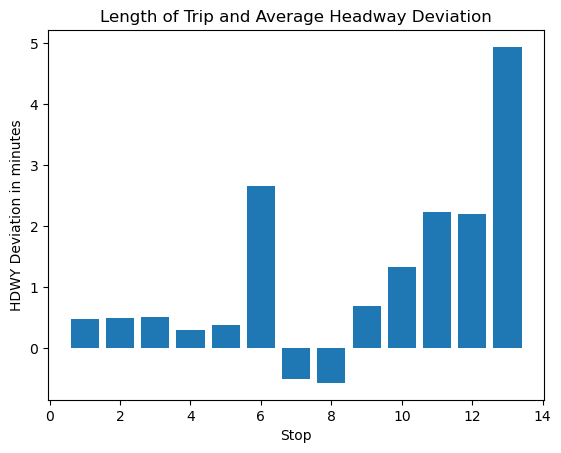

In [16]:
x = list(locations_dev['LOCATION_COUNT'])
y = list(locations_dev['HDWY_DEV'])
fig, ax = plt.subplots()
plt.title('Length of Trip and Average Headway Deviation')
plt.xlabel('Stop')
plt.ylabel('HDWY Deviation in minutes')
ax.bar(x,y);

<Axes: xlabel='LOCATION_COUNT', ylabel='HDWY_DEV'>

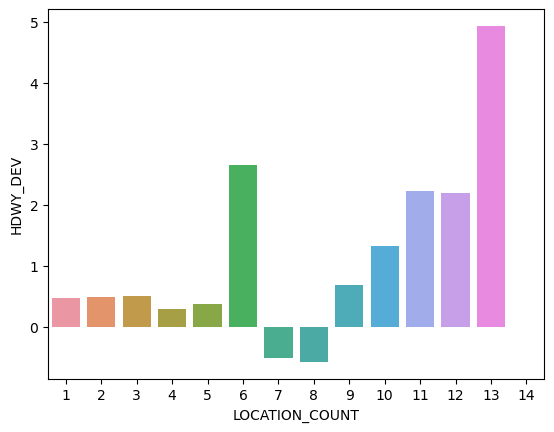

In [17]:
sns.barplot(data = wego.groupby(by = 'LOCATION_COUNT')['HDWY_DEV'].mean().reset_index(),
            x = 'LOCATION_COUNT',
            y= 'HDWY_DEV',
            
           )

In [18]:
locations_dev_pct = wego.groupby(by = 'LOCATION_COUNT')['HDWY_DEV_PCT'].mean().reset_index()

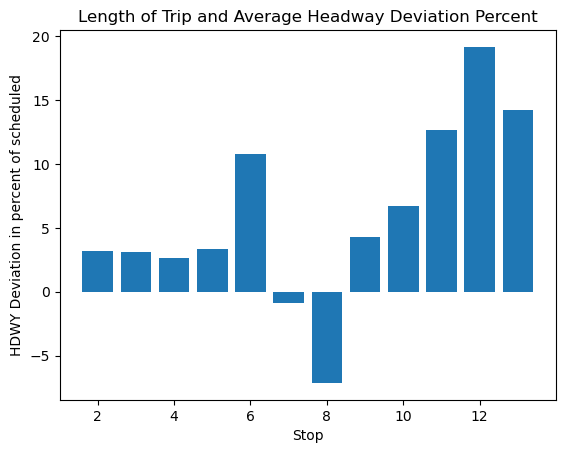

In [19]:
x = list(locations_dev_pct['LOCATION_COUNT'])
y = list(locations_dev_pct['HDWY_DEV_PCT'])
fig, ax = plt.subplots()
plt.title('Length of Trip and Average Headway Deviation Percent')
plt.xlabel('Stop')
plt.ylabel('HDWY Deviation in percent of scheduled')
ax.bar(x,y);

In [20]:
wego['SCHEDULED_DATETIME'] = wego['DATE'].astype(str) + ' ' + wego['SCHEDULED_TIME'].astype(str)
wego.loc[:,['SCHEDULED_DATETIME']] = pd.to_datetime(wego['SCHEDULED_DATETIME'])

In [21]:
wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,DATE_TRIP,LOCATION_COUNT,HDWY_DEV_PCT,HDWY_FLAG,SCHEDULED_DATETIME
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,0.0,0,2,6.500000,120230801345104,1,NaN,NaN,2023-08-01 04:42:00
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,0.0,0,9,0.000000,120230801345104,2,NaN,NaN,2023-08-01 04:46:00
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,0.0,0,19,0.000000,120230801345104,3,NaN,NaN,2023-08-01 04:54:00
3,120230801,1,99457893,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,NaN,0,35,0.000000,120230801345104,4,NaN,NaN,2023-08-01 05:10:00
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,0,0.0,0,36,12.866666,120230801345105,1,NaN,NaN,2023-08-01 05:15:00


In [22]:
wego.loc[wego['ADHERENCE'] < -6]

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,DATE_TRIP,LOCATION_COUNT,HDWY_DEV_PCT,HDWY_FLAG,SCHEDULED_DATETIME
69,120230801,1,99457959,8/1/2023,22,2200,2374,345124,0,FROM DOWNTOWN,...,0,NaN,0,656,0.000000,120230801345124,5,NaN,NaN,2023-08-01 15:44:00
78,120230801,1,99457968,8/1/2023,22,2200,2689,345127,0,TO DOWNTOWN,...,0,0.0,0,732,0.000000,120230801345127,2,39.027775,1.316667,2023-08-01 17:14:00
83,120230801,1,99457973,8/1/2023,22,2200,2689,345128,0,FROM DOWNTOWN,...,0,0.0,0,785,0.000000,120230801345128,4,-8.129253,20.516666,2023-08-01 18:06:00
91,120230801,1,99457981,8/1/2023,22,2200,2689,345131,0,TO DOWNTOWN,...,0,0.0,0,851,22.000000,120230801345131,1,8.333332,20.833334,2023-08-01 19:35:00
92,120230801,1,99457982,8/1/2023,22,2200,2689,345131,0,TO DOWNTOWN,...,0,0.0,0,867,0.000000,120230801345131,2,23.266664,6.683334,2023-08-01 19:44:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350322,120230930,2,100406609,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,0,0.0,0,530,1.966666,120230930353448,1,16.388887,10.083334,2023-09-30 22:16:00
350323,120230930,2,100406610,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,0,0.0,0,539,0.000000,120230930353448,2,17.555553,9.733334,2023-09-30 22:23:00
350324,120230930,2,100406611,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,0,NaN,0,551,0.000000,120230930353448,3,NaN,NaN,2023-09-30 22:38:00
350326,120230930,2,100406613,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,0,0.0,0,563,0.000000,120230930353449,2,58.333333,-2.500000,2023-09-30 22:59:00


In [23]:
DateTripList = list(wego['DATE_TRIP'].unique())

fig, ax =plt.subplots(1,3, figsize=(12, 5))
sns.boxplot(y=operators['percent_early'], ax=ax[0], color='green')
sns.boxplot(y=operators['percent_ontime'], ax=ax[1])
sns.boxplot(y=operators['percent_late'], ax=ax[2], color='orange')
fig.show()

# create plot
ax = sns.boxplot(x="Sensations", y="Temperature", data=df)

# show plot
plt.show()

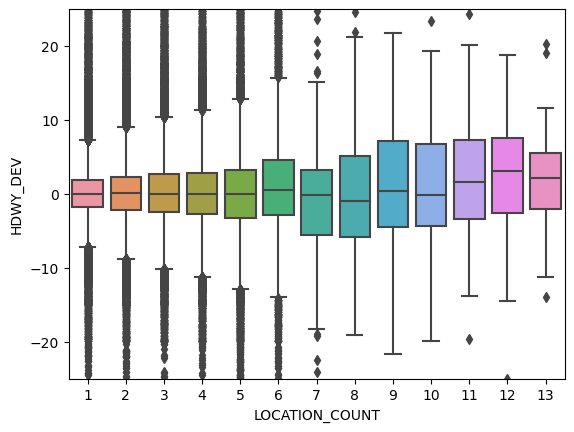

In [24]:
ax = sns.boxplot(data = wego.loc[wego['HDWY_DEV'] < 100], x = 'LOCATION_COUNT', y = 'HDWY_DEV')

ax.set_ylim([-25,25])

plt.show()

In [25]:
wego.isna().sum()

CALENDAR_ID                      0
SERVICE_ABBR                     0
ADHERENCE_ID                     0
DATE                             0
ROUTE_ABBR                       0
BLOCK_ABBR                       0
OPERATOR                         0
TRIP_ID                          0
OVERLOAD_ID                      0
ROUTE_DIRECTION_NAME             0
TIME_POINT_ABBR                  0
ROUTE_STOP_SEQUENCE              9
TRIP_EDGE                        0
LATITUDE                         0
LONGITUDE                        0
SCHEDULED_TIME                   0
ACTUAL_ARRIVAL_TIME          11139
ACTUAL_DEPARTURE_TIME        11148
ADHERENCE                    11148
SCHEDULED_HDWY               74106
ACTUAL_HDWY                  82642
HDWY_DEV                     82714
ADJUSTED_EARLY_COUNT             0
ADJUSTED_LATE_COUNT              0
ADJUSTED_ONTIME_COUNT            0
STOP_CANCELLED                   0
PREV_SCHED_STOP_CANCELLED    68949
IS_RELIEF                        0
BLOCK_STOP_ORDER    

# Wego All Dep(artures) removes 11K rows where Actual Departure Time is missing

# Wego All Dep as 343K rows

In [26]:
wego_alldep = wego.loc[~wego['ACTUAL_DEPARTURE_TIME'].isna()]

In [27]:
wego_alldep['DATE_TRIP'] = wego['CALENDAR_ID'].astype(str) + wego['TRIP_ID'].astype(str)
wego_alldep['LOCATION_COUNT'] = wego.groupby('DATE_TRIP')['DATE_TRIP'].cumcount()+1

C:\Users\dougl\AppData\Local\Temp\ipykernel_14660\2484621219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego_alldep['DATE_TRIP'] = wego['CALENDAR_ID'].astype(str) + wego['TRIP_ID'].astype(str)
C:\Users\dougl\AppData\Local\Temp\ipykernel_14660\2484621219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego_alldep['LOCATION_COUNT'] = wego.groupby('DATE_TRIP')['DATE_TRIP'].cumcount()+1


In [28]:
wego_alldep['LOCATION_COUNT'].value_counts()

LOCATION_COUNT
1     64453
2     64186
3     63276
4     52228
5     46233
6     31174
7      9672
8       185
9       184
10      159
11      111
12      102
13       36
14       29
Name: count, dtype: int64

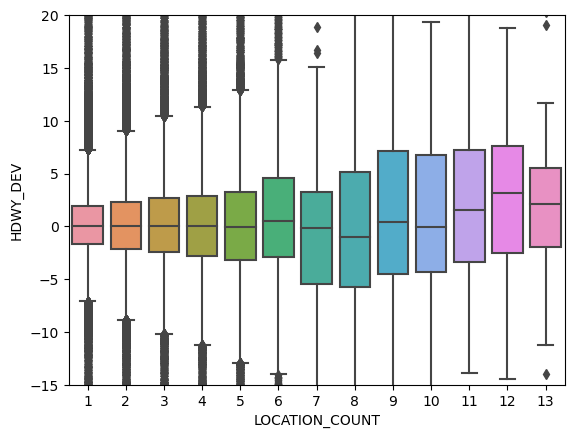

In [29]:
ax = sns.boxplot(data = wego.loc[wego['HDWY_DEV'] < 100], x = 'LOCATION_COUNT', y = 'HDWY_DEV')

ax.set_ylim([-15,20])

plt.show()

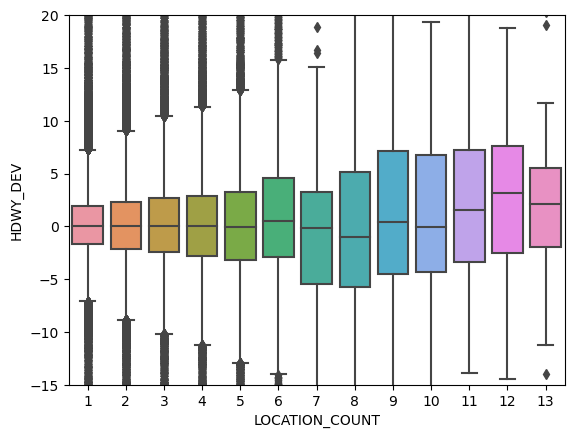

In [30]:
ax = sns.boxplot(data = wego_alldep.loc[wego_alldep['HDWY_DEV'] < 100], x = 'LOCATION_COUNT', y = 'HDWY_DEV')

ax.set_ylim([-15,20])

plt.show()

In [31]:
alistof7 = [1,2,3,4,5,6,7]
alistof7

[1, 2, 3, 4, 5, 6, 7]

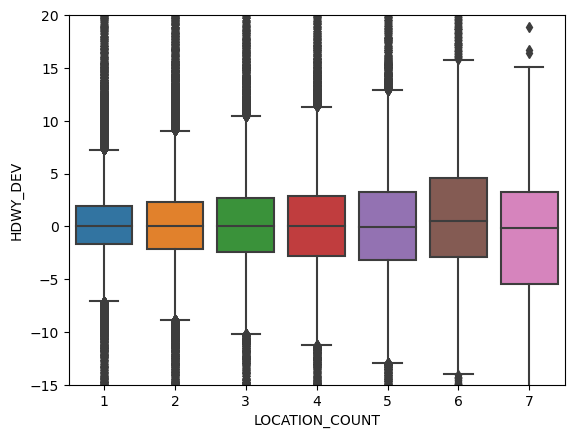

In [32]:
ax = sns.boxplot(data = wego.loc[wego['HDWY_DEV'] < 100].loc[wego['LOCATION_COUNT'].isin(alistof7)], x = 'LOCATION_COUNT', y = 'HDWY_DEV')

ax.set_ylim([-15,20])
#ax.set_xlim([0,7])
#plt.xlim([1,7])

plt.show()

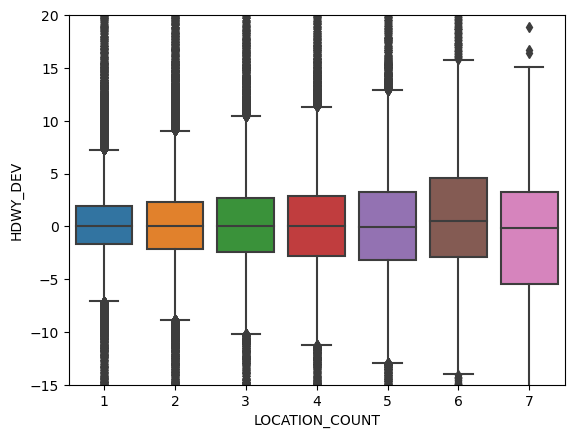

In [33]:
ax = sns.boxplot(data = wego_alldep.loc[wego_alldep['HDWY_DEV'] < 100].loc[wego_alldep['LOCATION_COUNT'].isin(alistof7)], x = 'LOCATION_COUNT', y = 'HDWY_DEV')

ax.set_ylim([-15,20])
#ax.set_xlim([0,7])
#plt.xlim([1,7])

plt.show()

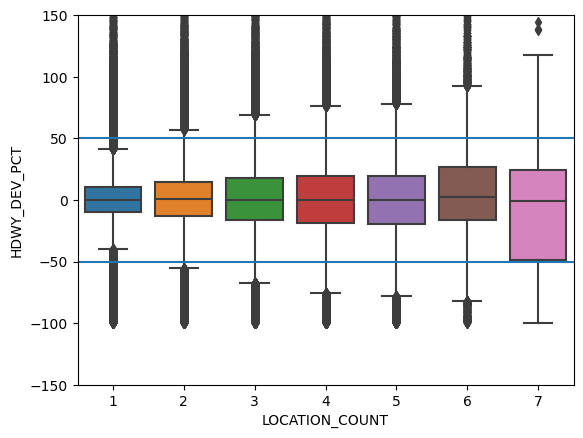

In [34]:
ax = sns.boxplot(data = wego.loc[wego['HDWY_DEV_PCT'] < 500].loc[wego['LOCATION_COUNT'].isin(alistof7)], x = 'LOCATION_COUNT', y = 'HDWY_DEV_PCT')

ax.set_ylim([-150,150])
#ax.set_xlim([0,7])
#plt.xlim([1,7])

ax.axhline(50)

ax.axhline(-50)

plt.show()

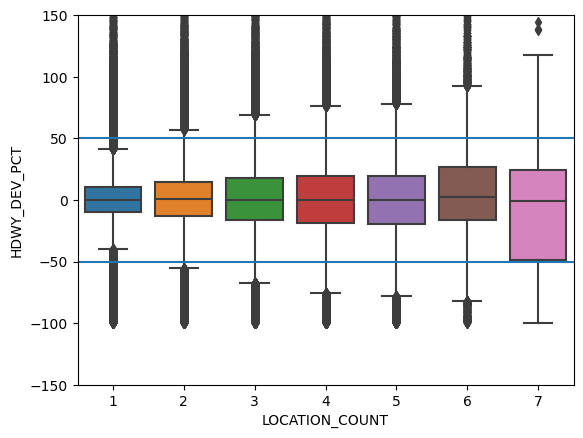

In [35]:
ax = sns.boxplot(data = wego_alldep.loc[wego_alldep['HDWY_DEV_PCT'] < 500].loc[wego_alldep['LOCATION_COUNT'].isin(alistof7)], x = 'LOCATION_COUNT', y = 'HDWY_DEV_PCT')

ax.set_ylim([-150,150])
#ax.set_xlim([0,7])
#plt.xlim([1,7])

ax.axhline(50)

ax.axhline(-50)

plt.show()

In [36]:
print(wego.shape)
print(wego_alldep.shape)

(343176, 35)
(332028, 35)


In [37]:
print(wego['DATE_TRIP'].nunique())
print(wego['LOCATION_COUNT'].value_counts())

print(wego_alldep['DATE_TRIP'].nunique())
print(wego_alldep['LOCATION_COUNT'].value_counts())


66103
LOCATION_COUNT
1     66103
2     66102
3     65641
4     53659
5     47471
6     32781
7     10131
8       297
9       283
10      256
11      171
12      162
13       61
14       58
Name: count, dtype: int64
65207
LOCATION_COUNT
1     64453
2     64186
3     63276
4     52228
5     46233
6     31174
7      9672
8       185
9       184
10      159
11      111
12      102
13       36
14       29
Name: count, dtype: int64


In [38]:
datetriplist = list(wego_alldep['DATE_TRIP'].unique())

In [39]:
len(datetriplist)

65207

In [40]:
triplist = list(wego_alldep['TRIP_ID'].unique())
len(triplist)

3913

In [41]:
trip_length = pd.DataFrame(dict(trip= [], timedelta= []))
trip_length

,trip,timedelta


In [42]:
trip_length.dtypes

trip         float64
timedelta    float64
dtype: object

In [43]:
wego_alldep['SCHEDULED_DATETIME']

0         2023-08-01 04:42:00
1         2023-08-01 04:46:00
2         2023-08-01 04:54:00
3         2023-08-01 05:10:00
4         2023-08-01 05:15:00
                 ...         
350323    2023-09-30 22:23:00
350324    2023-09-30 22:38:00
350325    2023-09-30 22:45:00
350326    2023-09-30 22:59:00
350327    2023-09-30 23:11:00
Name: SCHEDULED_DATETIME, Length: 332028, dtype: object

In [44]:
wego_alldep['SCHEDULED_DATETIME'] = pd.to_datetime(wego_alldep['SCHEDULED_DATETIME'])

C:\Users\dougl\AppData\Local\Temp\ipykernel_14660\38202775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego_alldep['SCHEDULED_DATETIME'] = pd.to_datetime(wego_alldep['SCHEDULED_DATETIME'])


# Big stinkin loop

In [45]:
#df1 = pd.DataFrame([['a', 1], ['b', 2]],
#                   columns=['letter', 'number'])

In [46]:
counter = 0
for trip in triplist:
    a = trip
    temp_df = wego_alldep.loc[wego_alldep['TRIP_ID']== a]
    b = (temp_df.loc[temp_df['TRIP_EDGE'] == 2].reset_index(drop=True).loc[0]['SCHEDULED_DATETIME'] -
                    temp_df.loc[temp_df['TRIP_EDGE'] == 1].reset_index(drop=True).loc[0]['SCHEDULED_DATETIME'])
    new_row = pd.DataFrame([[a, b]], columns=['trip','timedelta'])
    trip_length = pd.concat([trip_length, new_row], ignore_index=True)
trip_length

,trip,timedelta
0,345104.0,0 days 00:28:00
1,345105.0,0 days 00:17:00
2,345106.0,0 days 00:28:00
3,345107.0,0 days 00:20:00
4,345108.0,0 days 00:28:00
...,...,...
3908,350464.0,0 days 00:48:00
3909,350465.0,0 days 00:26:00
3910,350966.0,0 days 00:25:00
3911,351150.0,0 days 00:49:00


In [47]:
trip_length[['timedelta']].describe()

,timedelta
count,3913
mean,0 days 00:51:14.137490416
std,0 days 17:07:23.815183577
min,-7 days +00:25:00
25%,0 days 00:29:00
50%,0 days 00:39:00
75%,0 days 00:46:00
max,7 days 00:53:00


In [48]:
trip_length.loc[trip_length['timedelta'] > dt.timedelta(days =1)]

,trip,timedelta
11,345115.0,2 days 00:15:00
36,345215.0,1 days 00:40:00
308,346064.0,2 days 00:37:00
434,346406.0,1 days 00:55:00
453,346818.0,1 days 00:38:00
...,...,...
3338,351153.0,7 days 00:41:00
3802,350051.0,1 days 00:14:00
3806,350055.0,1 days 00:15:00
3846,351196.0,1 days 00:49:00


# Trip Length (result of loop) has trips with length over one day or negative removed

In [49]:
trip_length = trip_length.loc[trip_length['timedelta'] < dt.timedelta(days =1)]

In [50]:
trip_length = trip_length.loc[trip_length['timedelta'] > dt.timedelta(days =0)]

In [51]:
trip_length['timedelta'].describe()

count                         3782
mean     0 days 00:37:38.566895822
std      0 days 00:10:06.627034336
min                0 days 00:10:00
25%                0 days 00:29:00
50%                0 days 00:39:00
75%                0 days 00:46:00
max                0 days 01:05:00
Name: timedelta, dtype: object

In [52]:
trip_length['trip'] = trip_length['trip'].astype(int)

In [53]:
trip_length.dtypes

trip                   int32
timedelta    timedelta64[ns]
dtype: object

# Trip Dev(iations) is wego data with trip ids removed of trip lengths over one day or negative

# This is reduces the examined data from 332K rows to 320K
# And 3913 trip ids down to 3782

In [54]:
trip_dev = wego_alldep.loc[wego_alldep['TRIP_ID'].isin(trip_length['trip'])]

In [55]:
trip_length['timedelta'].unique()

<TimedeltaArray>
['0 days 00:28:00', '0 days 00:17:00', '0 days 00:20:00', '0 days 00:21:00',
 '0 days 00:25:00', '0 days 00:22:00', '0 days 00:34:00', '0 days 00:24:00',
 '0 days 00:33:00', '0 days 00:15:00', '0 days 00:23:00', '0 days 00:14:00',
 '0 days 00:40:00', '0 days 00:32:00', '0 days 00:31:00', '0 days 00:19:00',
 '0 days 00:16:00', '0 days 00:18:00', '0 days 00:13:00', '0 days 00:29:00',
 '0 days 00:26:00', '0 days 00:30:00', '0 days 00:27:00', '0 days 00:39:00',
 '0 days 00:55:00', '0 days 00:45:00', '0 days 00:46:00', '0 days 00:47:00',
 '0 days 00:42:00', '0 days 00:44:00', '0 days 00:41:00', '0 days 00:37:00',
 '0 days 00:35:00', '0 days 00:38:00', '0 days 00:50:00', '0 days 00:49:00',
 '0 days 00:48:00', '0 days 00:54:00', '0 days 00:56:00', '0 days 00:51:00',
 '0 days 00:52:00', '0 days 00:53:00', '0 days 00:58:00', '0 days 00:36:00',
 '0 days 00:43:00', '0 days 01:03:00', '0 days 00:57:00', '0 days 01:01:00',
 '0 days 01:05:00', '0 days 00:59:00', '0 days 01:00:00', '

In [56]:
trip_dev = trip_dev.merge(trip_length, how='left', left_on = 'TRIP_ID', right_on = 'trip')

<Axes: xlabel='timedelta', ylabel='HDWY_DEV'>

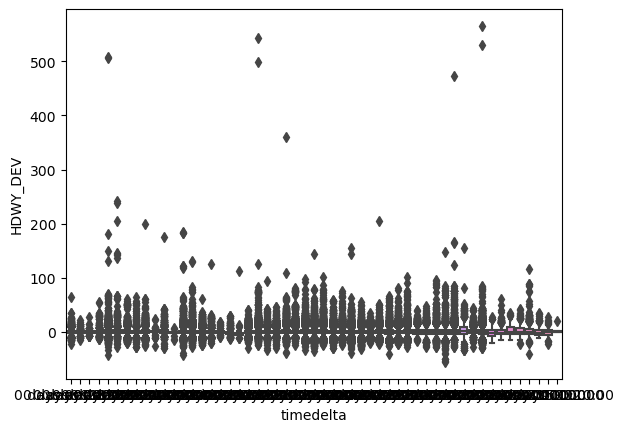

In [57]:
sns.boxplot(data = trip_dev, x = 'timedelta', y = 'HDWY_DEV')

In [58]:
trip_deltas =  trip_dev['timedelta'].value_counts().reset_index().sort_values('timedelta')
trip_deltas['trip_time'] = trip_deltas['timedelta'].astype(str)
trip_deltas.head()

,timedelta,count,trip_time
52,0 days 00:10:00,138,0 days 00:10:00
46,0 days 00:13:00,386,0 days 00:13:00
50,0 days 00:14:00,245,0 days 00:14:00
43,0 days 00:15:00,586,0 days 00:15:00
41,0 days 00:16:00,826,0 days 00:16:00


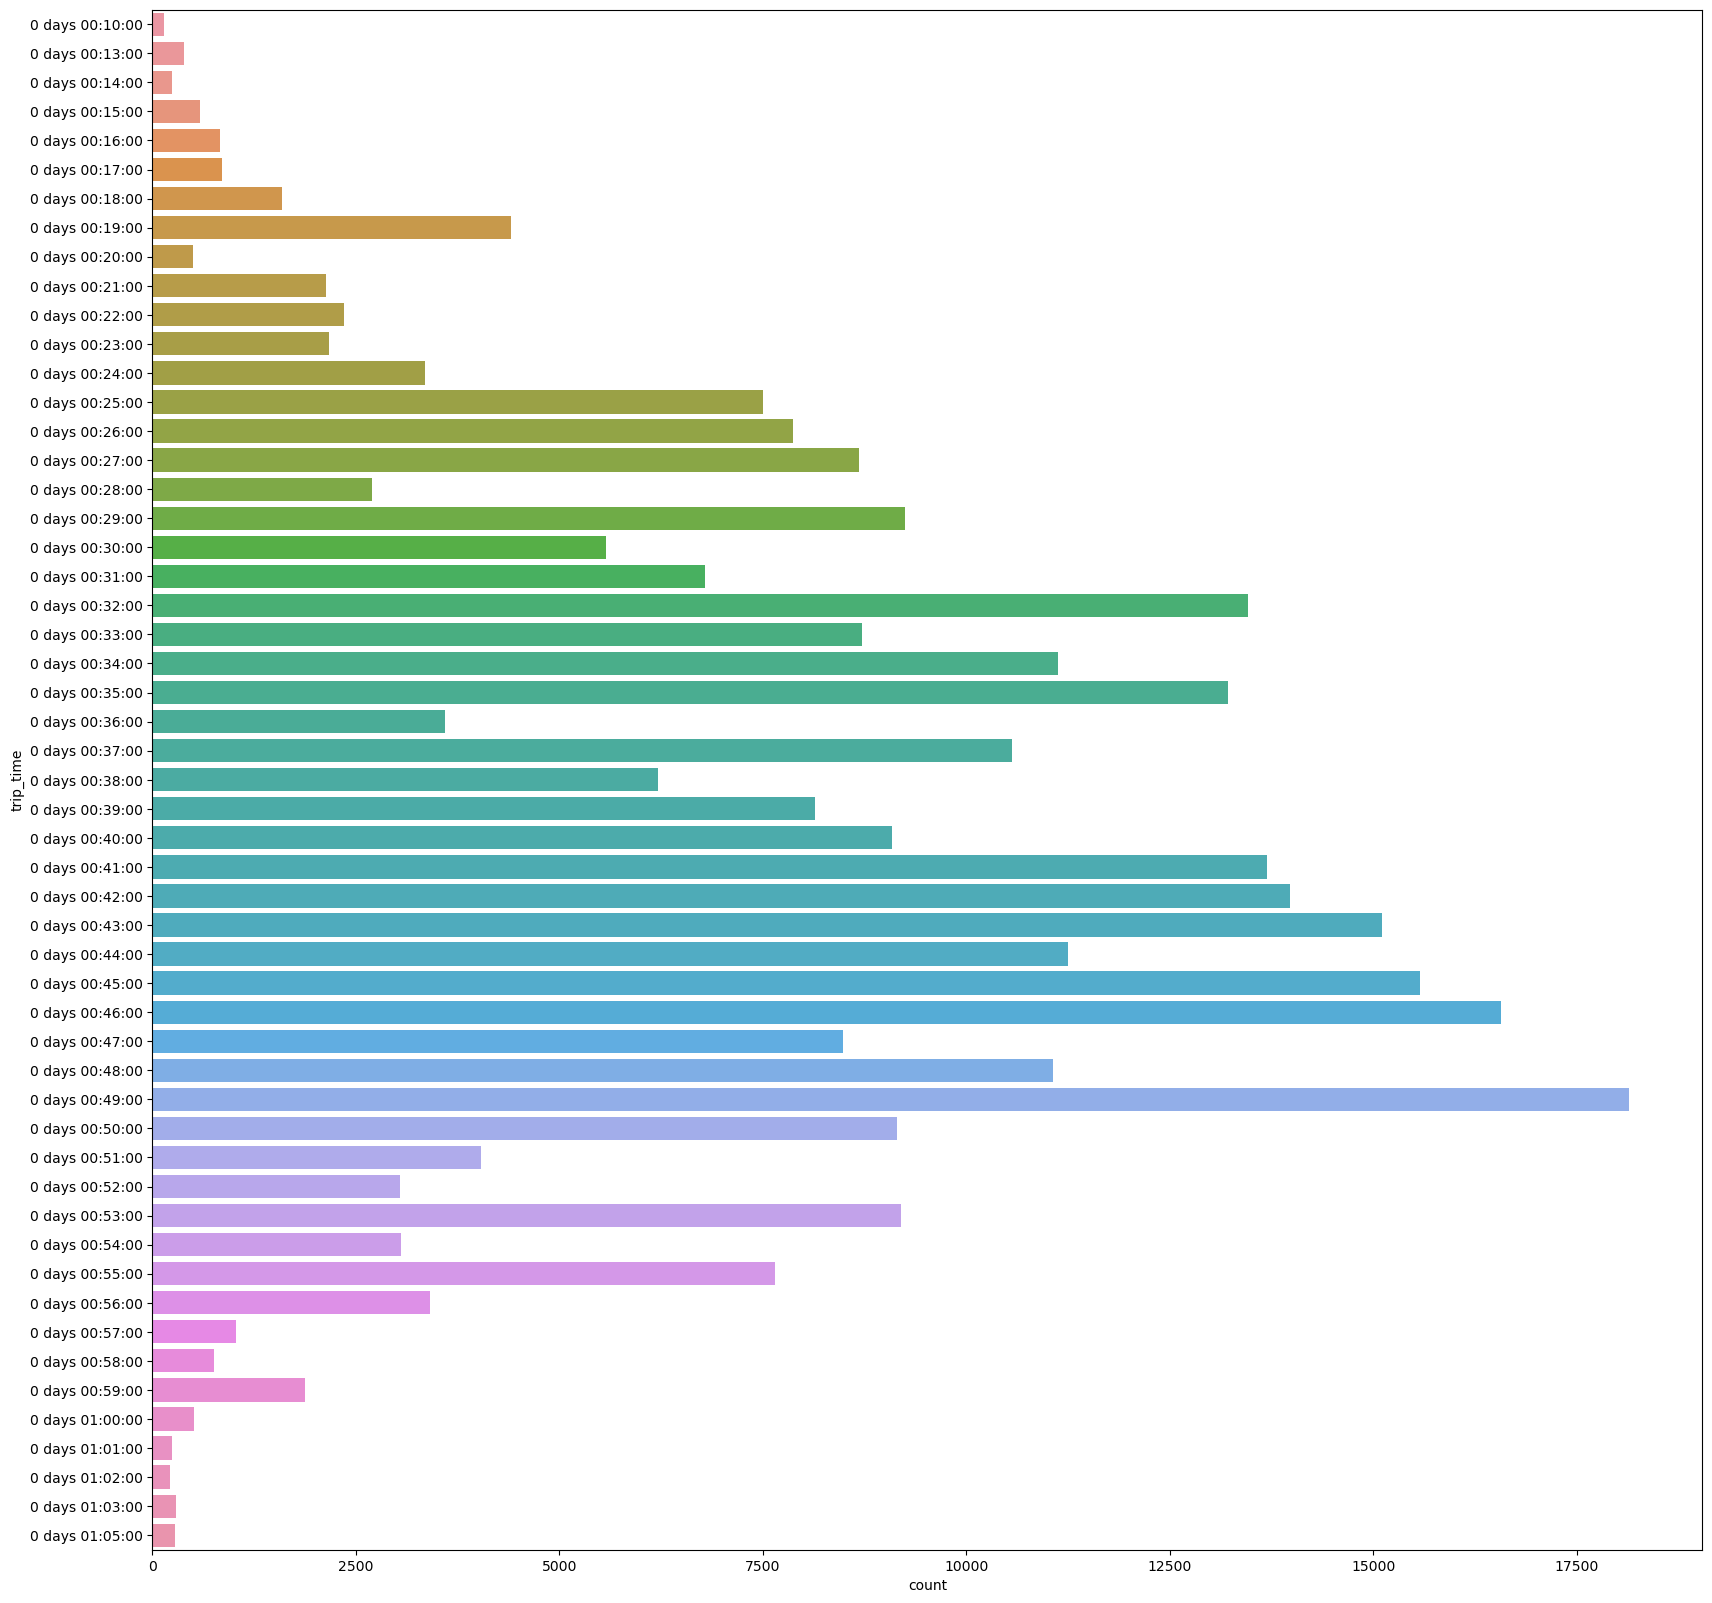

In [59]:
fig, ax = plt.subplots(figsize = (20,20))

ax = sns.barplot(data = trip_deltas, y = 'trip_time', x = 'count', orient = 'h')


In [60]:
trip_deltas['minutes'] = (trip_deltas['timedelta'].dt.total_seconds()/60).astype(int)

In [61]:
trip_deltas

,timedelta,count,trip_time,minutes
52,0 days 00:10:00,138,0 days 00:10:00,10
46,0 days 00:13:00,386,0 days 00:13:00,13
50,0 days 00:14:00,245,0 days 00:14:00,14
43,0 days 00:15:00,586,0 days 00:15:00,15
41,0 days 00:16:00,826,0 days 00:16:00,16
40,0 days 00:17:00,853,0 days 00:17:00,17
38,0 days 00:18:00,1597,0 days 00:18:00,18
26,0 days 00:19:00,4401,0 days 00:19:00,19
45,0 days 00:20:00,501,0 days 00:20:00,20
36,0 days 00:21:00,2133,0 days 00:21:00,21


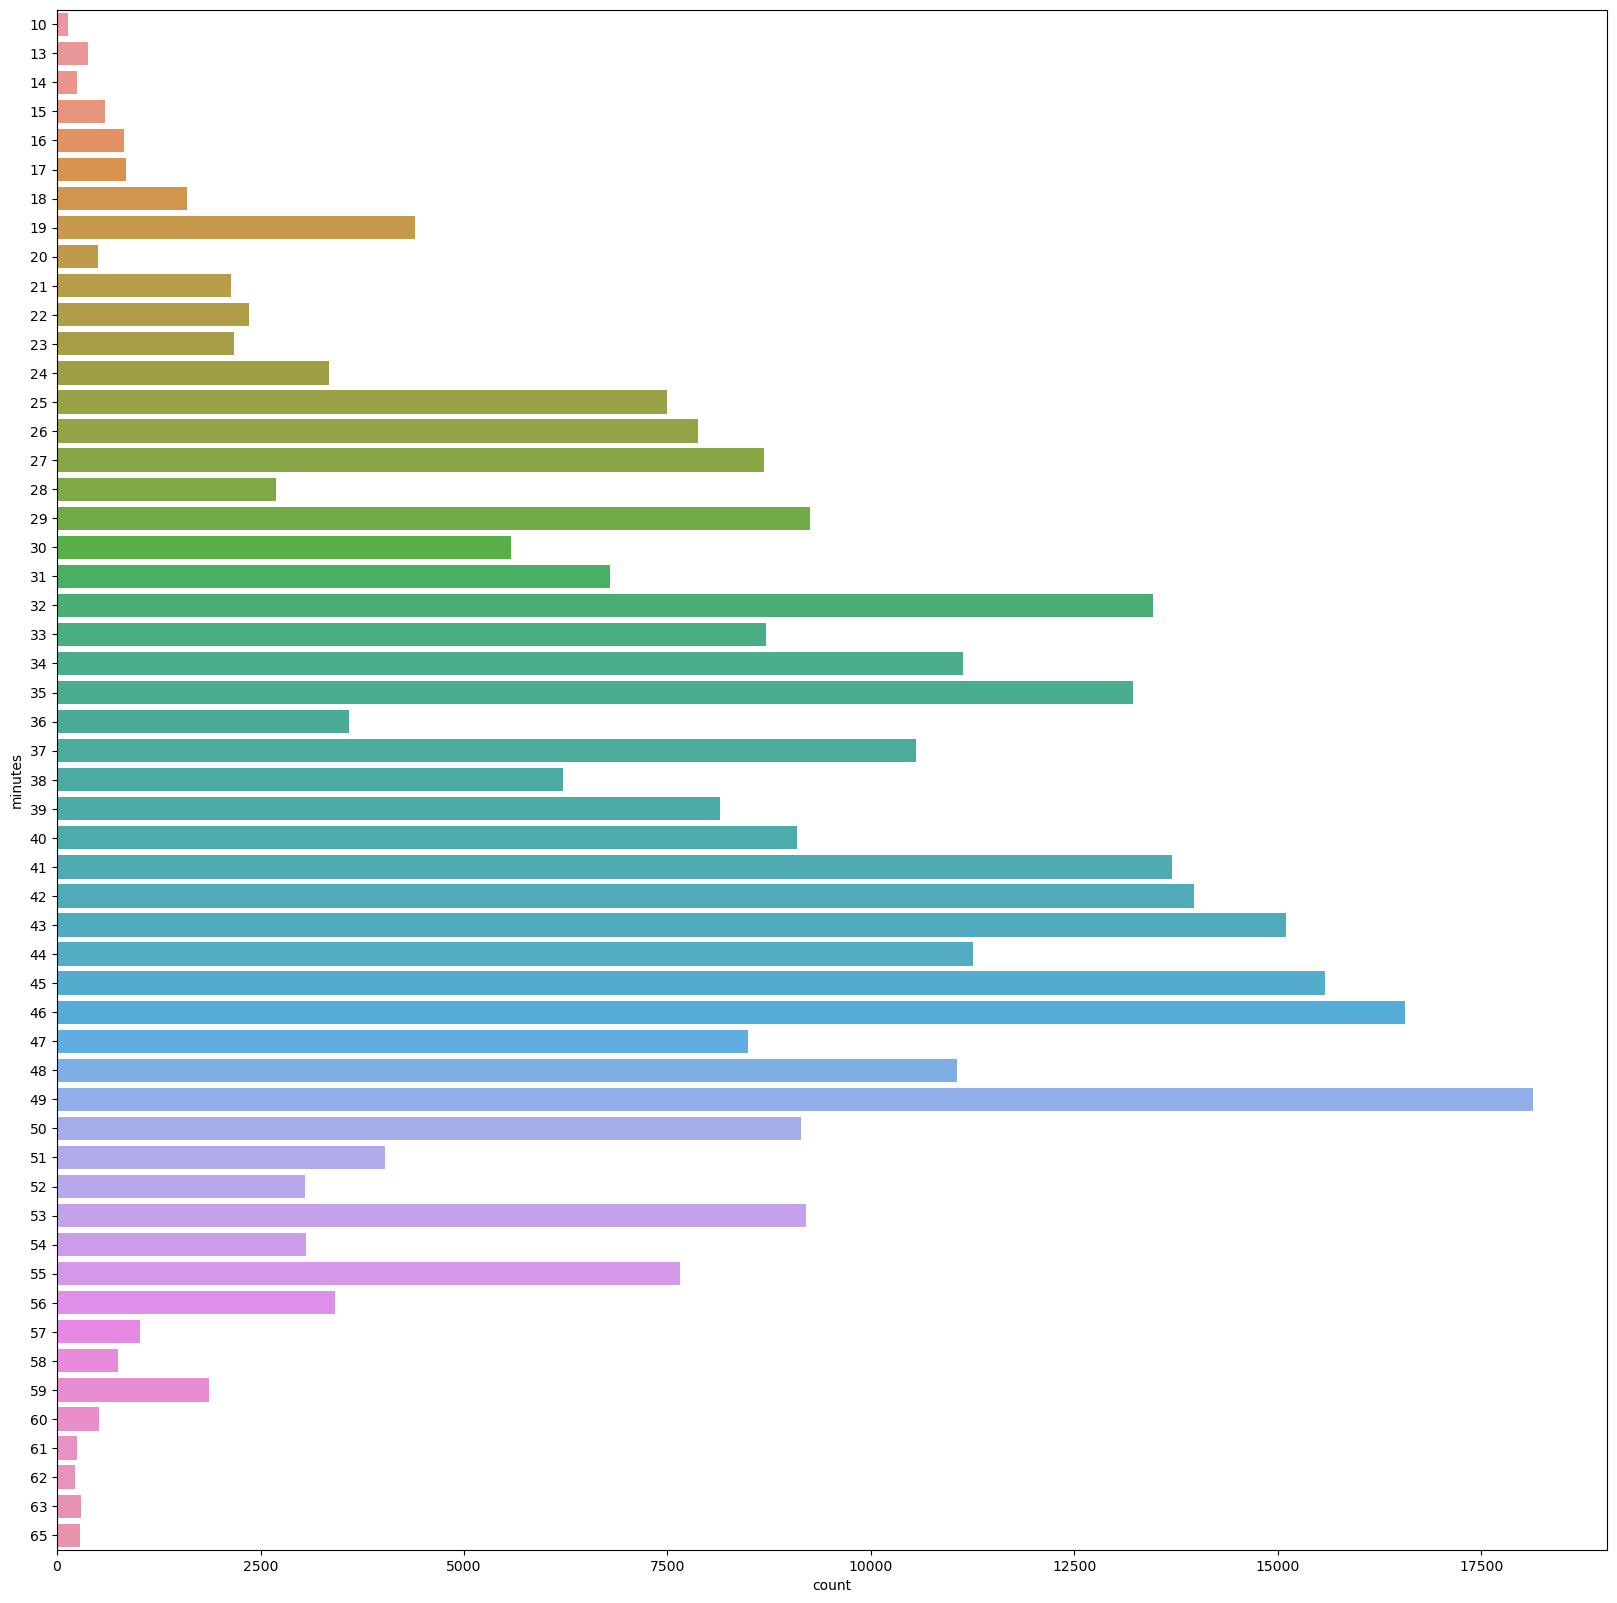

In [62]:
fig, ax = plt.subplots(figsize = (20,20))

ax = sns.barplot(data = trip_deltas, y = 'minutes', x = 'count', orient = 'h')

In [63]:
trip_dev['minutes'] = (trip_dev['timedelta'].dt.total_seconds()/60).astype(int)

In [64]:
trip_dev

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,BLOCK_STOP_ORDER,DWELL_IN_MINS,DATE_TRIP,LOCATION_COUNT,HDWY_DEV_PCT,HDWY_FLAG,SCHEDULED_DATETIME,trip,timedelta,minutes
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,2,6.500000,120230801345104,1,NaN,NaN,2023-08-01 04:42:00,345104,0 days 00:28:00,28
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,9,0.000000,120230801345104,2,NaN,NaN,2023-08-01 04:46:00,345104,0 days 00:28:00,28
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,19,0.000000,120230801345104,3,NaN,NaN,2023-08-01 04:54:00,345104,0 days 00:28:00,28
3,120230801,1,99457893,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,35,0.000000,120230801345104,4,NaN,NaN,2023-08-01 05:10:00,345104,0 days 00:28:00,28
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,36,12.866666,120230801345105,1,NaN,NaN,2023-08-01 05:15:00,345105,0 days 00:17:00,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320592,120230930,2,100406610,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,539,0.000000,120230930353448,2,17.555553,9.733334,2023-09-30 22:23:00,353448,0 days 00:22:00,22
320593,120230930,2,100406611,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,551,0.000000,120230930353448,3,NaN,NaN,2023-09-30 22:38:00,353448,0 days 00:22:00,22
320594,120230930,2,100406612,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,552,0.000000,120230930353449,1,6.222220,13.133334,2023-09-30 22:45:00,353449,0 days 00:26:00,26
320595,120230930,2,100406613,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,563,0.000000,120230930353449,2,58.333333,-2.500000,2023-09-30 22:59:00,353449,0 days 00:26:00,26


<Axes: >

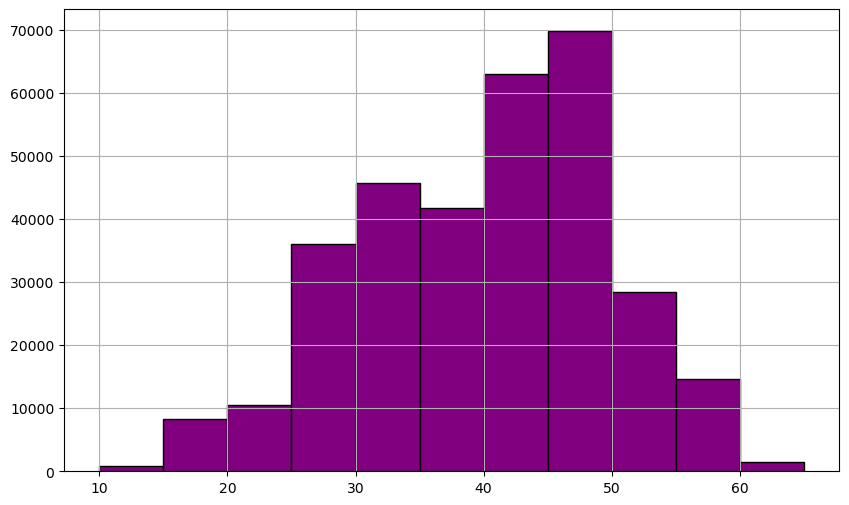

In [65]:
trip_dev['minutes'].hist(bins = 11,
                            color = 'purple',
                            edgecolor = 'black',
                            figsize = (10,6)
                            )

In [66]:
trip_dev['minutes'].max()

65

In [67]:
trip_dev['minute_category'] = (trip_dev['minutes']/10).astype(int).astype(str)+'x minutes'

(-20.0, 20.0)

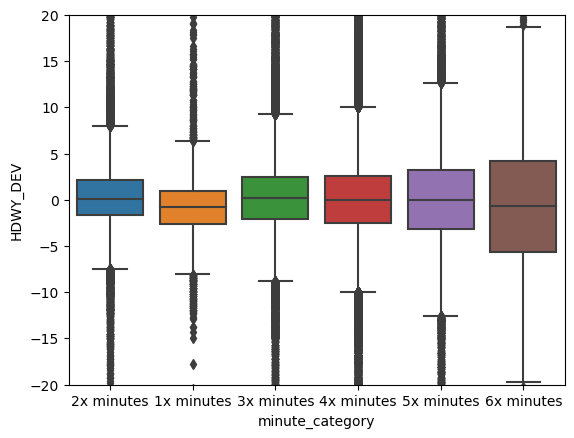

In [68]:
ax = sns.boxplot(data = trip_dev, x = 'minute_category', y = 'HDWY_DEV')

ax.set_ylim([-20,20])

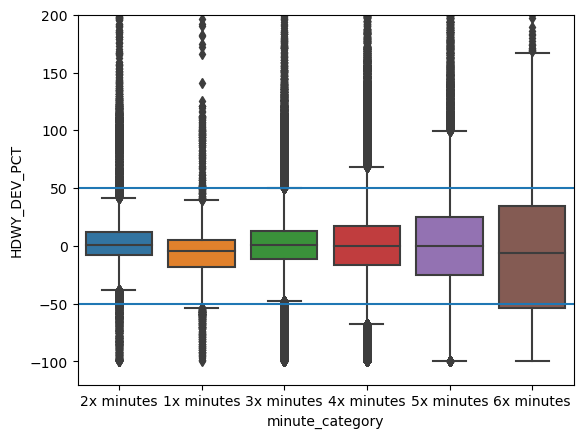

In [69]:
ax = sns.boxplot(data = trip_dev, x = 'minute_category', y = 'HDWY_DEV_PCT')

ax.set_ylim([-120,200])

ax.axhline(50)

ax.axhline(-50)

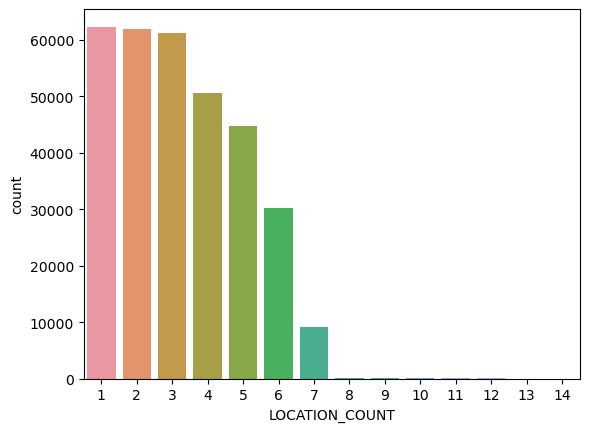

In [70]:
ax = sns.barplot(data = trip_dev['LOCATION_COUNT'].value_counts().reset_index(), x = 'LOCATION_COUNT', y = 'count')



In [71]:
stop_count = trip_dev['LOCATION_COUNT'].value_counts().reset_index()

In [72]:
stop_count = stop_count.loc[stop_count['LOCATION_COUNT']<8]

<Axes: xlabel='Timepoints', ylabel='Trips'>

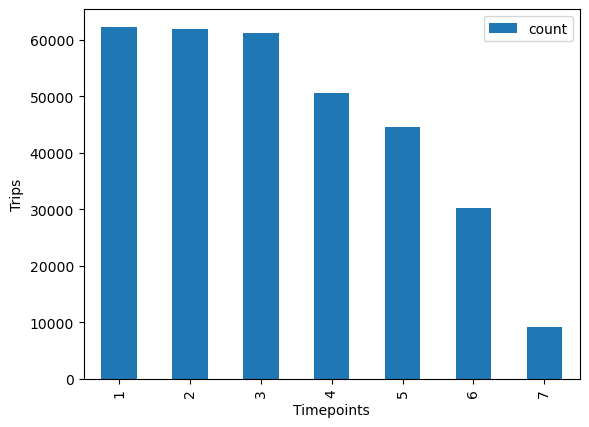

In [73]:
stop_count.plot.bar(x = 'LOCATION_COUNT', y = 'count', xlabel = 'Timepoints', ylabel = 'Trips')

In [74]:
trip_length['minutes'] = (trip_length['timedelta'].dt.total_seconds()/60).astype(int)

<Axes: >

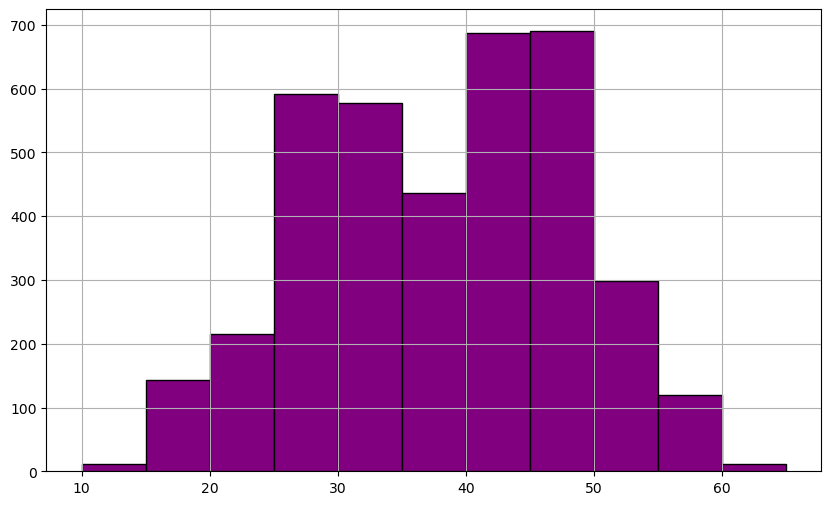

In [75]:
# about 3900 trips examined
# 53 different scheduled trip lengths from 10 minutes to 65 minutes

trip_length.minutes.hist(bins = 11,
                            color = 'purple',
                            edgecolor = 'black',
                            figsize = (10,6))

In [76]:
len(trip_deltas)

53

In [77]:
trip_deltas.describe()

,timedelta,count,minutes
count,53,53.000000,53.000000
mean,0 days 00:37:58.867924528,6049.000000,37.981132
std,0 days 00:15:32.601119238,5186.560503,15.543352
min,0 days 00:10:00,138.000000,10.000000
25%,0 days 00:25:00,1021.000000,25.000000
50%,0 days 00:38:00,4401.000000,38.000000
75%,0 days 00:51:00,9201.000000,51.000000
max,0 days 01:05:00,18137.000000,65.000000


In [78]:
trip_dev['LOCATION_COUNT'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

In [79]:
trip_dev.loc[trip_dev['LOCATION_COUNT'] == 14][['ROUTE_ABBR','minutes']]

,ROUTE_ABBR,minutes
22446,56,45
48127,56,46
64278,56,44
77358,52,45
79699,56,45
92999,23,45
104643,56,39
104747,56,50
110768,56,44
118041,23,55


In [80]:
trip_dev.dtypes

CALENDAR_ID                            int64
SERVICE_ABBR                           int64
ADHERENCE_ID                           int64
DATE                                  object
ROUTE_ABBR                             int64
BLOCK_ABBR                             int64
OPERATOR                               int64
TRIP_ID                                int64
OVERLOAD_ID                            int64
ROUTE_DIRECTION_NAME                  object
TIME_POINT_ABBR                       object
ROUTE_STOP_SEQUENCE                  float64
TRIP_EDGE                              int64
LATITUDE                             float64
LONGITUDE                            float64
SCHEDULED_TIME                        object
ACTUAL_ARRIVAL_TIME                   object
ACTUAL_DEPARTURE_TIME                 object
ADHERENCE                            float64
SCHEDULED_HDWY                       float64
ACTUAL_HDWY                          float64
HDWY_DEV                             float64
ADJUSTED_E

In [81]:
trip_dev.groupby(by = 'trip').max('LOCATION_COUNT')['LOCATION_COUNT'].reset_index()['LOCATION_COUNT'].value_counts()

LOCATION_COUNT
6     1291
5      793
3      649
7      533
4      329
12      62
10      46
14      25
9       14
11      11
8       10
13      10
2        9
Name: count, dtype: int64

In [82]:
trip_id_and_stops = trip_dev.groupby(by = 'TRIP_ID').max('LOCATION_COUNT')['LOCATION_COUNT'].reset_index()['LOCATION_COUNT'].value_counts().reset_index()

<Axes: xlabel='Timepoints', ylabel='Trip IDs'>

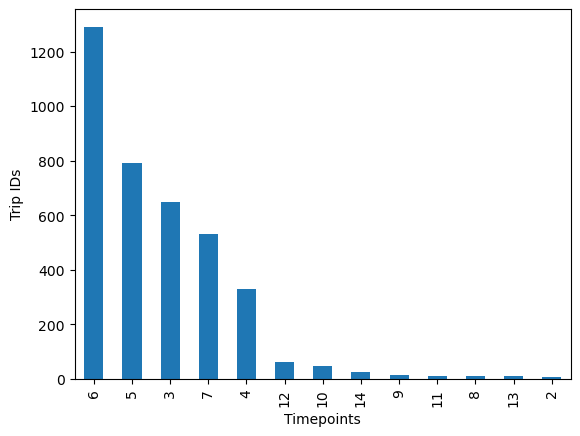

In [102]:
trip_id_and_stops.plot.bar(x = 'LOCATION_COUNT', 
                           y = 'count', 
                           xlabel = 'Timepoints', 
                           ylabel = 'Trip IDs',
                          legend = False
                          )


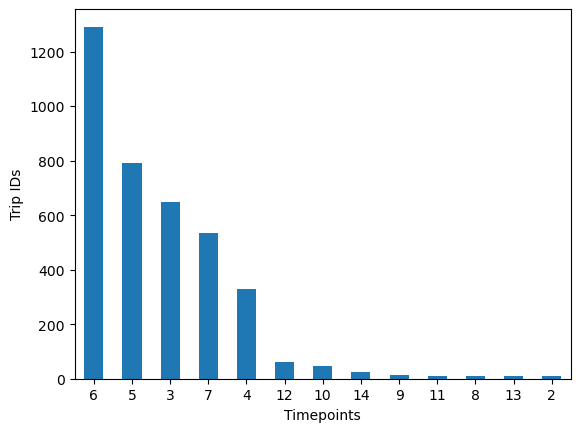

In [107]:
trip_id_and_stops.plot.bar(x = 'LOCATION_COUNT', 
                           y = 'count', 
                          legend = False
                          )
plt.xlabel('Timepoints')
plt.ylabel('Trip IDs')
plt.xticks(rotation = 0)
plt.show();

Text(0, 0.5, 'Trip IDs')

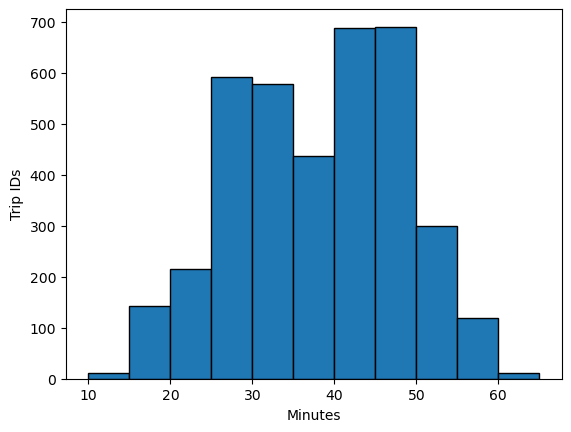

In [105]:
trip_length.minutes.plot.hist(bins = 11, edgecolor='black',
                              )
plt.xlabel('Minutes')
plt.ylabel('Trip IDs')


<Axes: ylabel='minutes'>

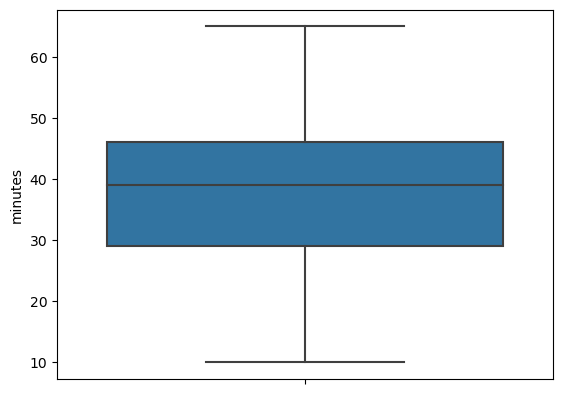

In [85]:
sns.boxplot(data = trip_length, y = 'minutes')

In [86]:
trip_length

,trip,timedelta,minutes
0,345104,0 days 00:28:00,28
1,345105,0 days 00:17:00,17
2,345106,0 days 00:28:00,28
3,345107,0 days 00:20:00,20
4,345108,0 days 00:28:00,28
...,...,...,...
3908,350464,0 days 00:48:00,48
3909,350465,0 days 00:26:00,26
3910,350966,0 days 00:25:00,25
3911,351150,0 days 00:49:00,49


In [87]:
len(trip_dev.TRIP_ID.unique())

3782

In [88]:
len(triplist)

3913

In [89]:
len(trip_length.trip.unique())

3782

In [90]:
len(triplist) - len(trip_length.trip.unique())

131

In [91]:
print(wego_alldep.shape)
print(trip_dev.shape)

(332028, 35)
(320597, 39)


In [92]:
print(wego.TRIP_ID.value_counts())
print(trip_dev.TRIP_ID.value_counts())

TRIP_ID
352988    294
352940    294
352287    294
353096    287
353000    287
         ... 
345414      9
345415      9
345416      9
345417      9
348670      9
Name: count, Length: 3913, dtype: int64
TRIP_ID
352790    285
353092    284
350335    283
350414    283
352992    281
         ... 
348620      7
348619      7
348491      7
345223      6
345222      6
Name: count, Length: 3782, dtype: int64


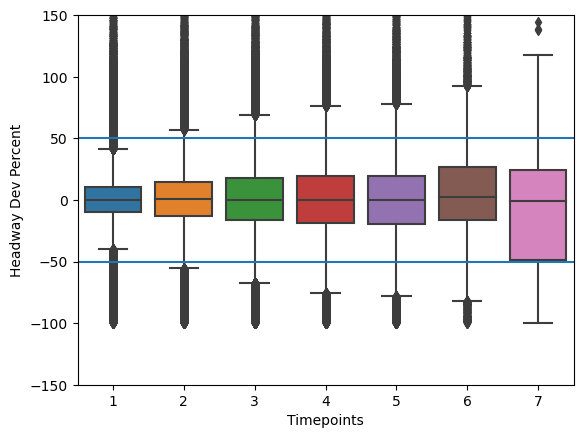

In [93]:
ax = sns.boxplot(data = wego_alldep.loc[wego_alldep['HDWY_DEV_PCT'] < 500].loc[wego_alldep['LOCATION_COUNT'].isin(alistof7)], x = 'LOCATION_COUNT', y = 'HDWY_DEV_PCT')

ax.set_ylim([-150,150])
#ax.set_xlim([0,7])
#plt.xlim([1,7])
plt.xlabel('Timepoints')
plt.ylabel('Headway Dev Percent')

ax.axhline(50)

ax.axhline(-50)

plt.show()

In [94]:
#trip_dev['minute_category'].astype(str)
trip_dev['minute_rank'] = (trip_dev['minutes']/10).astype(int)

In [95]:
trip_dev

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,DATE_TRIP,LOCATION_COUNT,HDWY_DEV_PCT,HDWY_FLAG,SCHEDULED_DATETIME,trip,timedelta,minutes,minute_category,minute_rank
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,120230801345104,1,NaN,NaN,2023-08-01 04:42:00,345104,0 days 00:28:00,28,2x minutes,2
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,120230801345104,2,NaN,NaN,2023-08-01 04:46:00,345104,0 days 00:28:00,28,2x minutes,2
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,120230801345104,3,NaN,NaN,2023-08-01 04:54:00,345104,0 days 00:28:00,28,2x minutes,2
3,120230801,1,99457893,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,120230801345104,4,NaN,NaN,2023-08-01 05:10:00,345104,0 days 00:28:00,28,2x minutes,2
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,120230801345105,1,NaN,NaN,2023-08-01 05:15:00,345105,0 days 00:17:00,17,1x minutes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320592,120230930,2,100406610,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,120230930353448,2,17.555553,9.733334,2023-09-30 22:23:00,353448,0 days 00:22:00,22,2x minutes,2
320593,120230930,2,100406611,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,120230930353448,3,NaN,NaN,2023-09-30 22:38:00,353448,0 days 00:22:00,22,2x minutes,2
320594,120230930,2,100406612,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,120230930353449,1,6.222220,13.133334,2023-09-30 22:45:00,353449,0 days 00:26:00,26,2x minutes,2
320595,120230930,2,100406613,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,120230930353449,2,58.333333,-2.500000,2023-09-30 22:59:00,353449,0 days 00:26:00,26,2x minutes,2


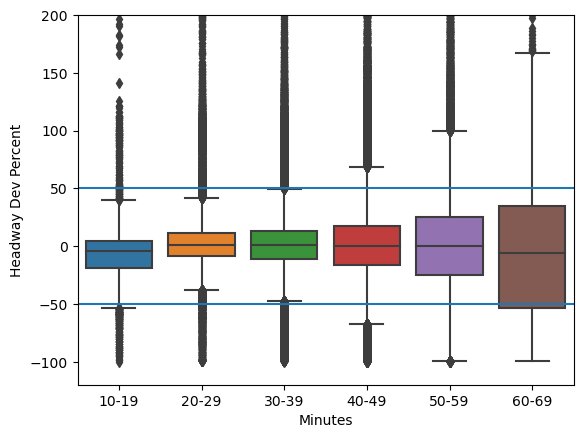

In [96]:
ax = sns.boxplot(data = trip_dev, x = 'minute_rank', y = 'HDWY_DEV_PCT')

plt.xlabel('Minutes')
plt.ylabel('Headway Dev Percent')

ax.set_xticklabels(['10-19','20-29','30-39','40-49','50-59','60-69'])

ax.set_ylim([-120,200])

ax.axhline(50)

ax.axhline(-50)

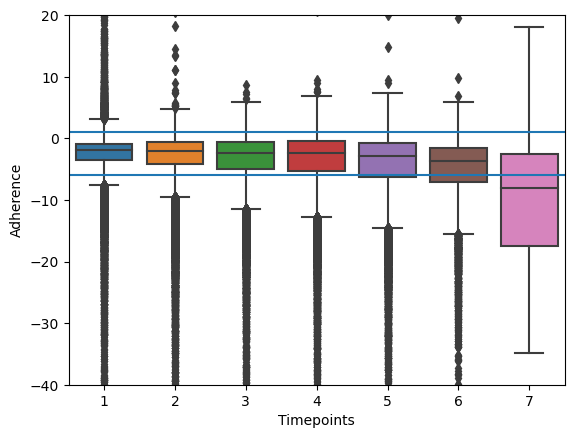

In [114]:
ax = sns.boxplot(data = wego_alldep.loc[wego_alldep['HDWY_DEV_PCT'] < 500].loc[wego_alldep['LOCATION_COUNT'].isin(alistof7)], x = 'LOCATION_COUNT', y = 'ADHERENCE')

ax.set_ylim([-40,20])
#ax.set_xlim([0,7])
#plt.xlim([1,7])
plt.xlabel('Timepoints')
plt.ylabel('Adherence')

ax.axhline(1)

ax.axhline(-6)

plt.show()

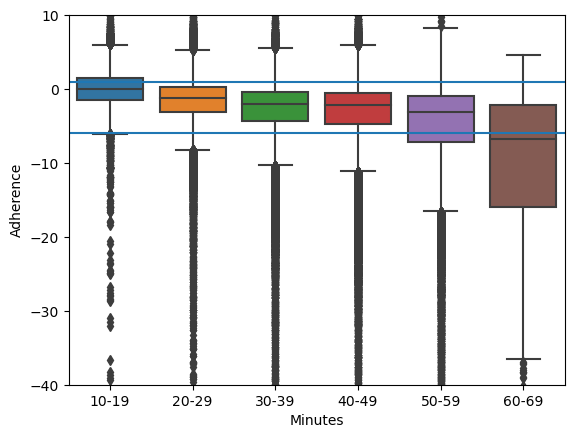

In [111]:
ax = sns.boxplot(data = trip_dev, x = 'minute_rank', y = 'ADHERENCE')

plt.xlabel('Minutes')
plt.ylabel('Adherence')

ax.set_xticklabels(['10-19','20-29','30-39','40-49','50-59','60-69'])

ax.set_ylim([-40,10])

ax.axhline(1)

ax.axhline(-6)